In [ ]:
from lib import fabricate, analyze, preprocess
import numpy as np
import pandas as pd
from scipy.linalg import block_diag

In [ ]:
data = fabricate.fabricate_base_data()

In [ ]:
from numpy.random import default_rng

rng = default_rng(seed=42)  # reproducibility

# Step 1: Keep your existing stats_list
stats_list = [
    (10, 5, 0, 30, "continuous"),   # Recharge Frequency (per month)
    (2000, 1000, 200, 5000, "continuous"), # Utility Bills (per month)
    (3, 2, 0, 10, "continuous"),    # International Transactions
    (2, 2, 0, 12, "continuous"),    # UPI Failures
    (1, 1, 0, 5, "continuous"),     # Registered Vehicles
    (2, 1, 0, 10, "continuous"),    # Registered Vehicles Challan (per year)
    (2, 1, 0, 5, "continuous"),     # Insurances
    (2, 1, 0, 10, "continuous"),    # Trading Accounts
    (3, 2, 0, 10, "continuous"),    # Licenses
    (1, 1, 0, 5, "continuous"),     # FDs Dissolved
    (3, 2, 0, 10, "continuous"),    # Accounts
    (4, 3, 0, 12, "continuous"),    # Public Memberships
    (1, 1, 0, 4, "continuous"),     # Default in GST filing (per quarter)
    (5, 3, 0, 20, "continuous"),    # VPN Usage (hours per week)
    (1, 1, 0, 5, "continuous"),     # SIM Card Changes
    (4, 2, 0, 10, "continuous"),    # Streaming Services
    (15, 10, 0, 60, "continuous"),  # Payment Delay of Streaming Services (days/year)
    (2, 2, 0, 8, "continuous"),     # Smart Cards
    (2, 1, 0, 5, "continuous"),     # Antivirus Subscriptions
    (3, 2, 0, 10, "continuous"),    # Shopping Behavior (returns/month)
    (5000, 2000, 500, 15000, "continuous"), # Medical Bills (per year)
    (3, 2, 0, 10, "continuous"),    # Certificates
    (2000, 1500, 200, 10000, "continuous"), # Pet Bills (per year)
    (2, 1, 0, 6, "continuous")      # Dependents
]

numeric_columns = [
    "Recharge Frequency (per month)",
    "Utility Bills (per month)",
    "International Transactions",
    "UPI Failures",
    "Registered Vehicles",
    "Registered Vehicles Challan (per year)",
    "Insurances",
    "Trading Accounts",
    "Licenses",
    "FDs Dissolved",
    "Accounts",
    "Public Memberships",
    "Default in GST filing (per quarter)",
    "VPN Usage (hours per week)",
    "SIM Card Changes",
    "Streaming Services",
    "Payment Delay of Streaming Services (days/year)",
    "Smart Cards",
    "Antivirus Subscriptions",
    "Shopping Behavior (returns/month)",
    "Medical Bills (per year)",
    "Certificates",
    "Pet Bills (per year)",
    "Dependents"
]

# Step 2: Block correlation matrices
corr_payment_spending = np.array([
    [1.0, 0.45, 0.35, 0.30],
    [0.45, 1.0, 0.40, 0.33],
    [0.35, 0.40, 1.0, 0.38],
    [0.30, 0.33, 0.38, 1.0]
])

corr_asset_ownership = np.array([
    [1.0, 0.50, 0.40],
    [0.50, 1.0, 0.45],
    [0.40, 0.45, 1.0]
])

corr_fin_accounts = np.array([
    [1.0, 0.42, 0.30, 0.35],
    [0.42, 1.0, 0.38, 0.33],
    [0.30, 0.38, 1.0, 0.40],
    [0.35, 0.33, 0.40, 1.0]
])

corr_compliance_membership = np.array([
    [1.0, 0.28],
    [0.28, 1.0]
])

corr_digital = np.array([
    [1.0, 0.45, 0.35, 0.30, 0.25, 0.20],
    [0.45, 1.0, 0.32, 0.28, 0.26, 0.24],
    [0.35, 0.32, 1.0, 0.40, 0.30, 0.22],
    [0.30, 0.28, 0.40, 1.0, 0.33, 0.26],
    [0.25, 0.26, 0.30, 0.33, 1.0, 0.28],
    [0.20, 0.24, 0.22, 0.26, 0.28, 1.0]
])

corr_ecommerce = np.array([
    [1.0, 0.38, 0.35, 0.30],
    [0.38, 1.0, 0.36, 0.32],
    [0.35, 0.36, 1.0, 0.33],
    [0.30, 0.32, 0.33, 1.0]
])

corr_other = np.array([[1.0]])

# Step 3: Combine into full block diagonal matrix
correlation_matrix = block_diag(
    corr_payment_spending,
    corr_asset_ownership,
    corr_fin_accounts,
    corr_compliance_membership,
    corr_digital,
    corr_ecommerce,
    corr_other
)

# Step 4: Generate correlated standard normal data
n = 10000
L = np.linalg.cholesky(correlation_matrix)
uncorrelated = rng.normal(size=(n, correlation_matrix.shape[0]))
correlated = uncorrelated @ L.T

# Step 5: Scale each variable to match stats_list
scaled_data = []
for i, (mean, std, min_val, max_val, _) in enumerate(stats_list):
    col = correlated[:, i]
    col = (col - np.mean(col)) / np.std(col)  # standardize
    col = col * std + mean  # scale to desired mean/std
    col = np.clip(col, min_val, max_val)  # clip to min/max
    scaled_data.append(col)

df = pd.DataFrame(np.column_stack(scaled_data), columns=numeric_columns)

# Descriptive stats
stats = df[numeric_columns].describe().T
print("\nDescriptive Statistics:")
print(stats)

# Correlation
corr = df[numeric_columns].corr()
print("\nCorrelation Matrix:")
print(corr.round(2))

# Step 4: Categorical columns
occupation_categories = ('Salaried/Employed (Private/Public Sector)', 'Agriculturalists (Farmers)', 'Laborers/Skilled Workers', 'Students',  'Homemakers', 'Government Employees (Civil Services, Defense, Police)', 'Self-employed Professionals (Doctors, Lawyers, Chartered Accountants)', 'Retired/Pensioners', 'Business Owners/Entrepreneurs', 'Freelancers/Consultants', 'Unemployed/Jobseekers')
occupation_stats = (12.6, 23, 11.4, 19.2, 14.7, 3.2, 3.4, 6, 2.6, 2, 1.9)

education_categories = ('Primary or less', 'Secondary', 'Tertiary or more')
education_stats = (69.4, 16.4, 14.2)

partner_categories = ('Never Married', 'Currently Married', 'Widowed', 'Divorced')
partner_stats = (0.39, 0.475, 0.13, 0.005)

truecaller_categories = ('Red', 'Blue', 'Golden')
truecaller_stats = (0.2, 0.75, 0.05)

reviews_categories = ('1 Star', '2 Star', '3 Star', '4 Star', '5 Star')
reviews_stats = (4, 6, 5, 45, 40)

social_sentiments_categories = ('Strongly Negative', 'Negative', 'Neutral', 'Positive', 'Strongly Positive')
social_sentiments_stats = (20, 32, 32, 12, 4)

betting_categories = ('Yes', 'No')
betting_stats = (0.1, 0.9)

family_defaulters_stats=(1, 1, 0, 5, "continuous")

df['Occupation'] = fabricate.create_categorical_distribution(occupation_categories, occupation_stats, nan_probability=0.01)
df['Education'] = fabricate.create_categorical_distribution(education_categories, education_stats, nan_probability=0.01)
df['Partner'] = fabricate.create_categorical_distribution(partner_categories, partner_stats, nan_probability=0.01)
df['Betting Apps'] = fabricate.create_categorical_distribution(betting_categories, betting_stats, nan_probability=0.01)
df['TrueCaller Flag'] = fabricate.create_categorical_distribution(truecaller_categories, truecaller_stats, nan_probability=0.01)
df['Reviews received'] = fabricate.create_categorical_distribution(reviews_categories, reviews_stats, nan_probability=0.01)
df['Sentiment on Social Media'] = fabricate.create_categorical_distribution(social_sentiments_categories, social_sentiments_stats, nan_probability=0.01)
df['Family Defaulter'] = fabricate.create_truncated_norm_distribution(family_defaulters_stats,precision=0,nan_probability=0)


In [ ]:
data2 = df[numeric_columns]  # numeric part
categorical_part = df[['Occupation', 'Education', 'Partner',
                       'Betting Apps', 'TrueCaller Flag',
                       'Reviews received', 'Sentiment on Social Media']]

# Reset indexes so they align before concatenating
data = data.reset_index(drop=True)
data2 = data2.reset_index(drop=True)
categorical_part = categorical_part.reset_index(drop=True)

# Combine numeric + categorical
final_df = pd.concat([data, data2, categorical_part], axis=1)

In [ ]:
final_df

In [ ]:
final_df.to_csv('data/fabricated_data.csv')
# preprocess.preprocess_data(final_df)

In [ ]:
corr_gen = df[numeric_columns].corr().values
expected = correlation_matrix.copy()
mask = ~np.eye(expected.shape[0], dtype=bool)
mae = np.mean(np.abs(corr_gen[mask] - expected[mask]))
print("MAE (off-diagonals):", mae)

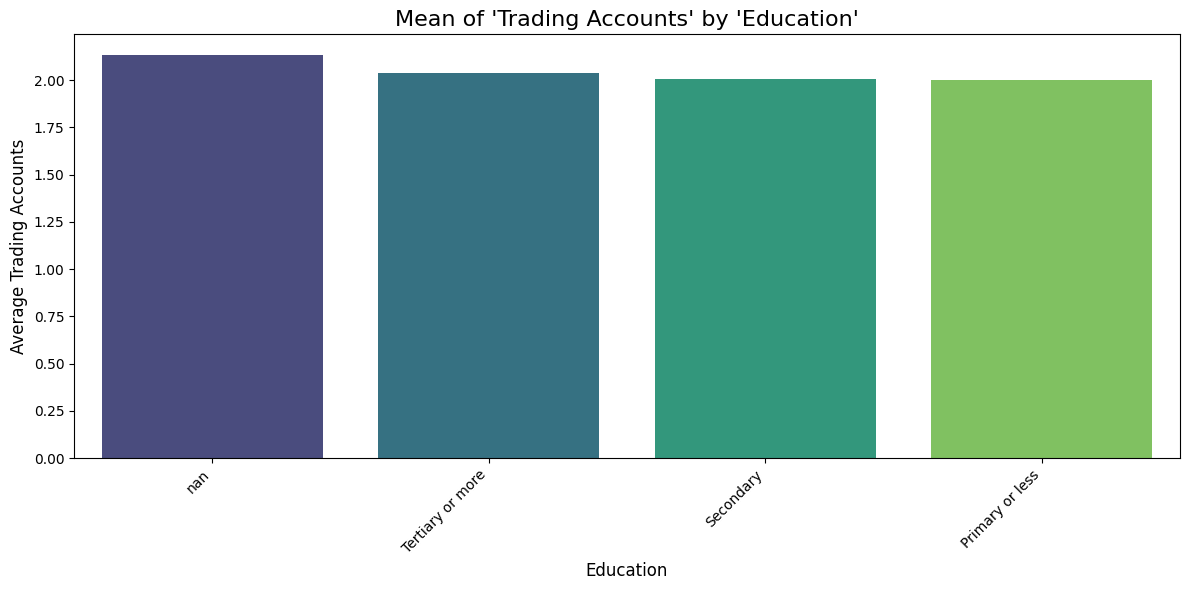

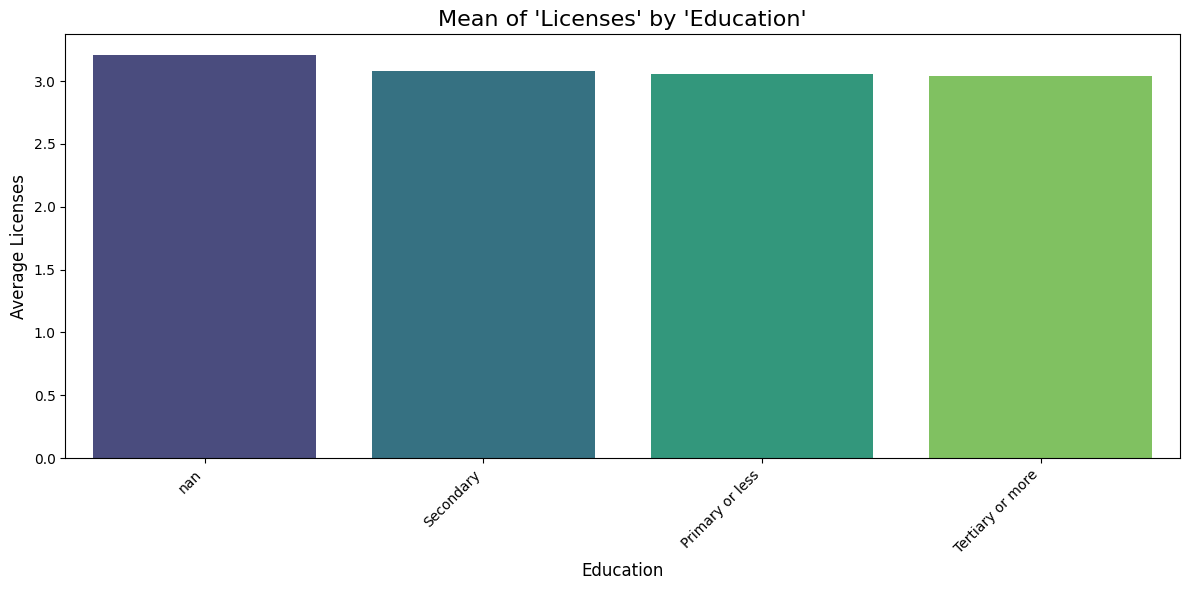

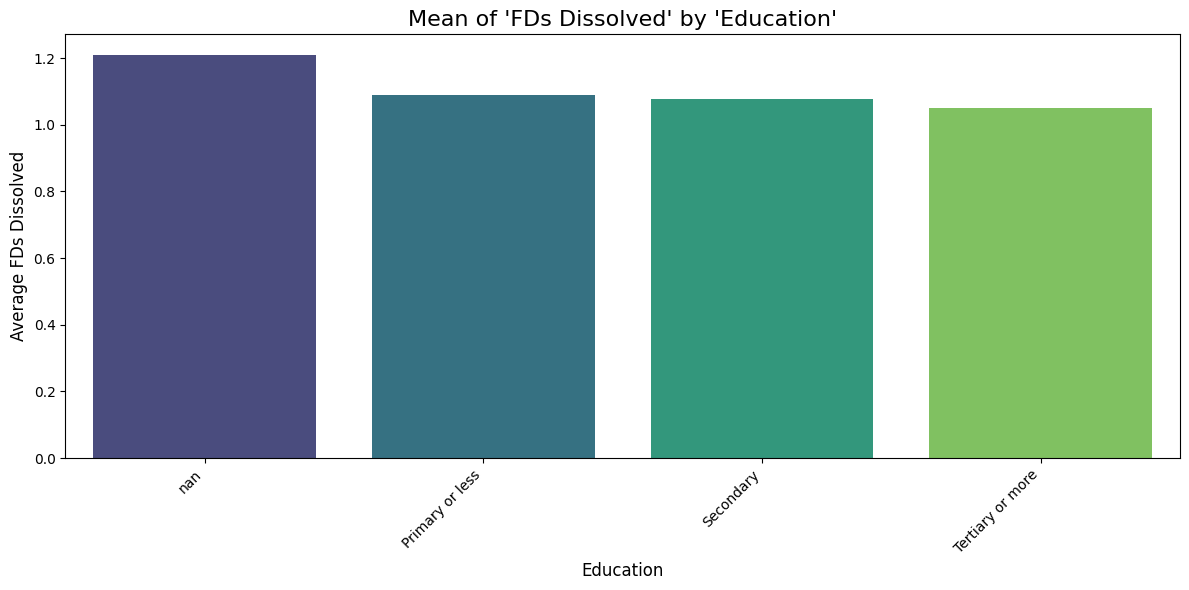

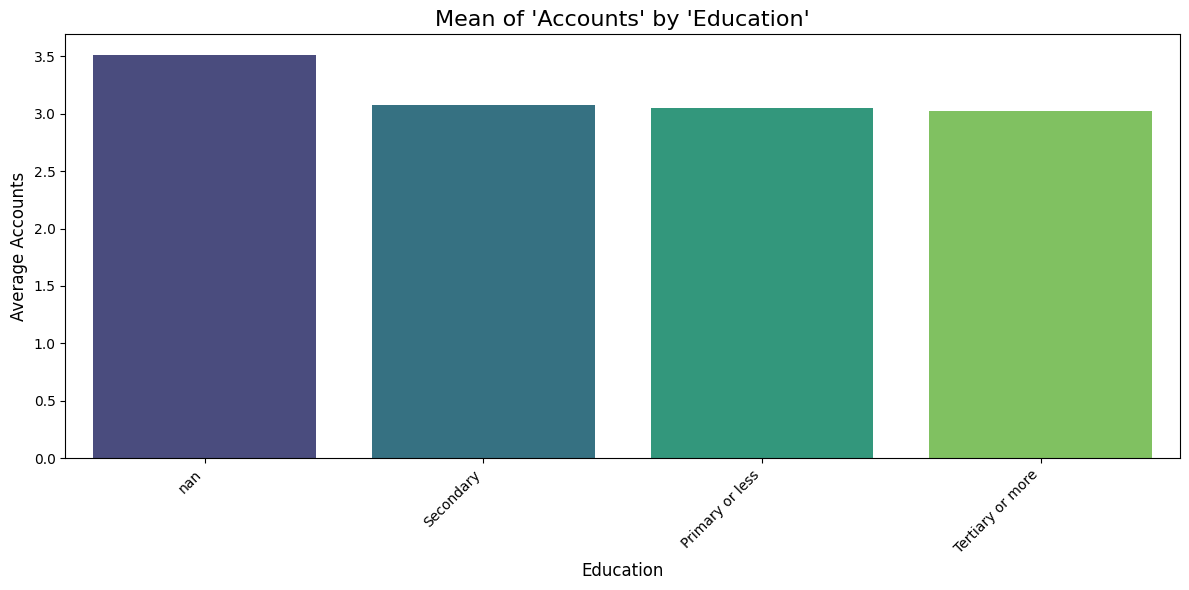

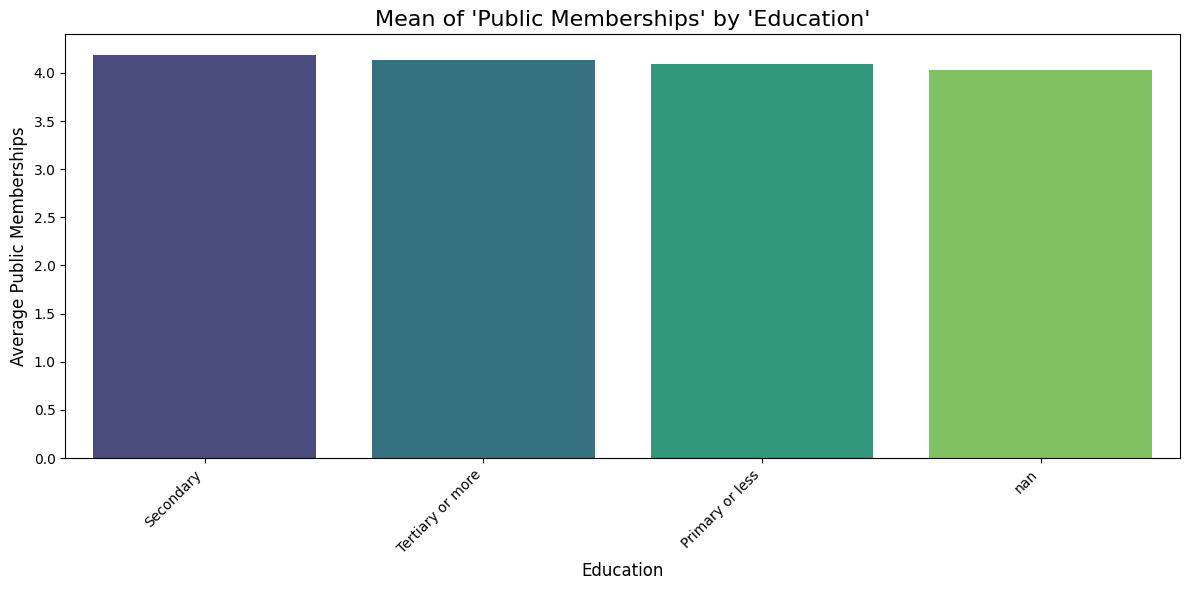

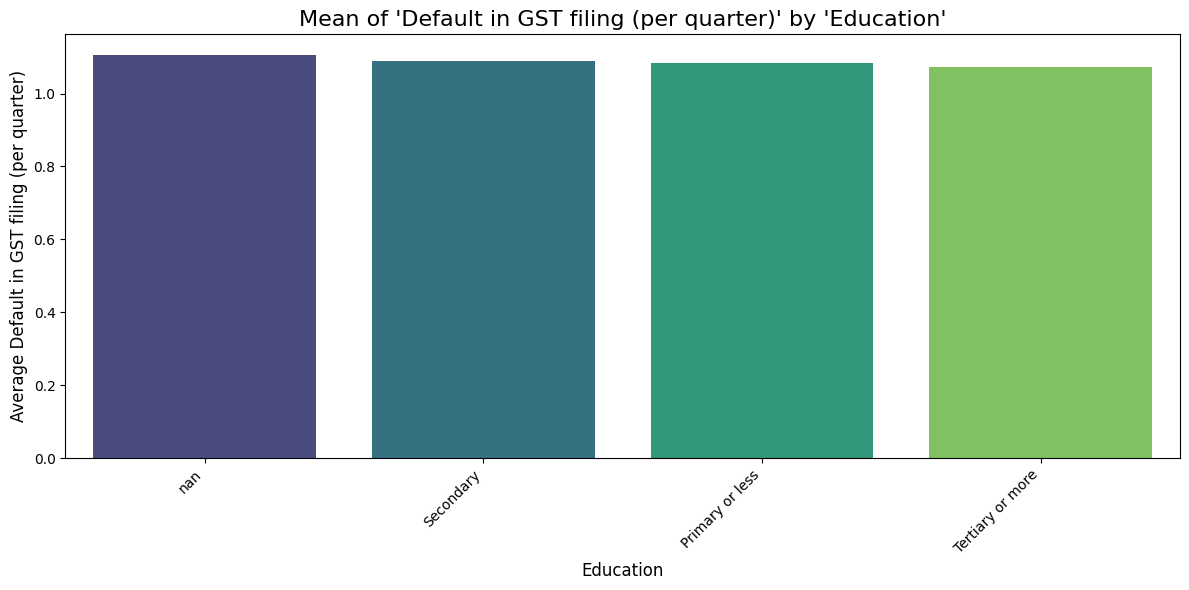

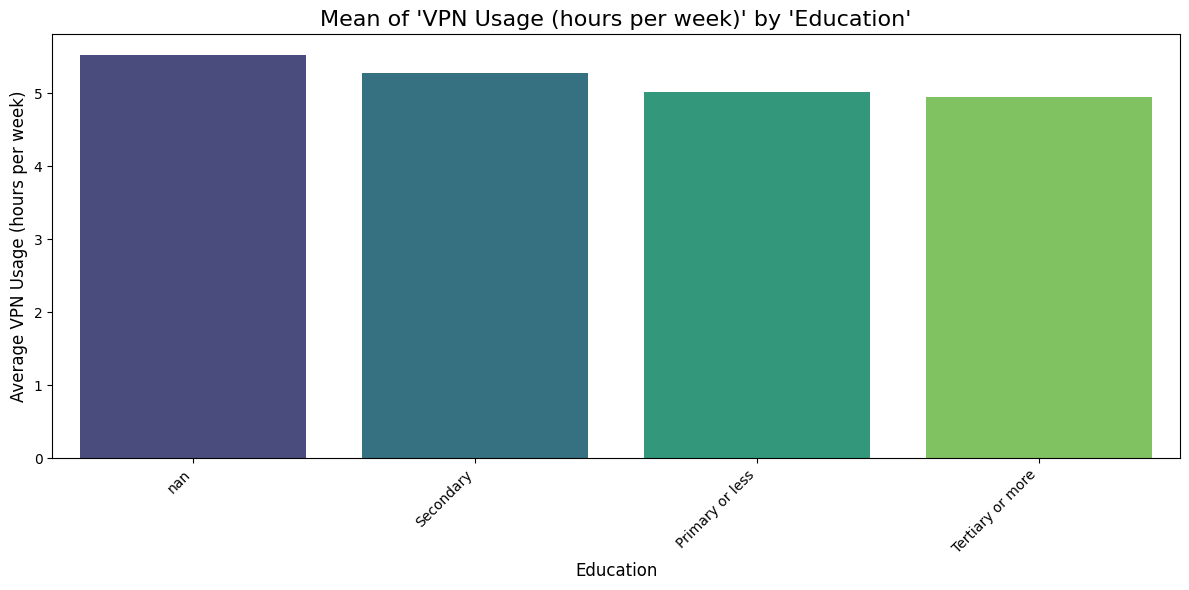

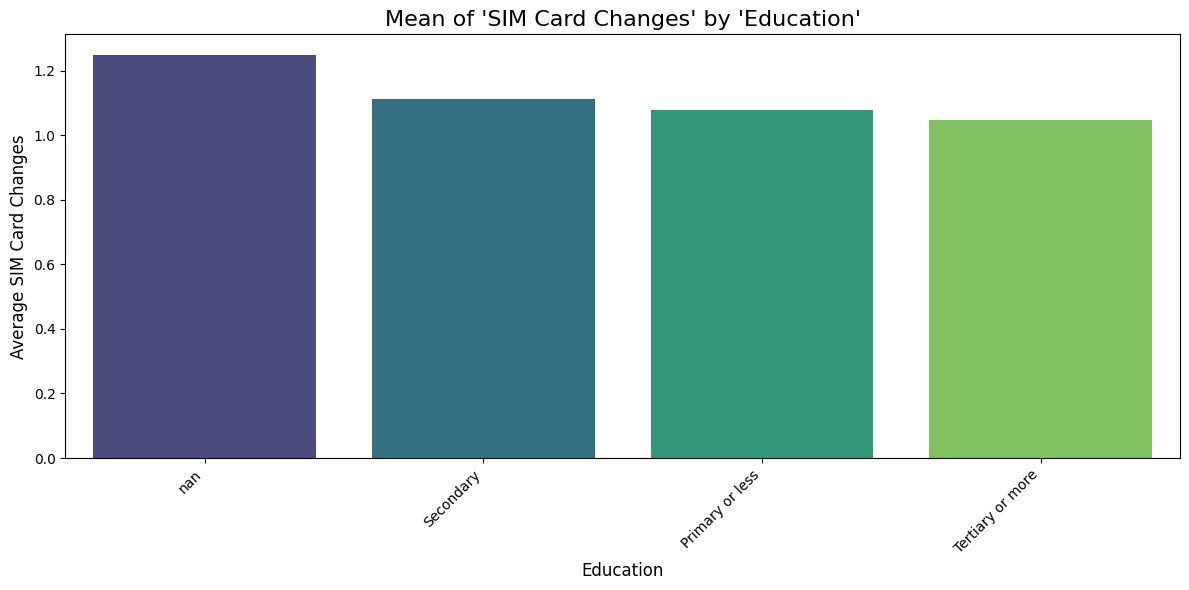

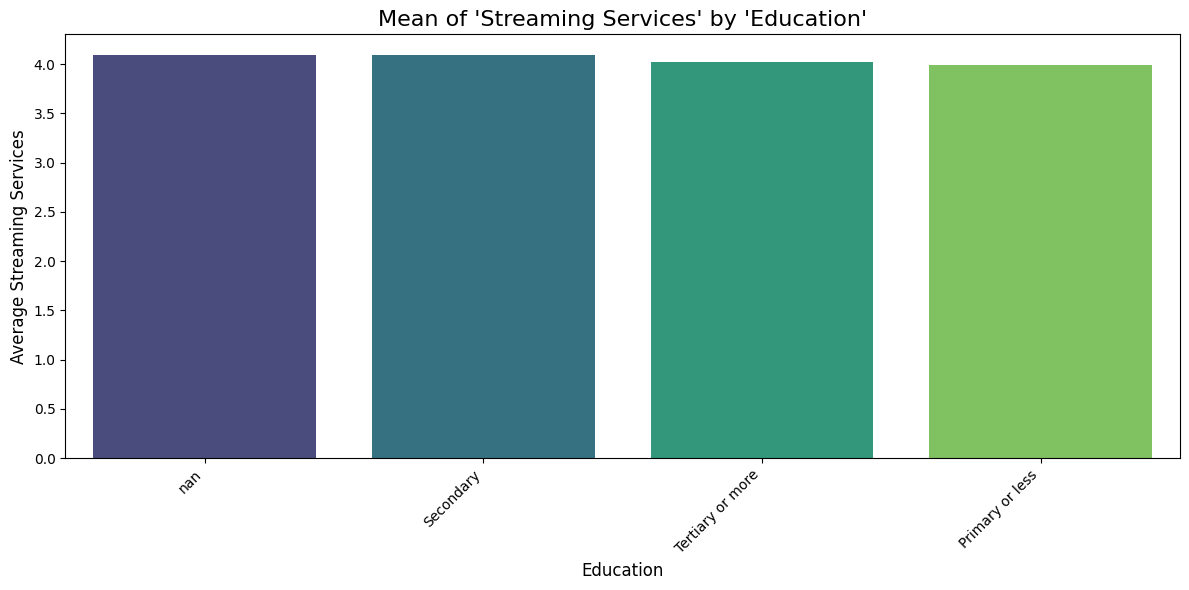

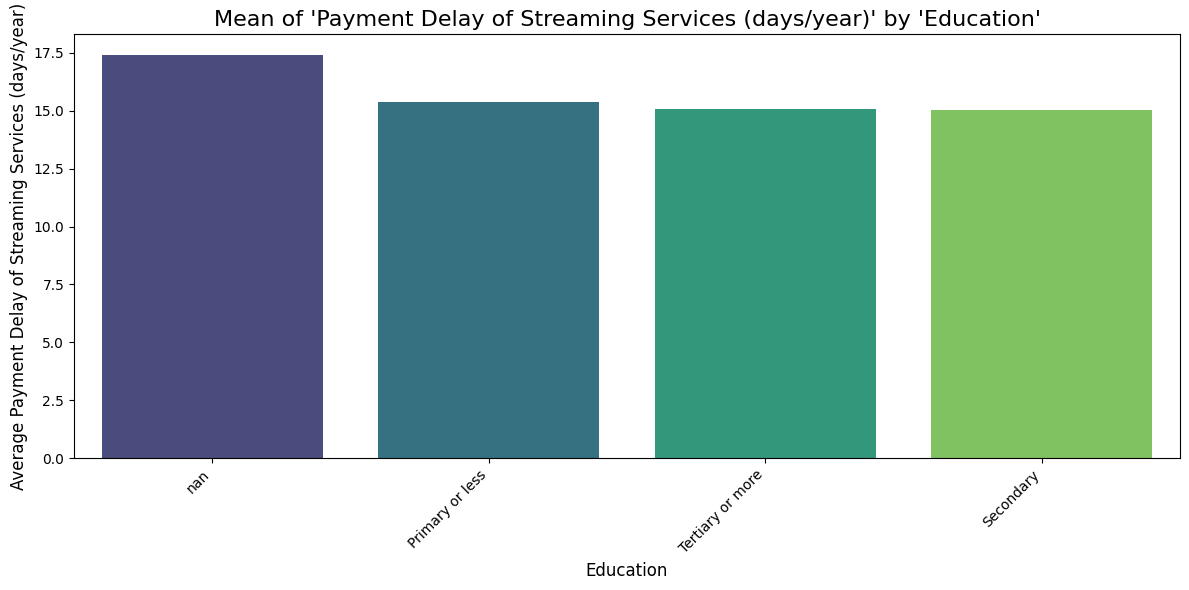

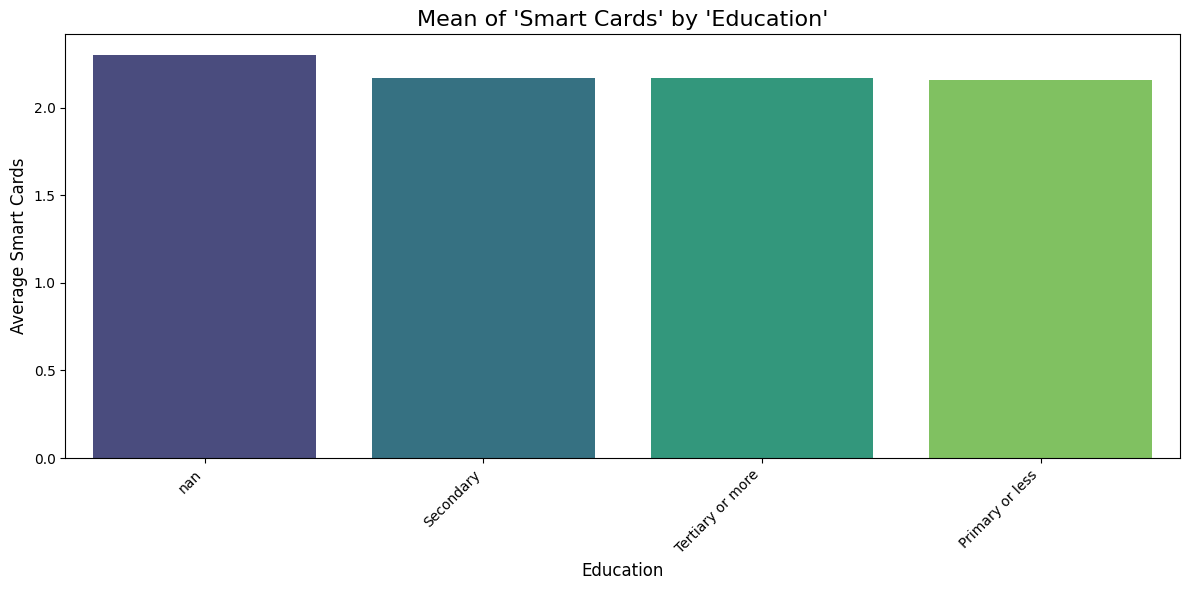

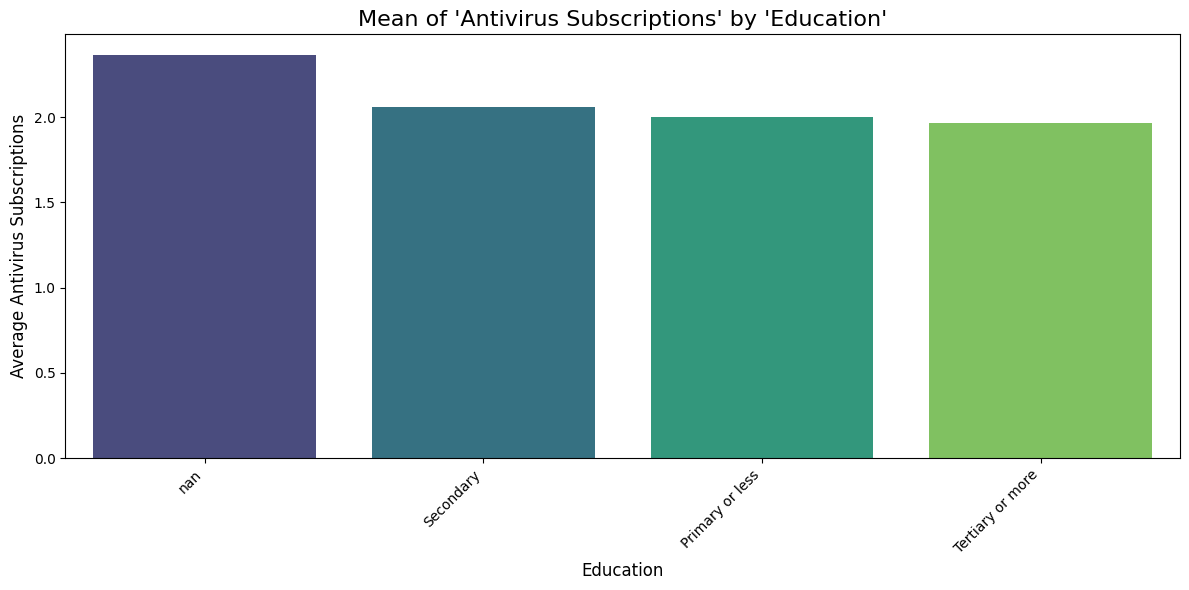

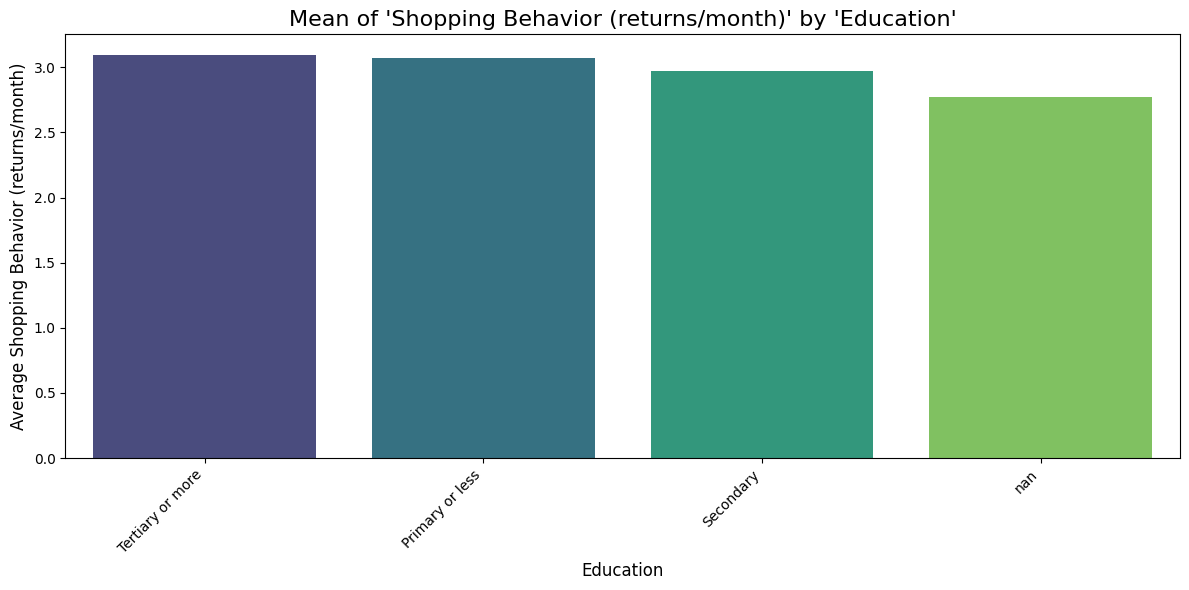

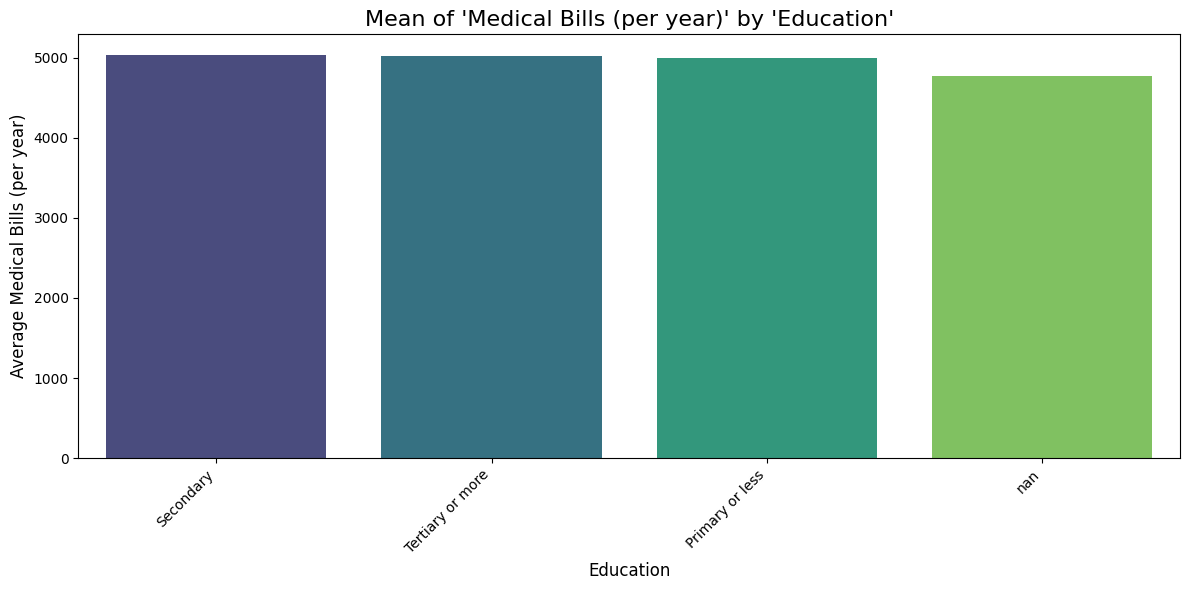

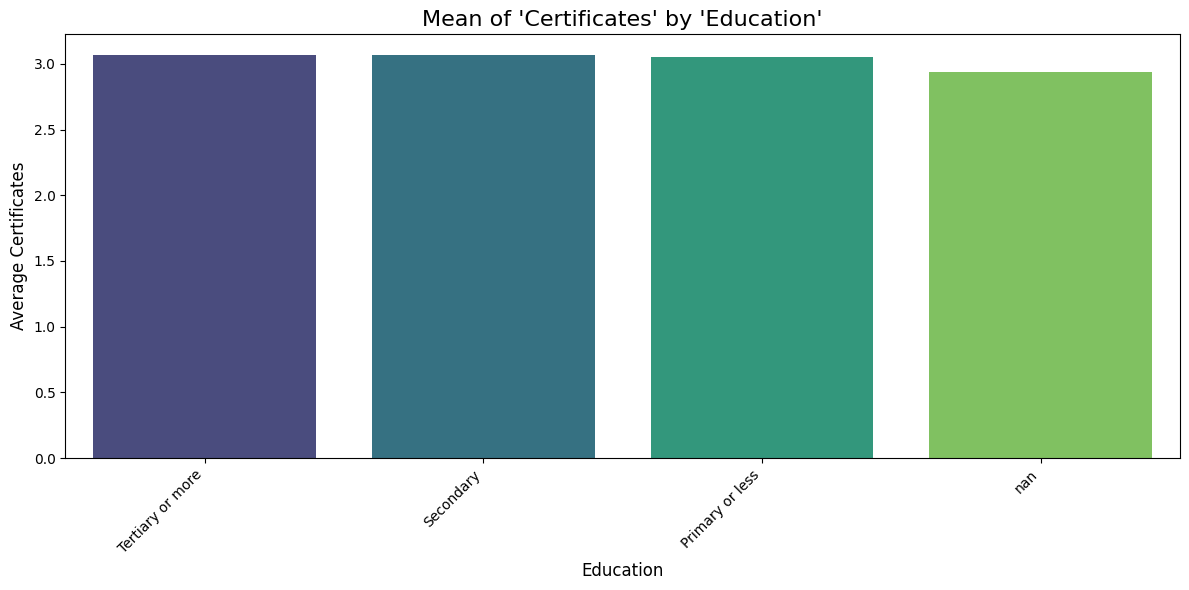

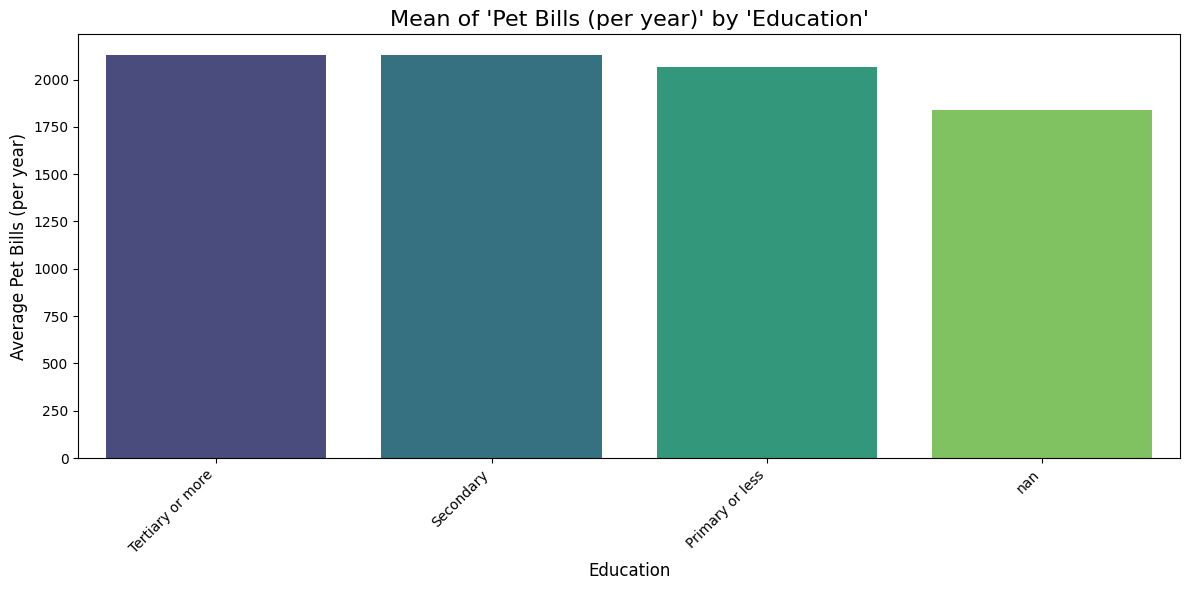

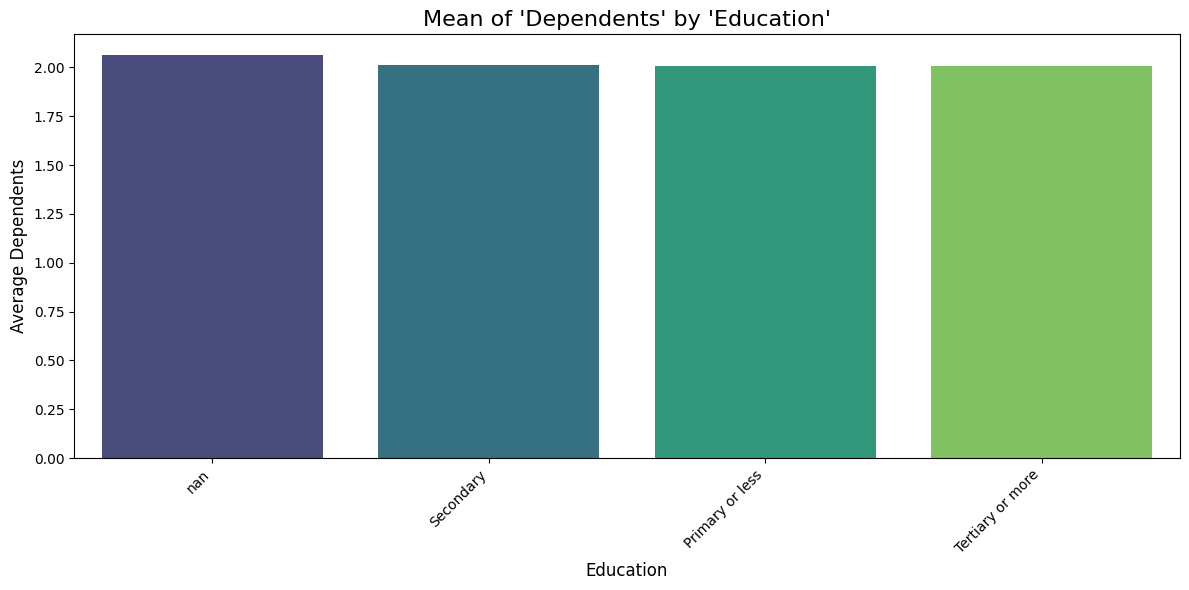

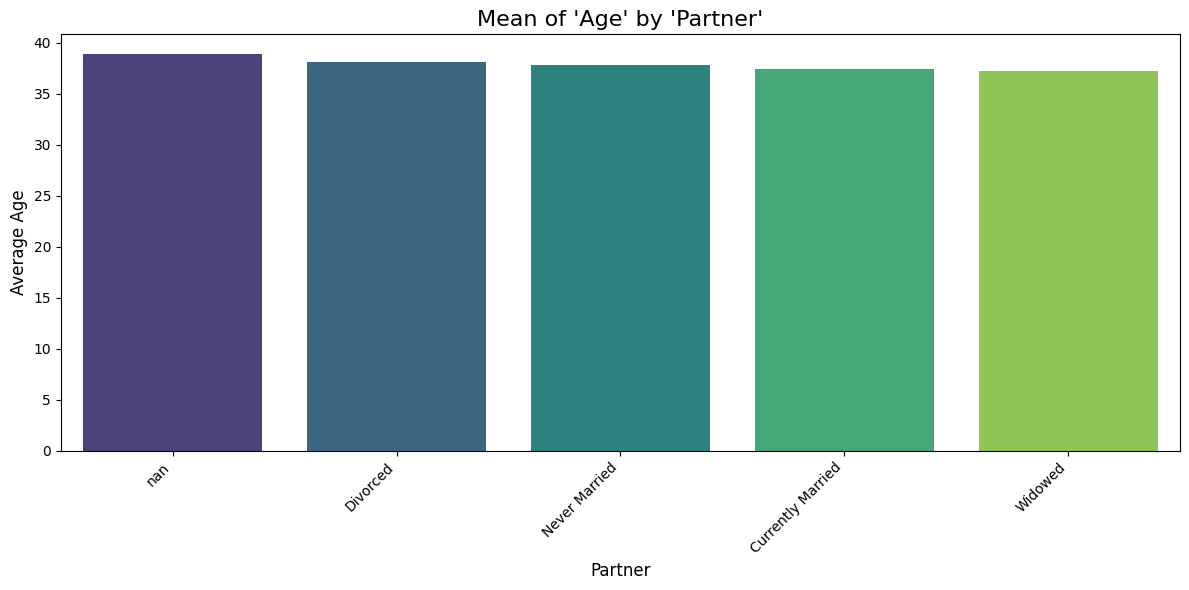

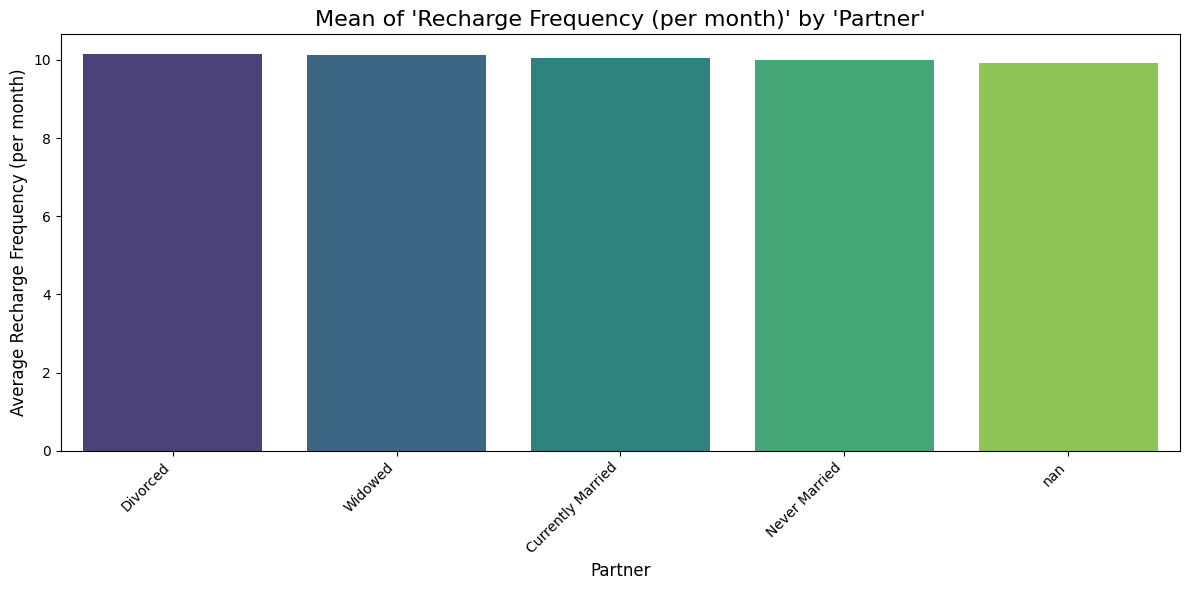

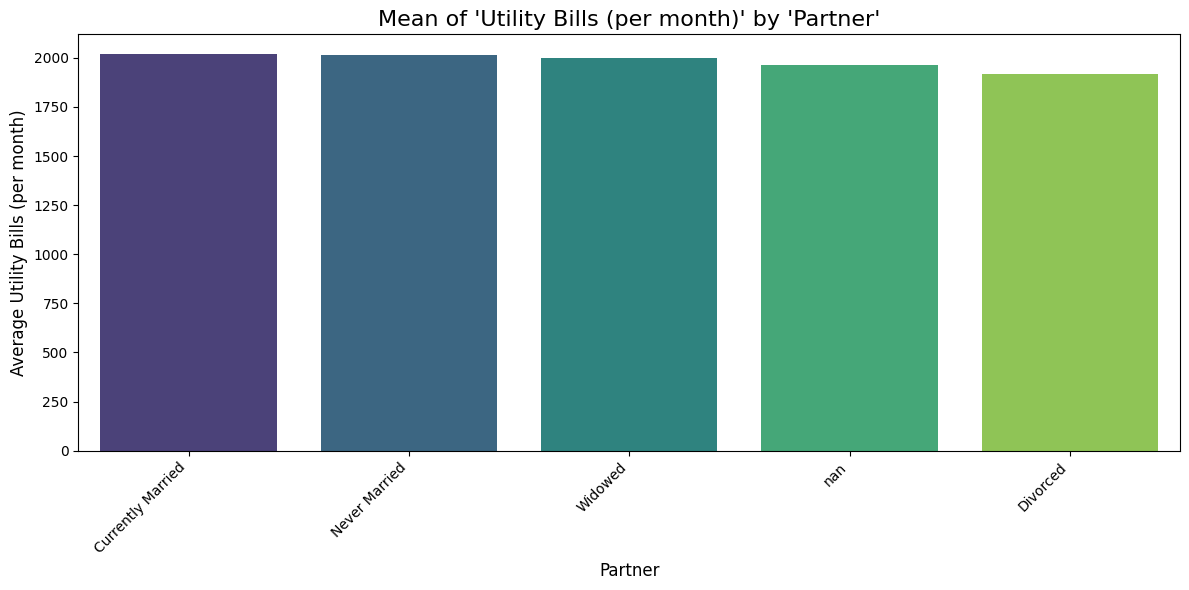

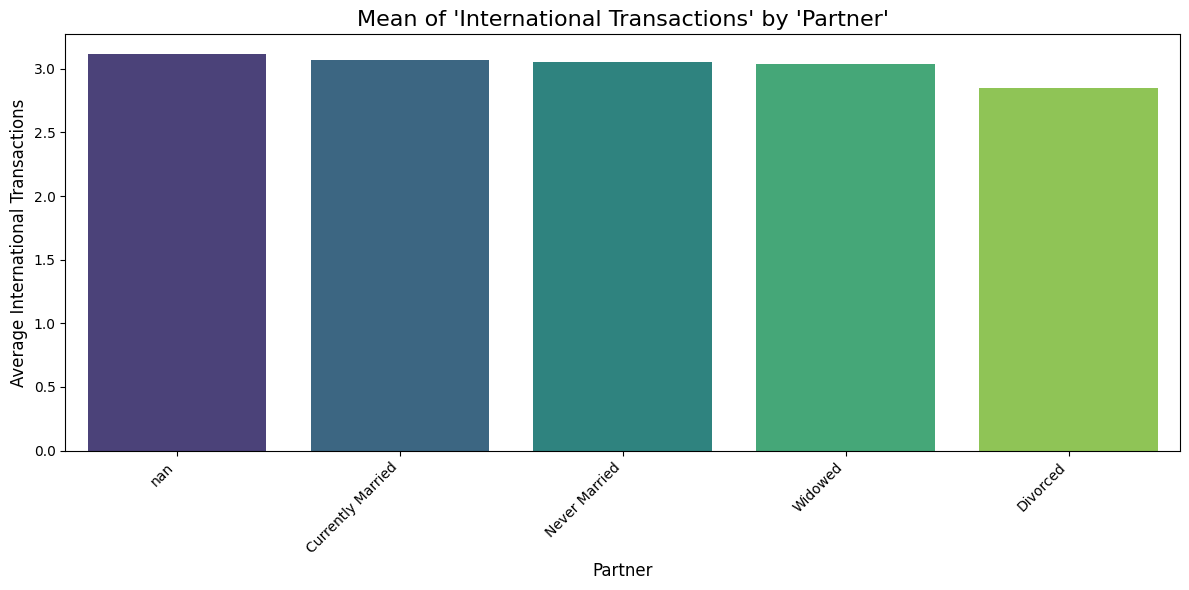

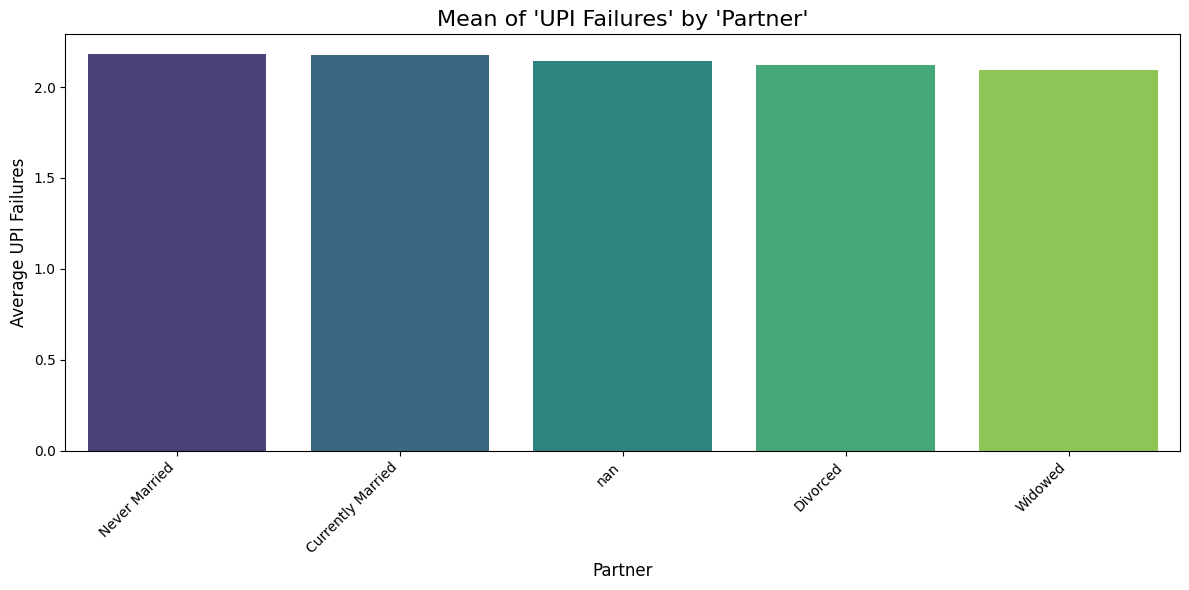

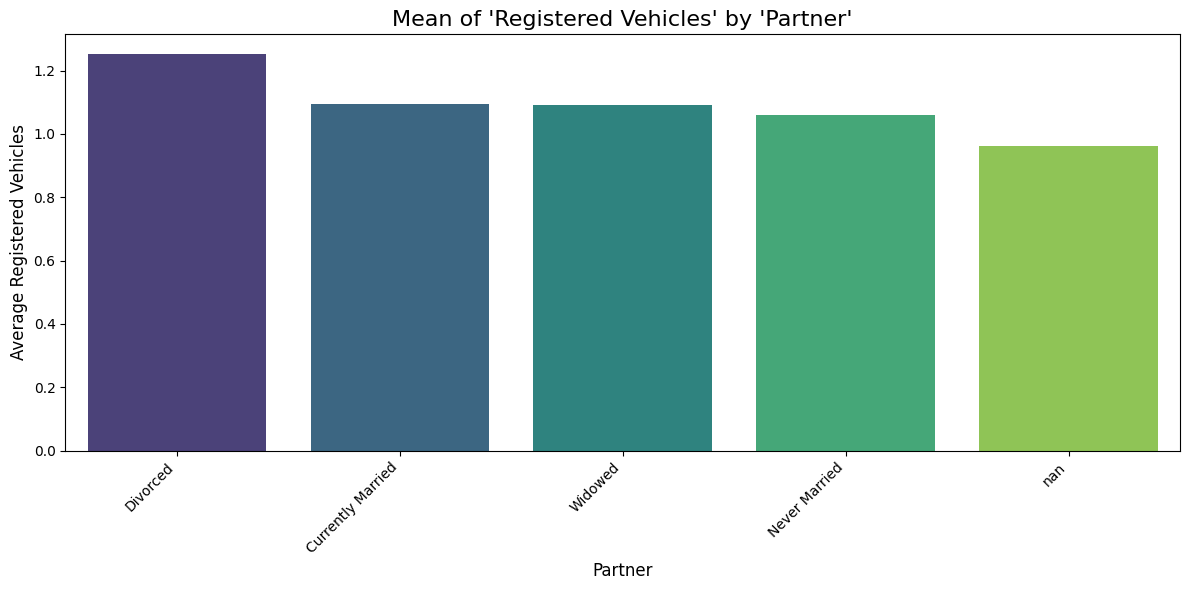

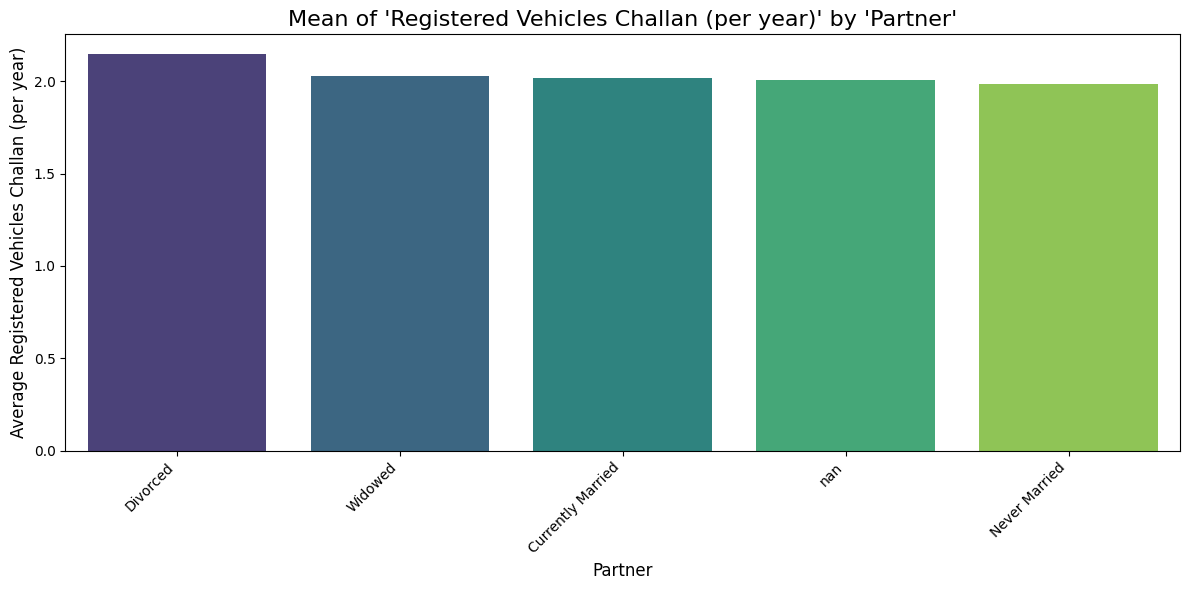

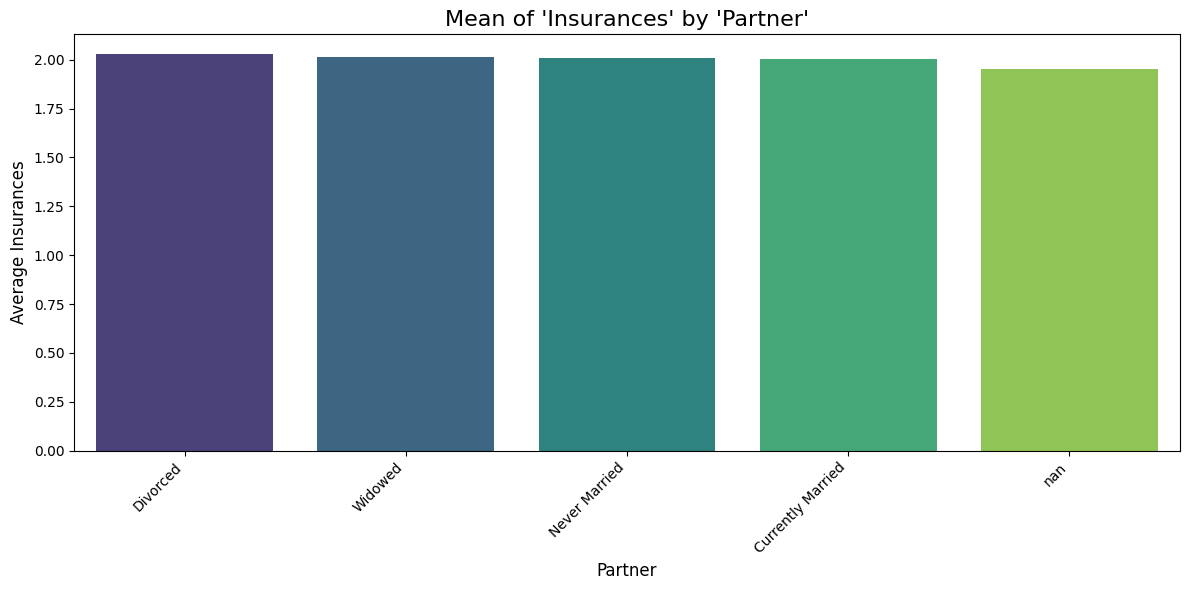

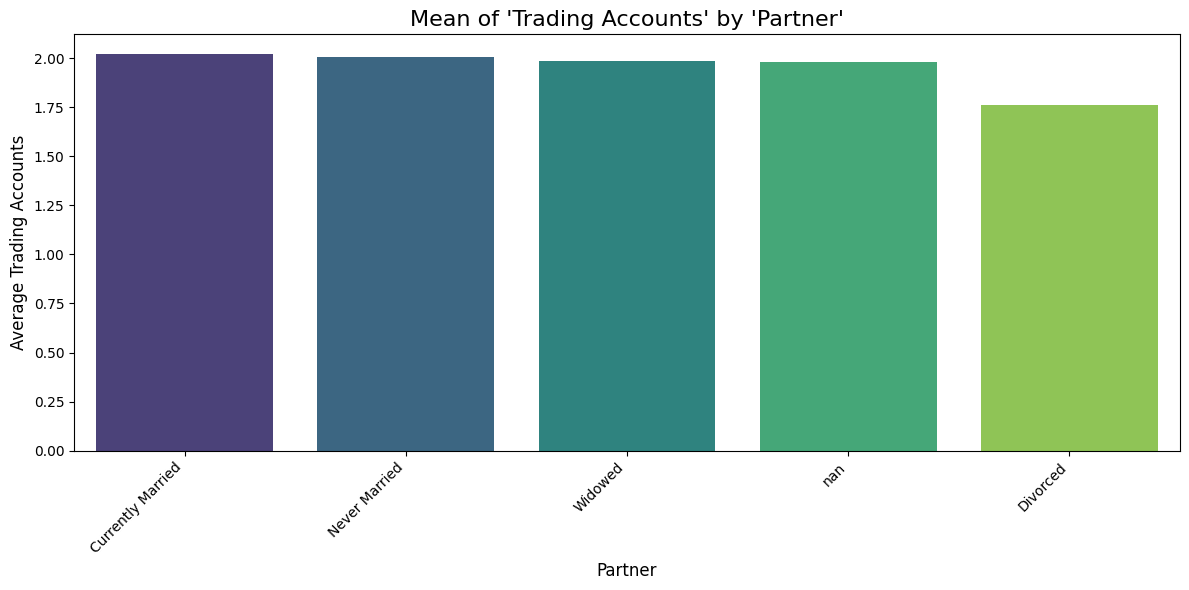

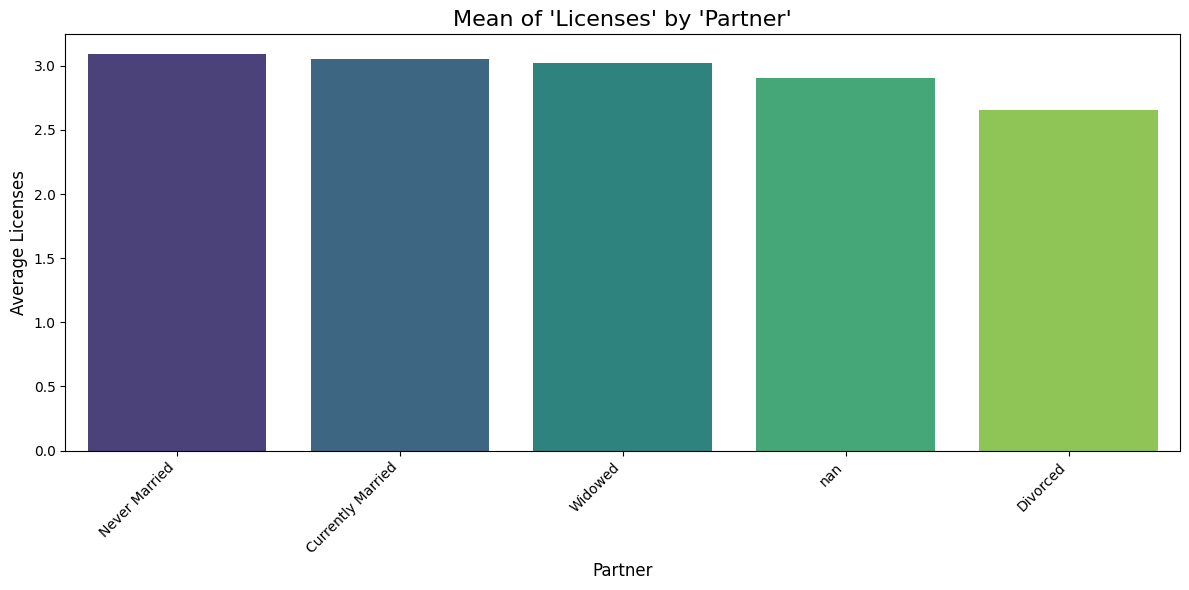

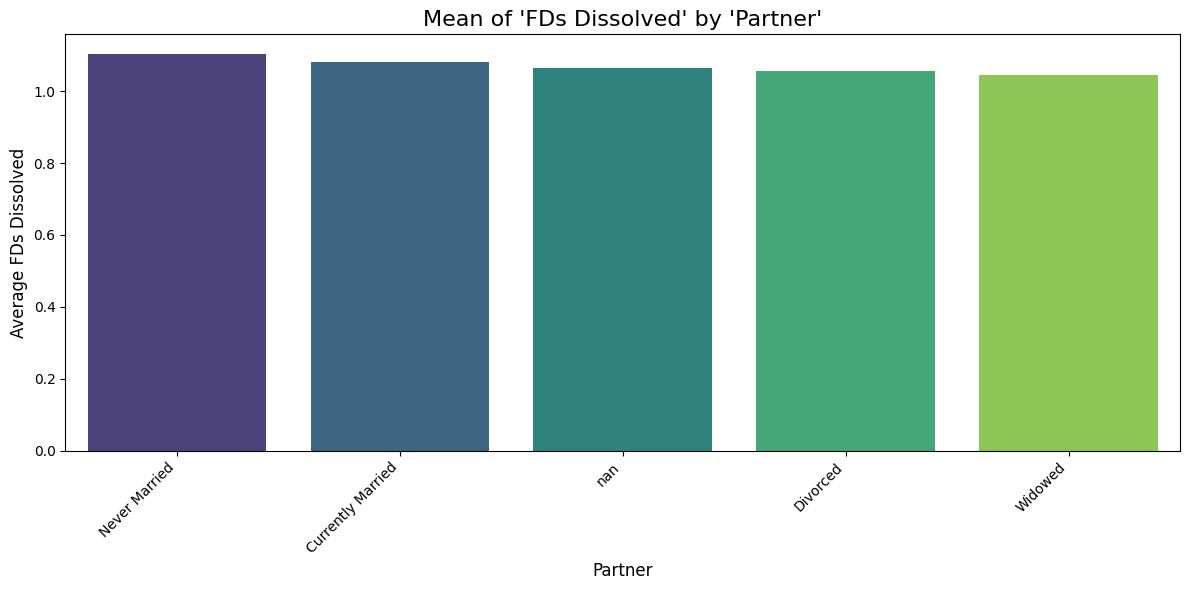

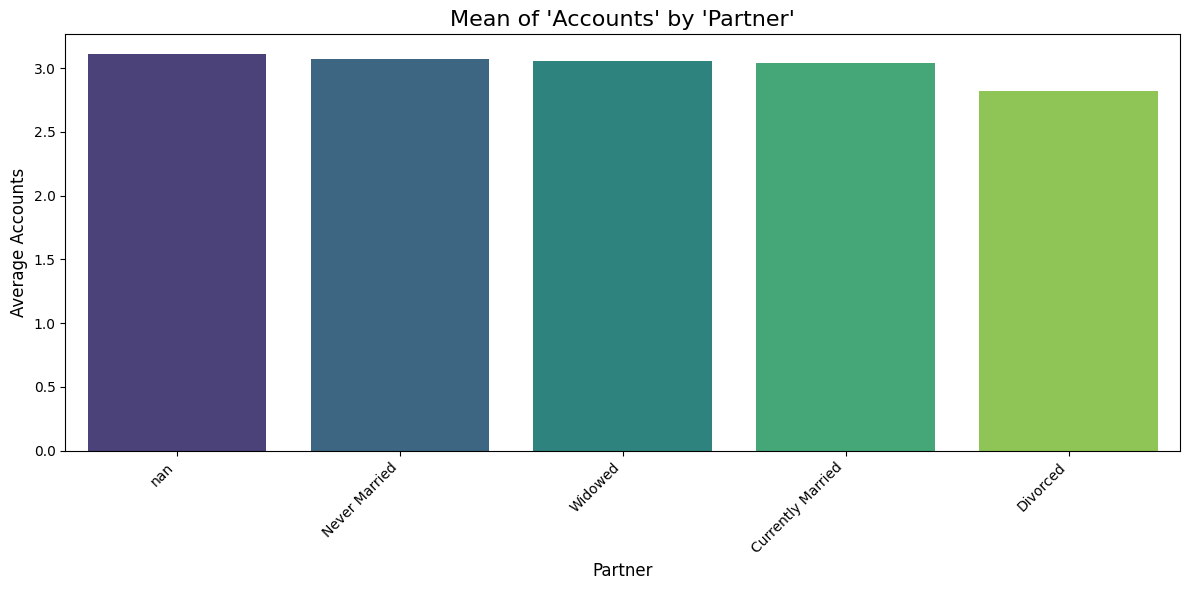

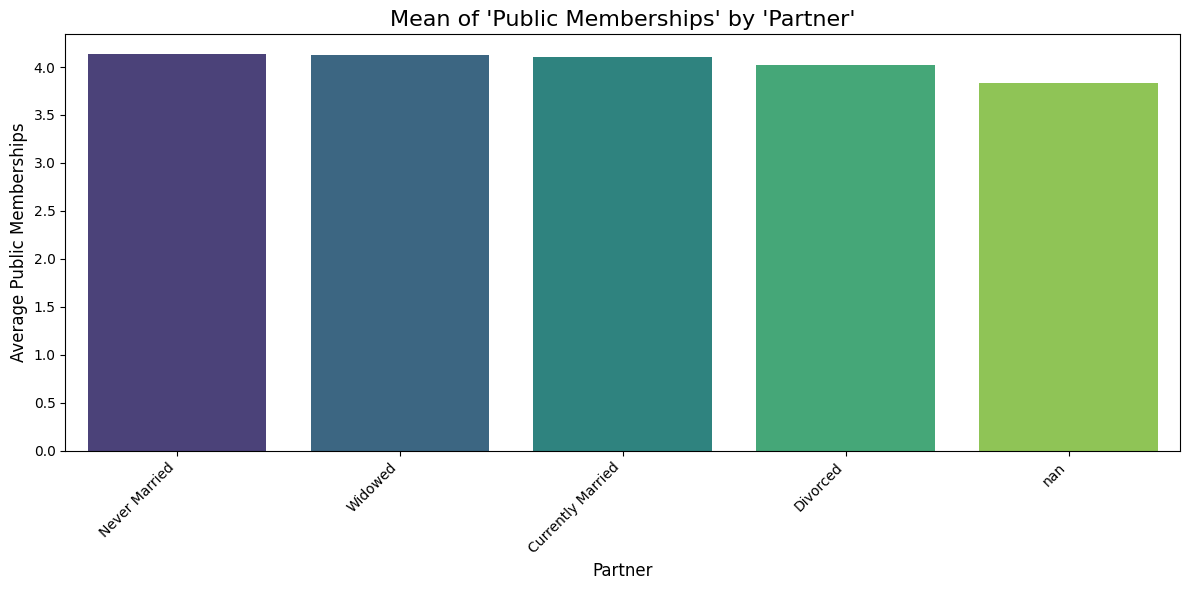

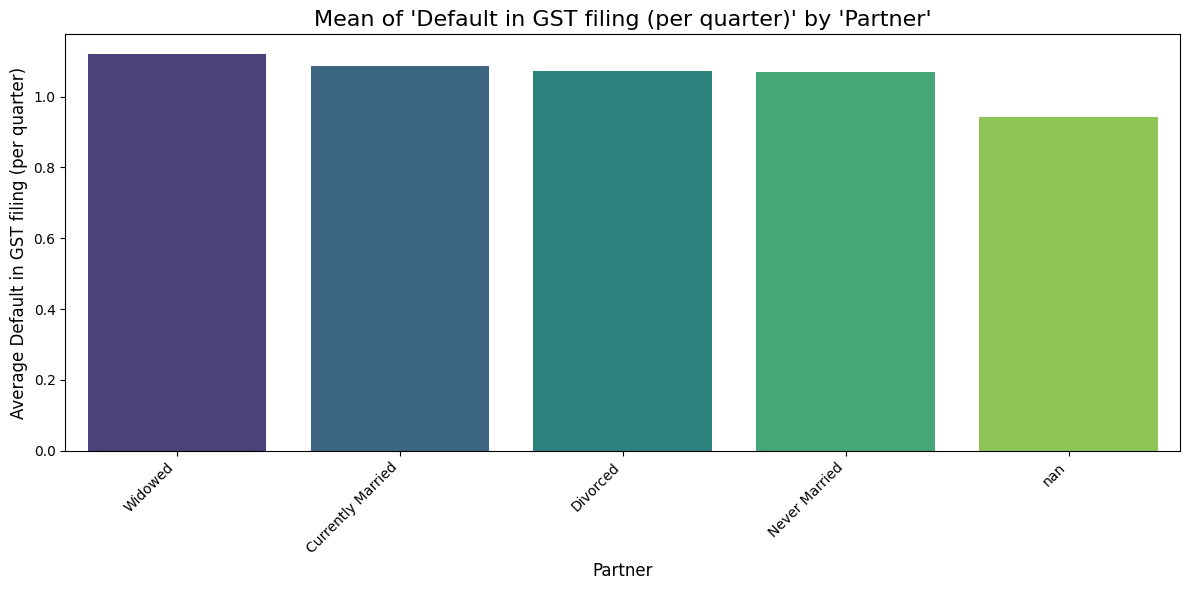

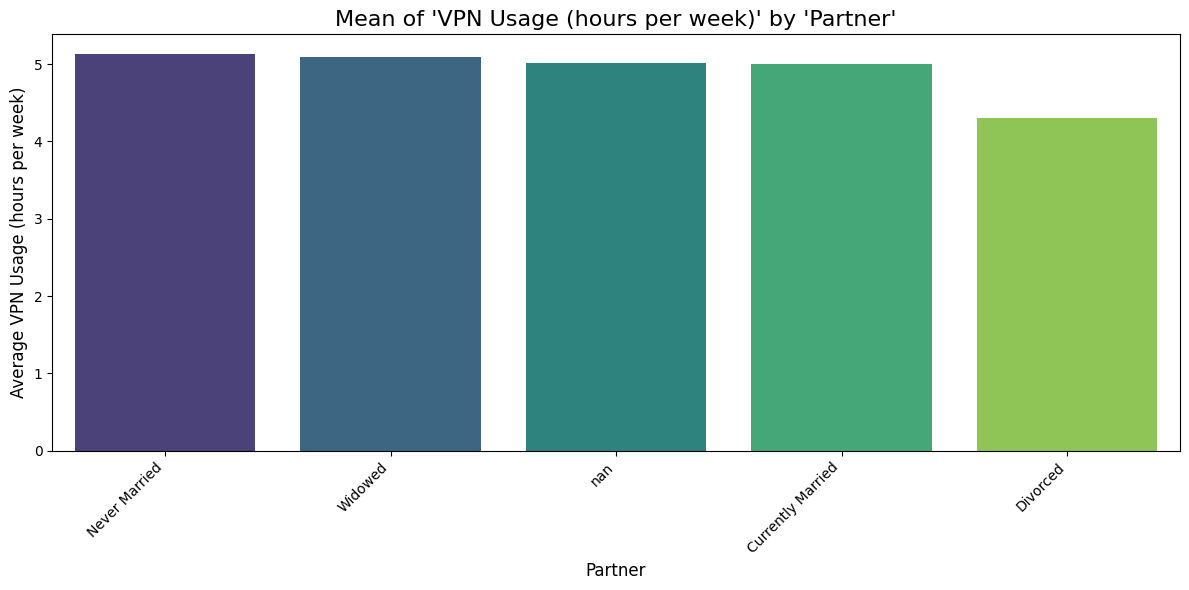

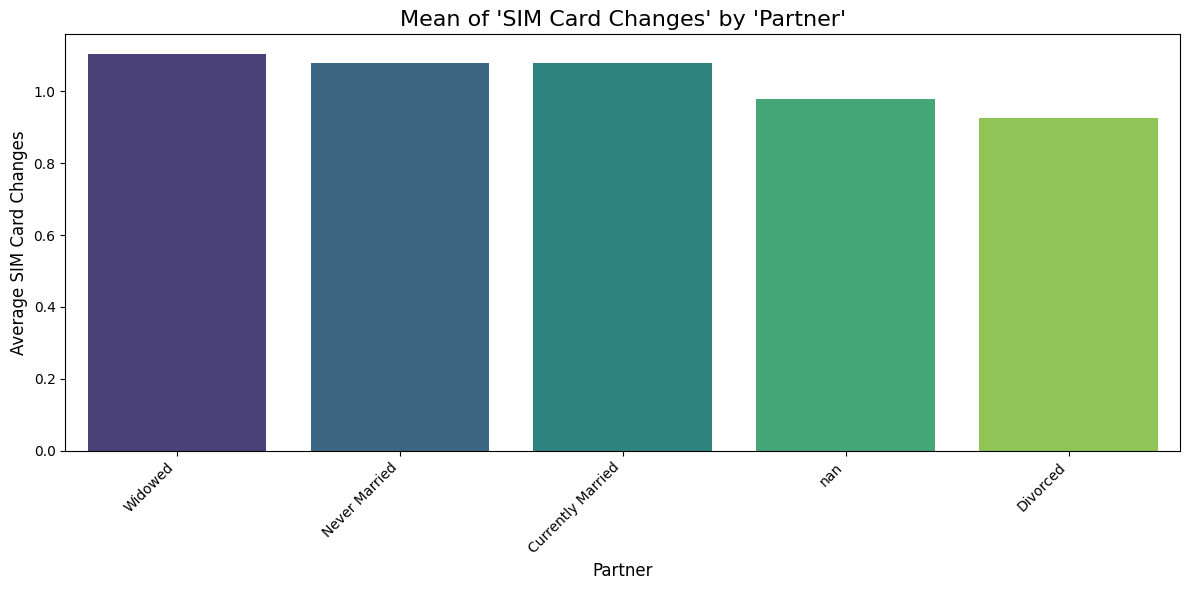

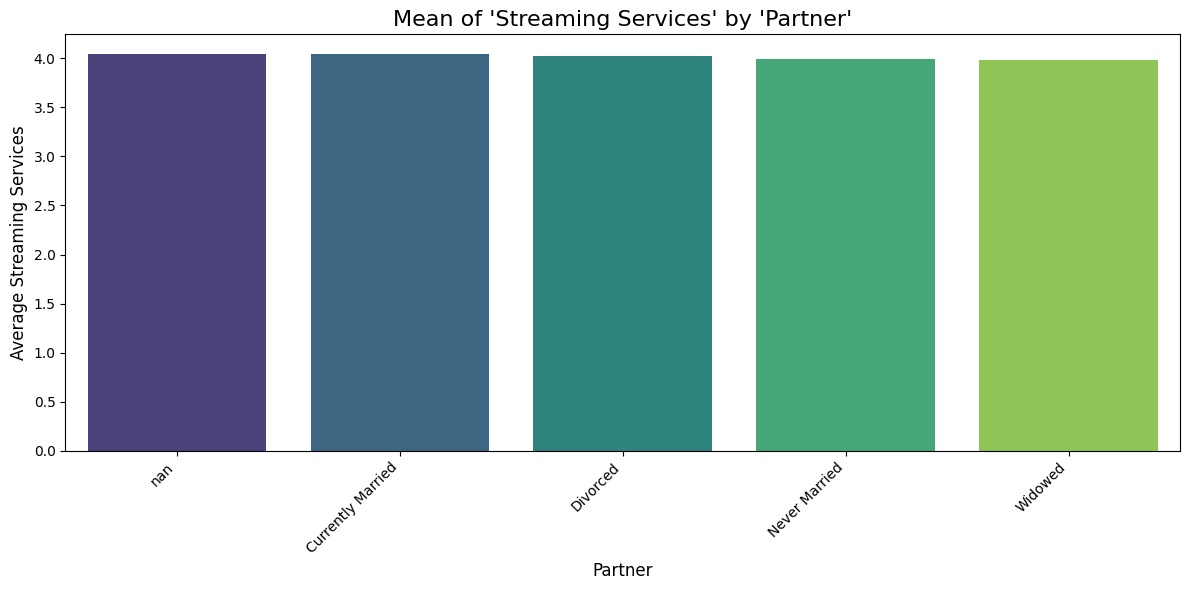

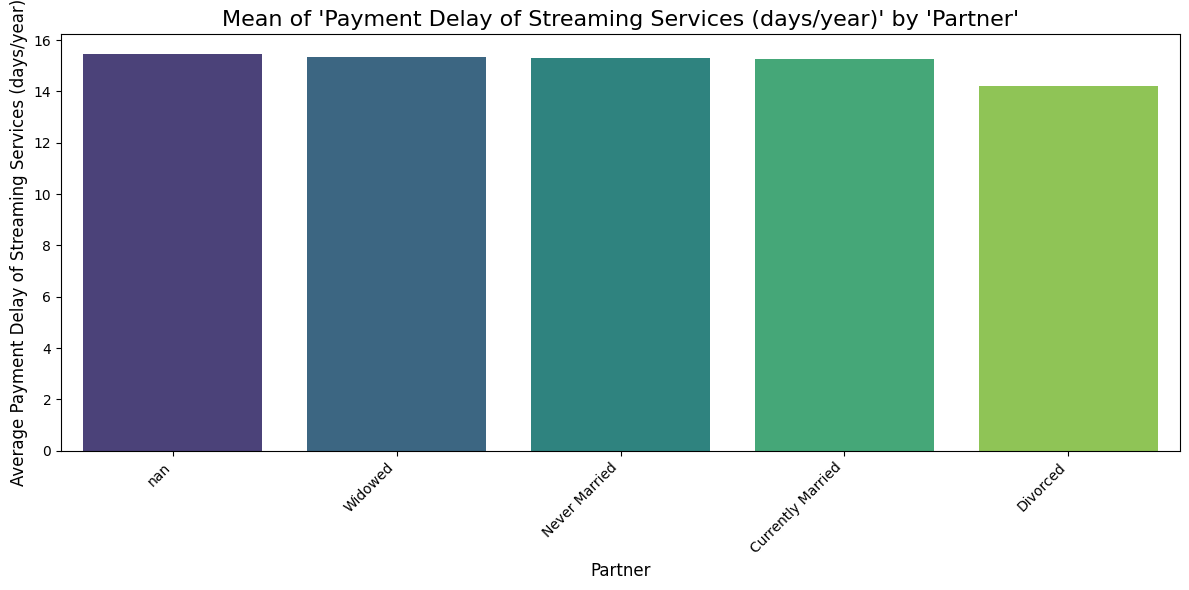

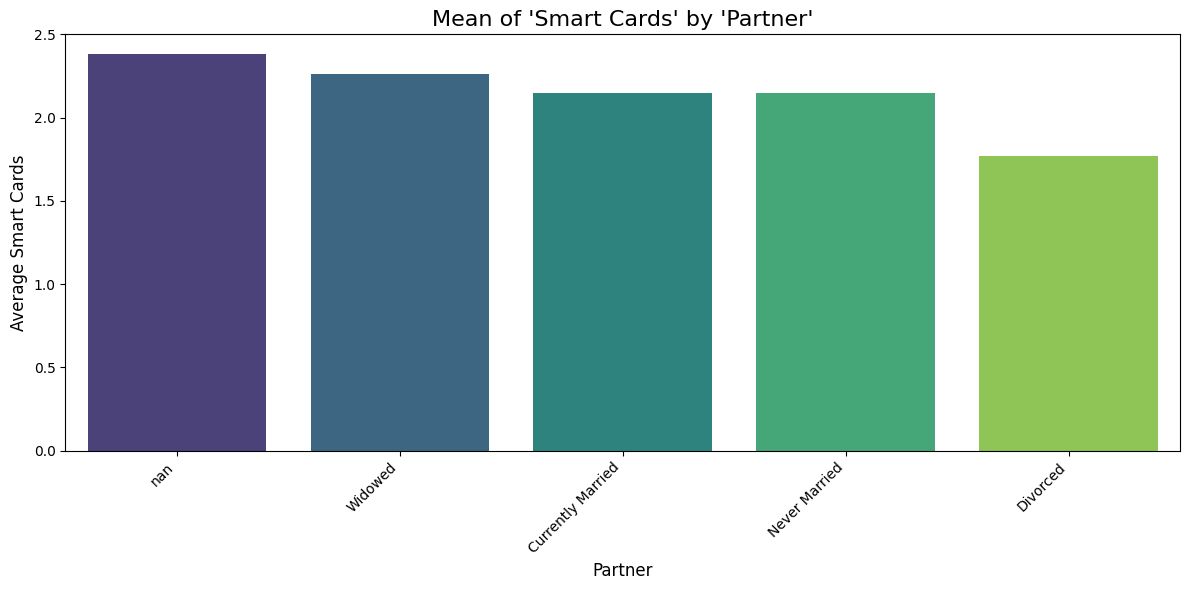

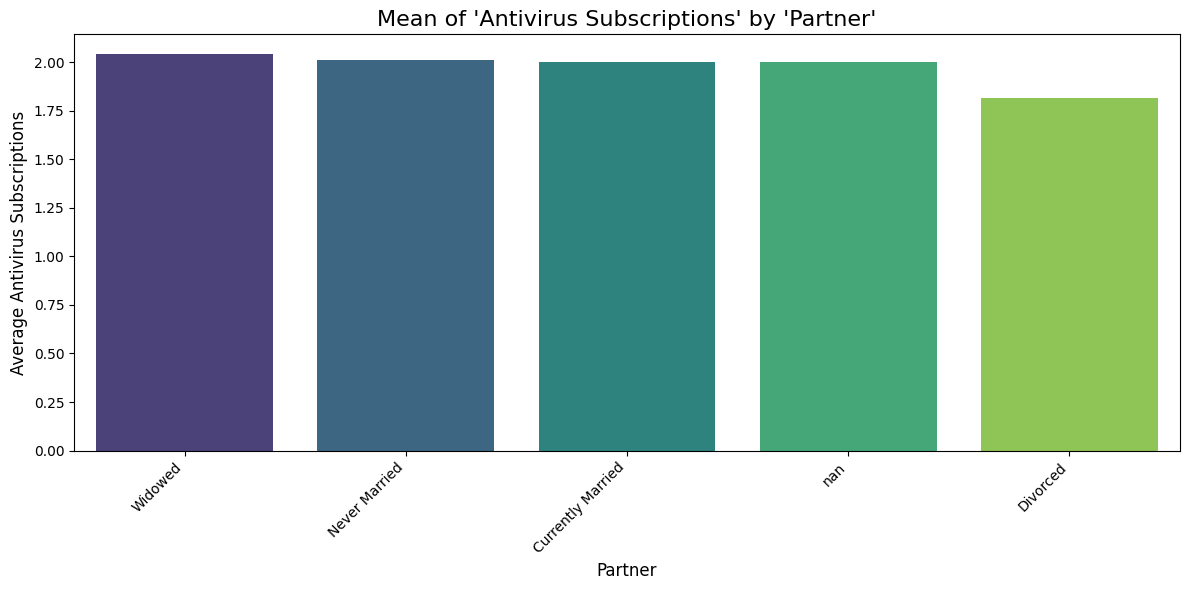

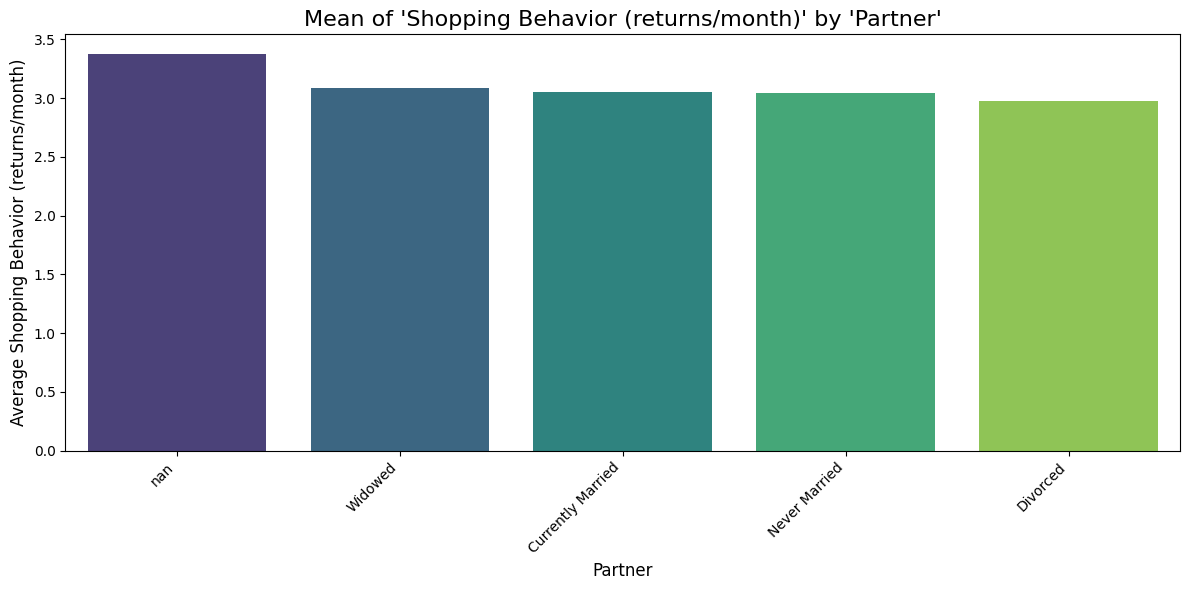

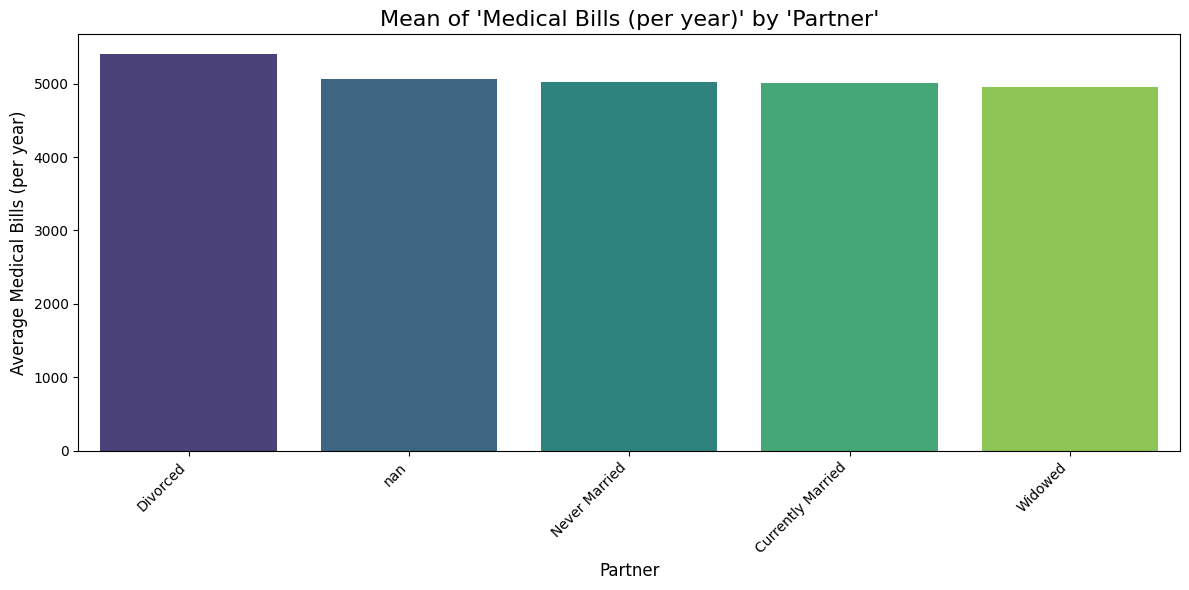

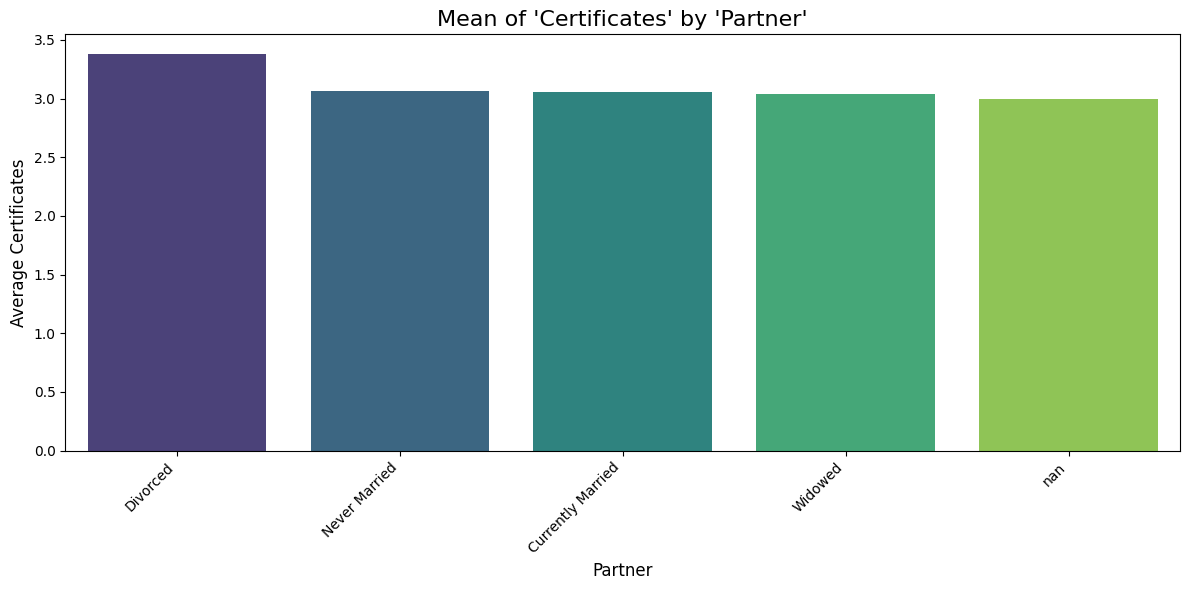

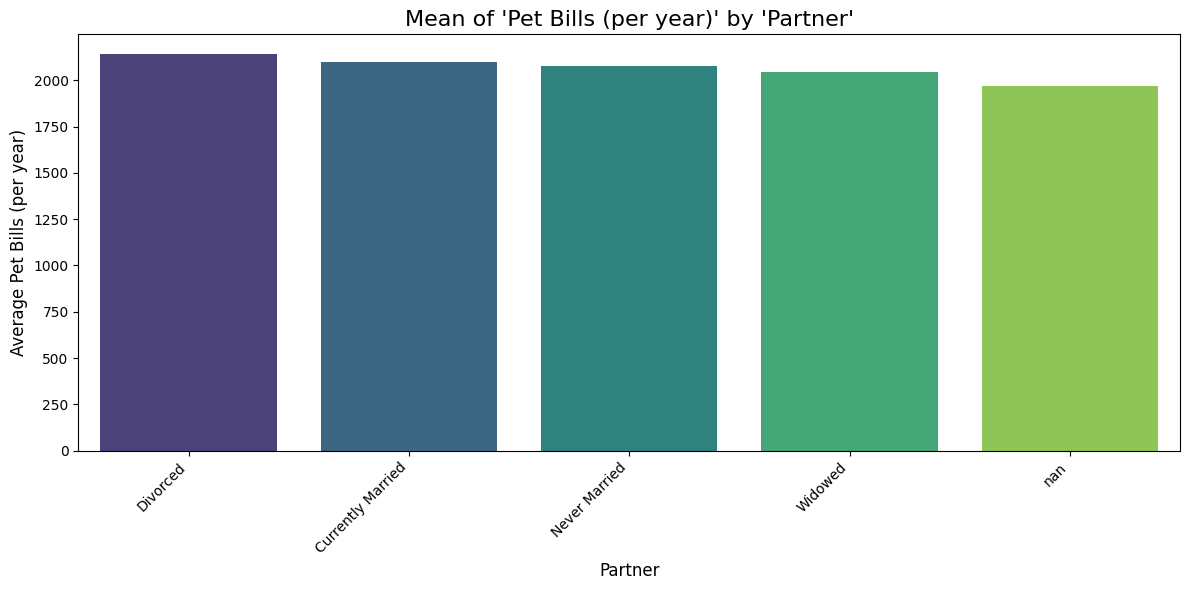

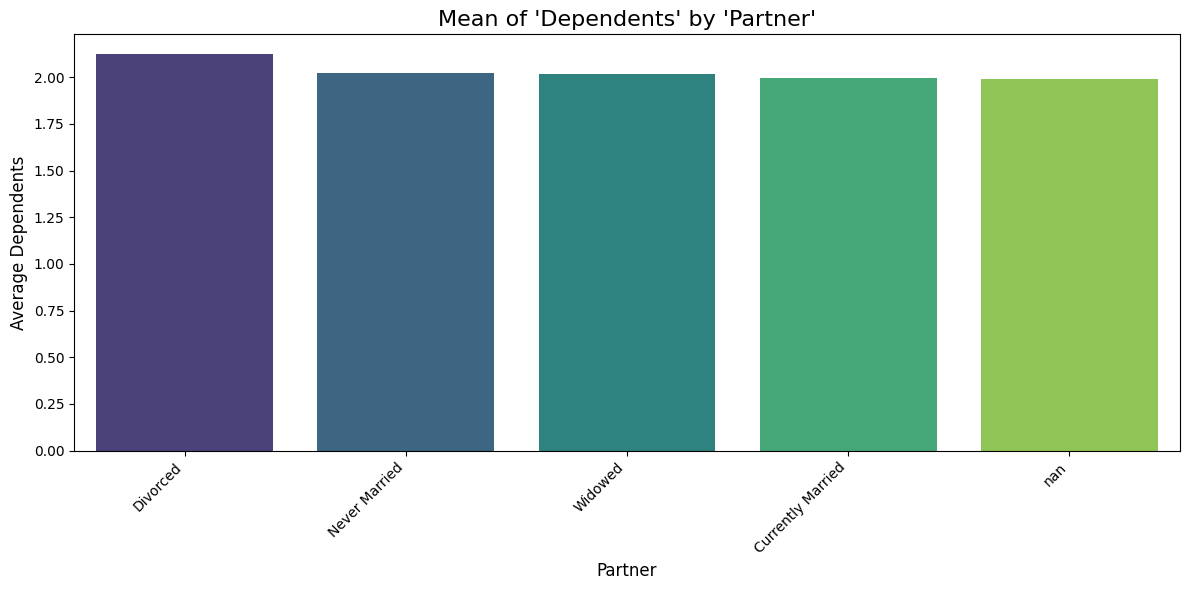

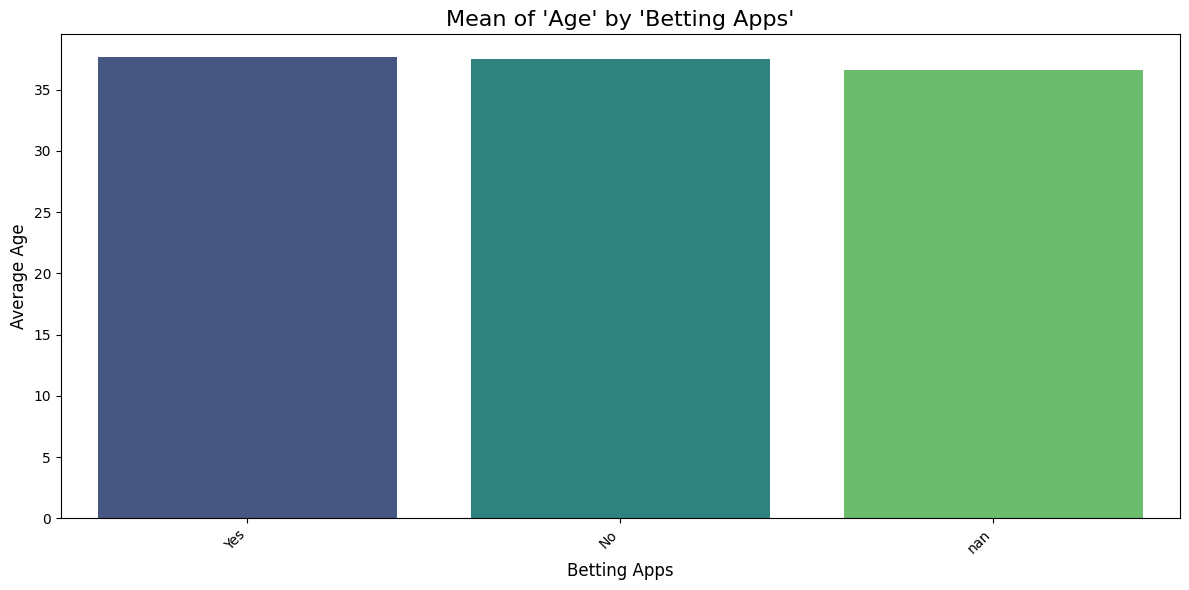

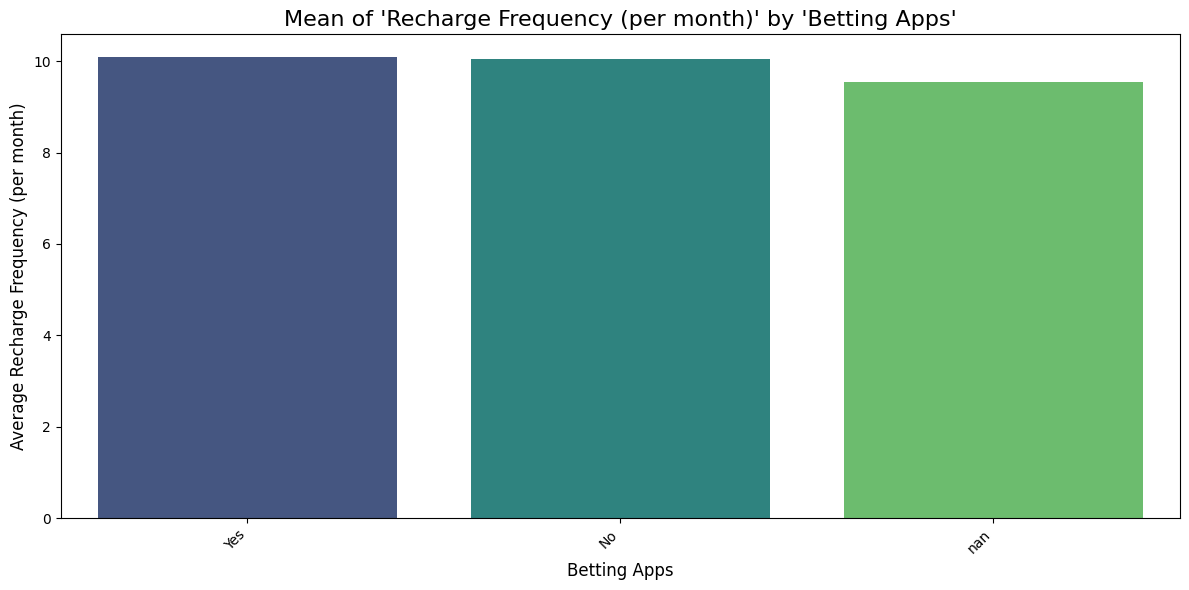

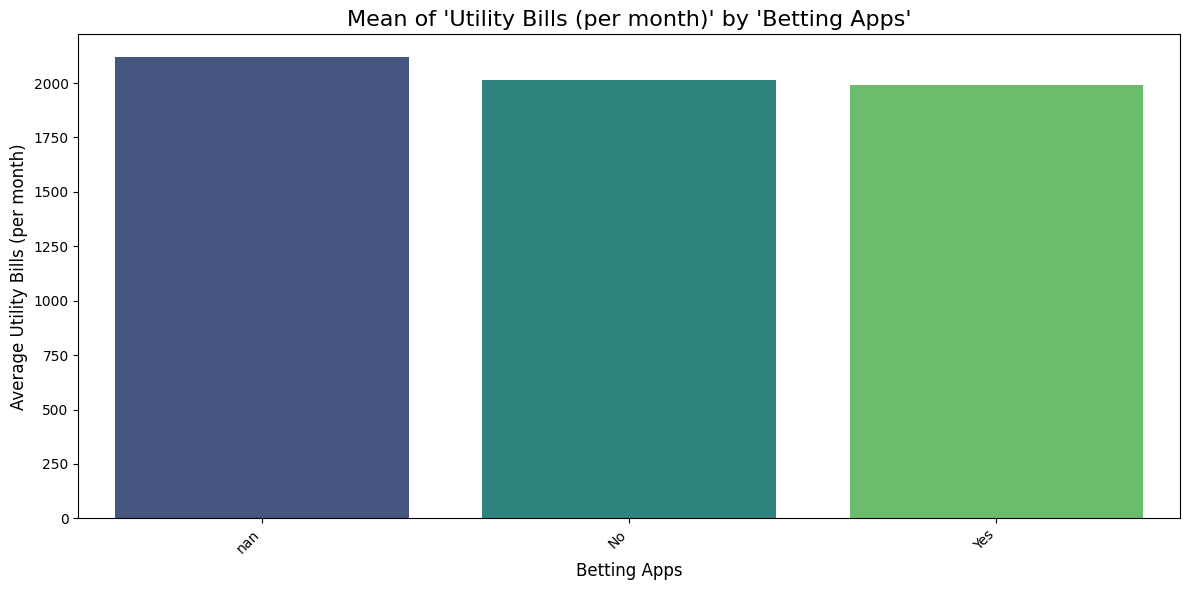

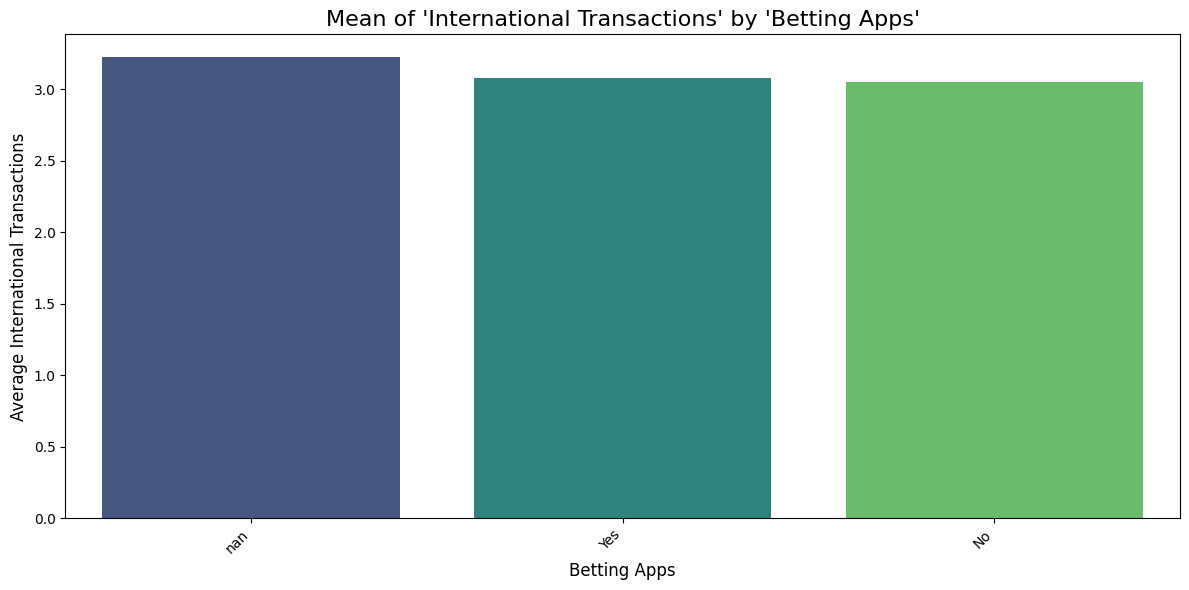

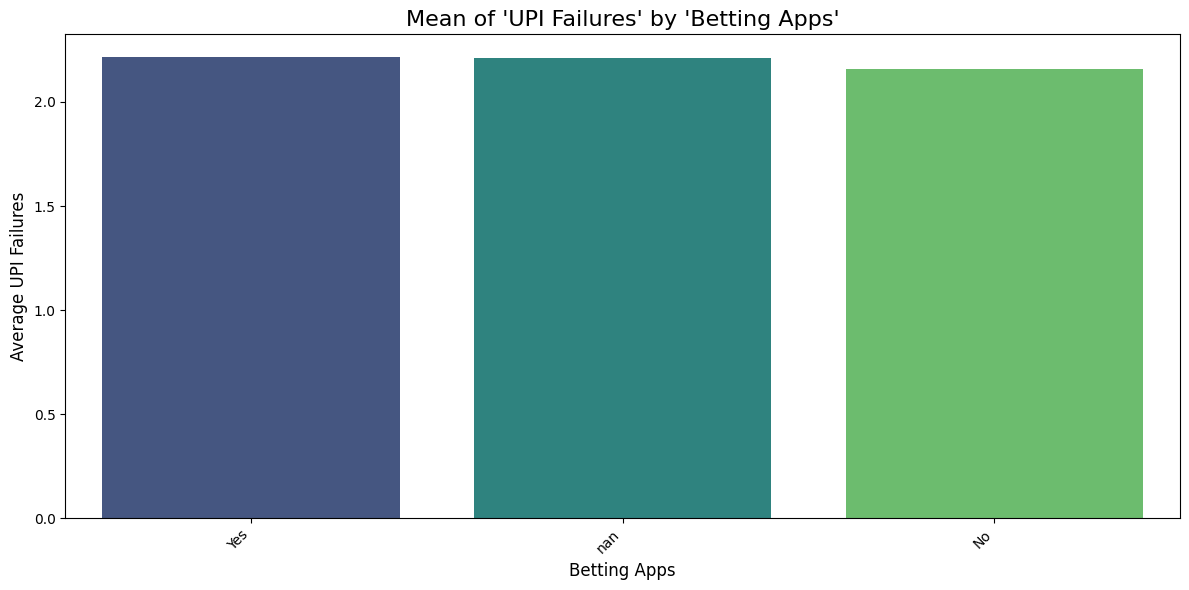

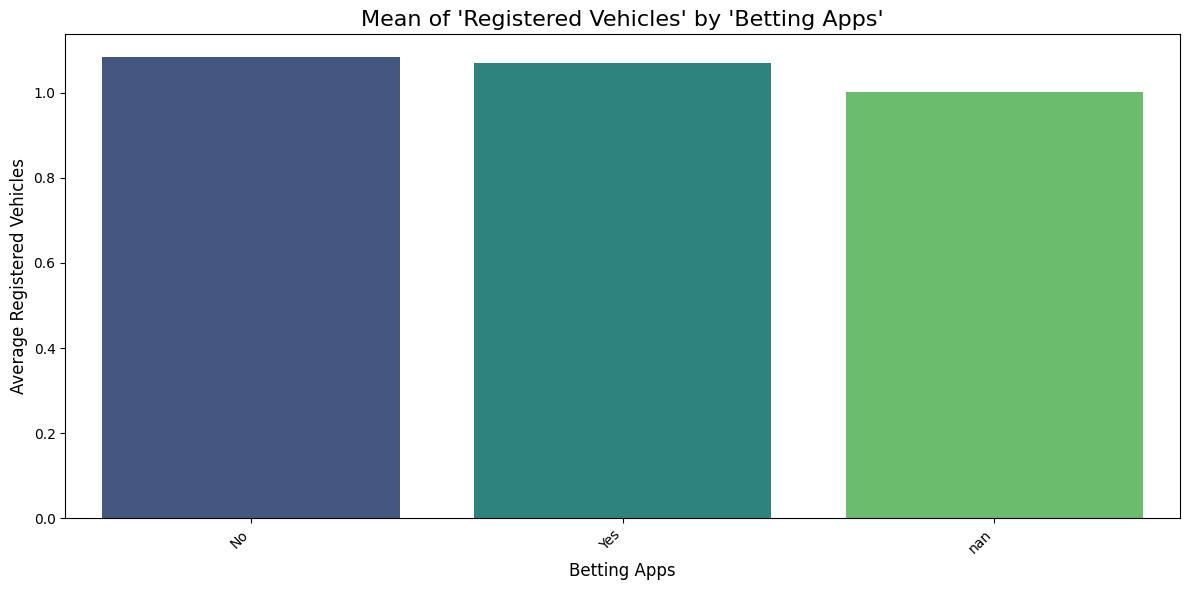

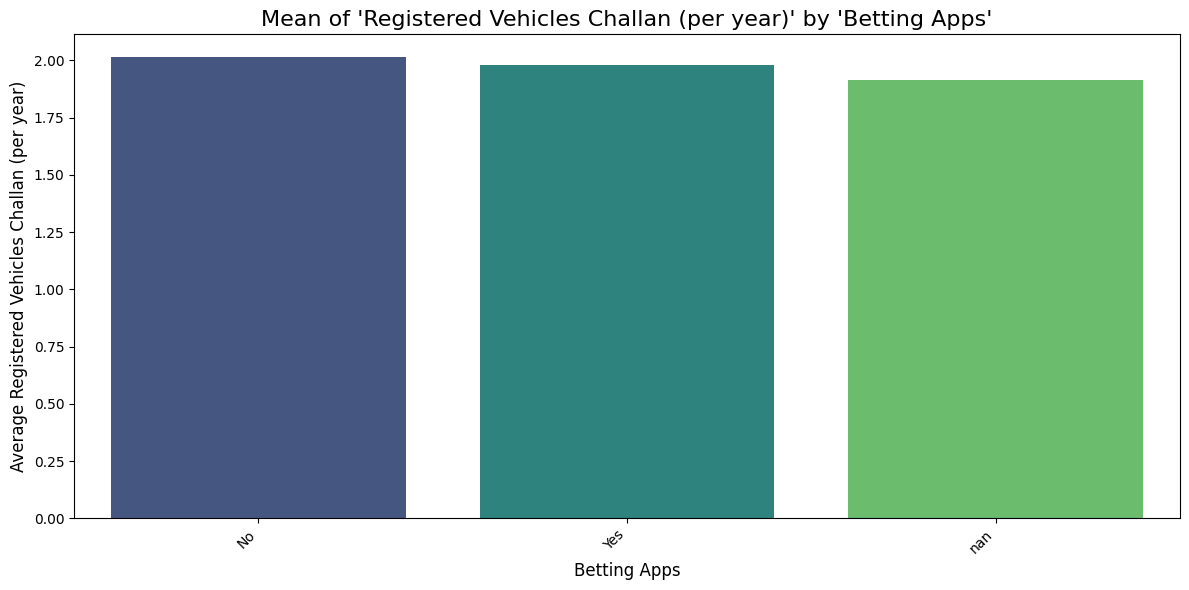

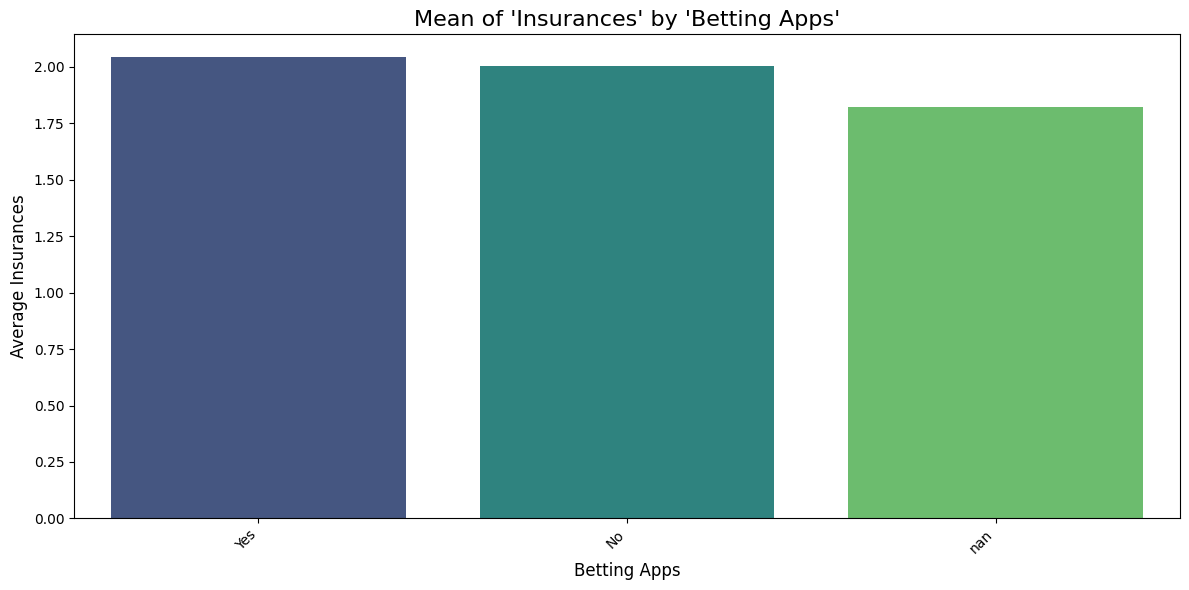

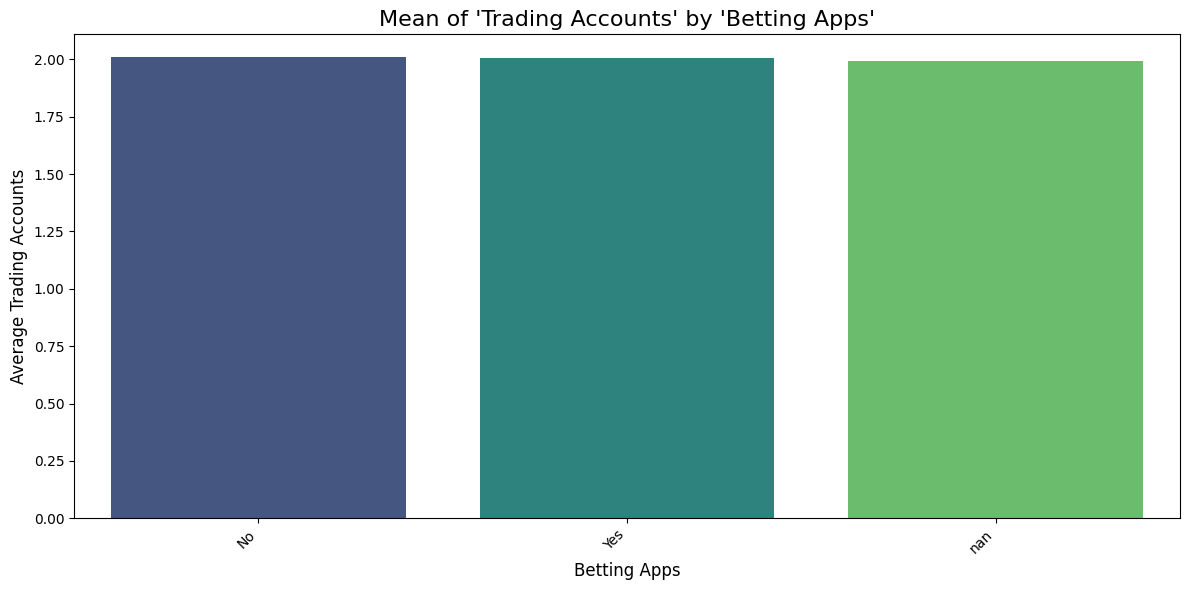

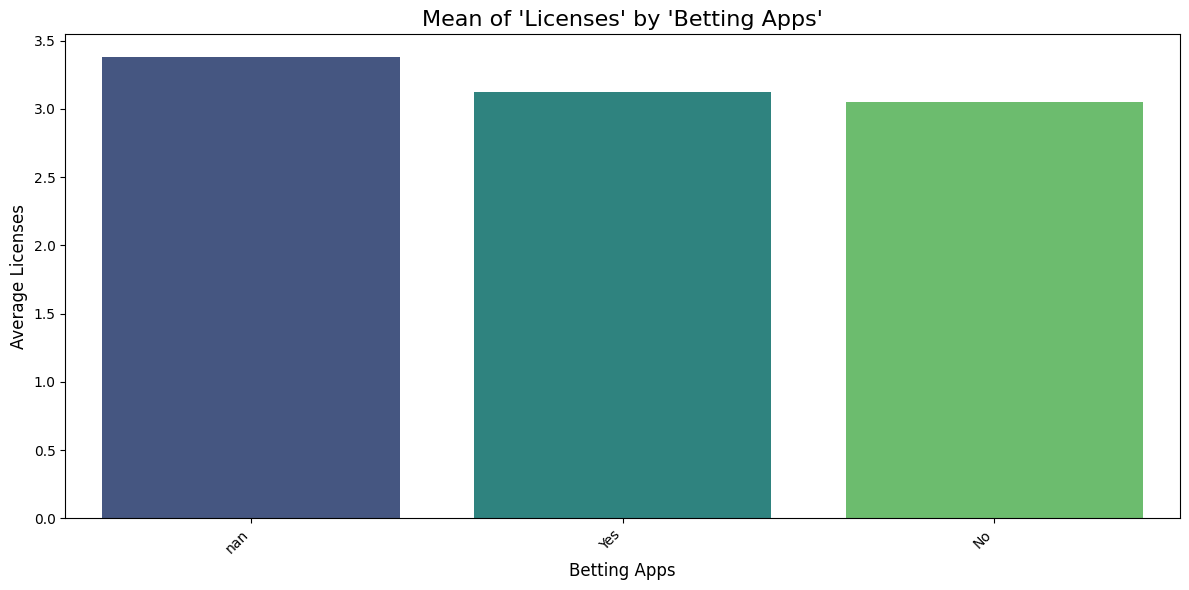

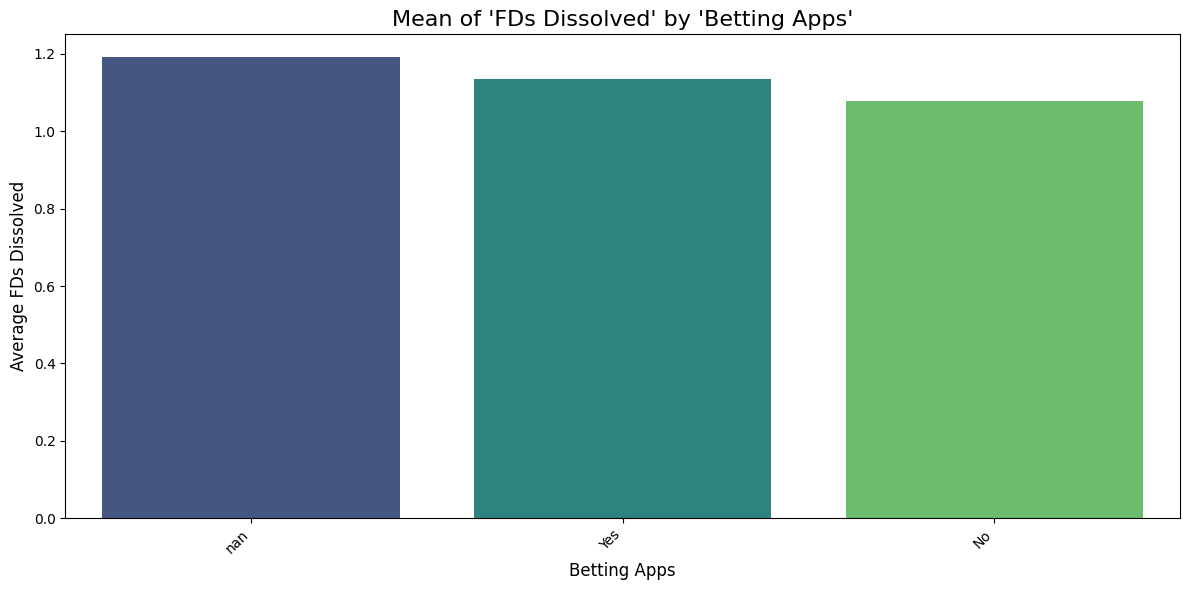

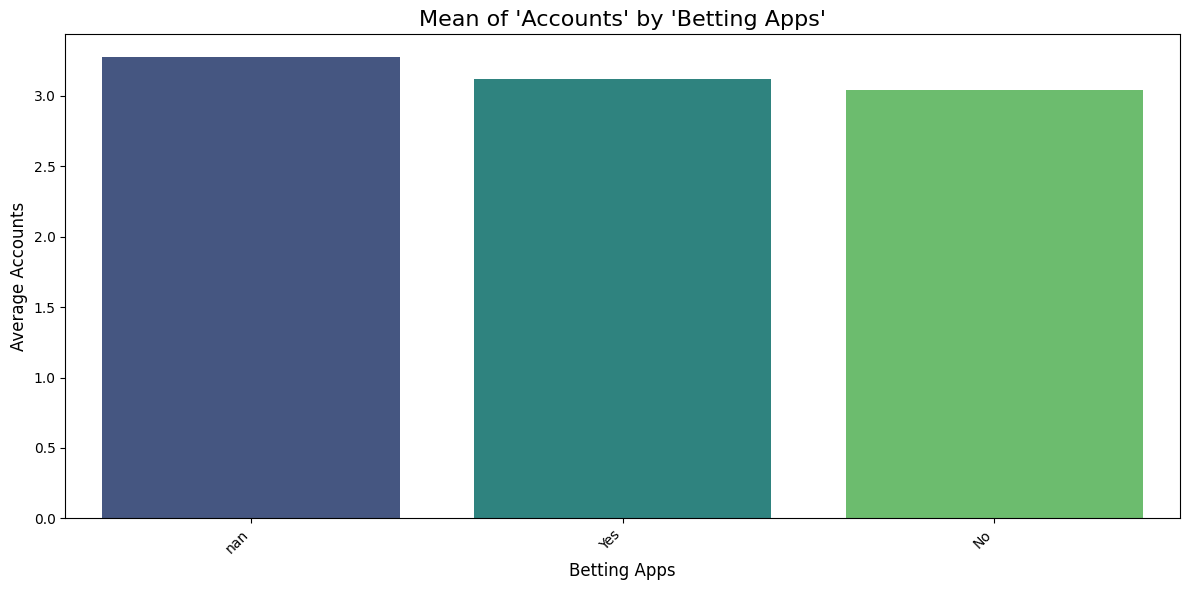

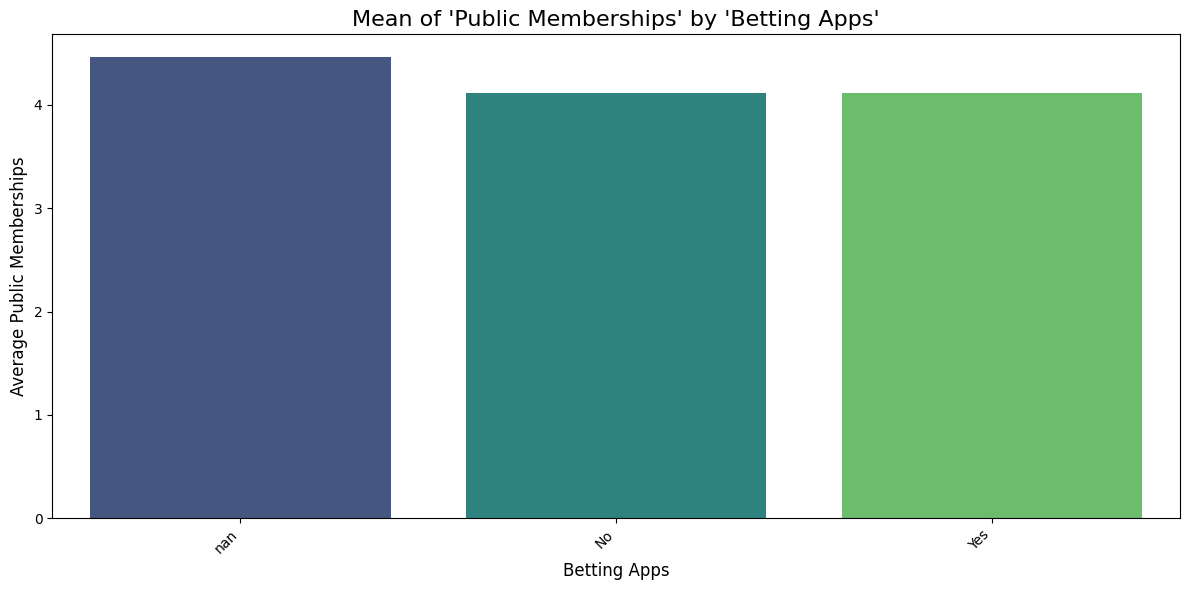

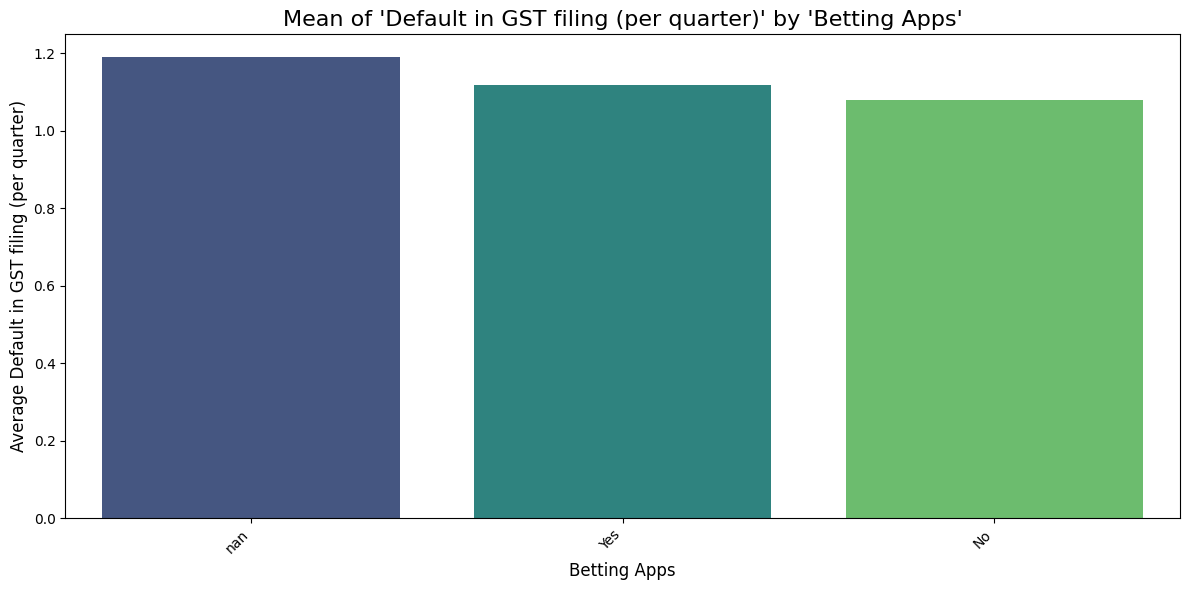

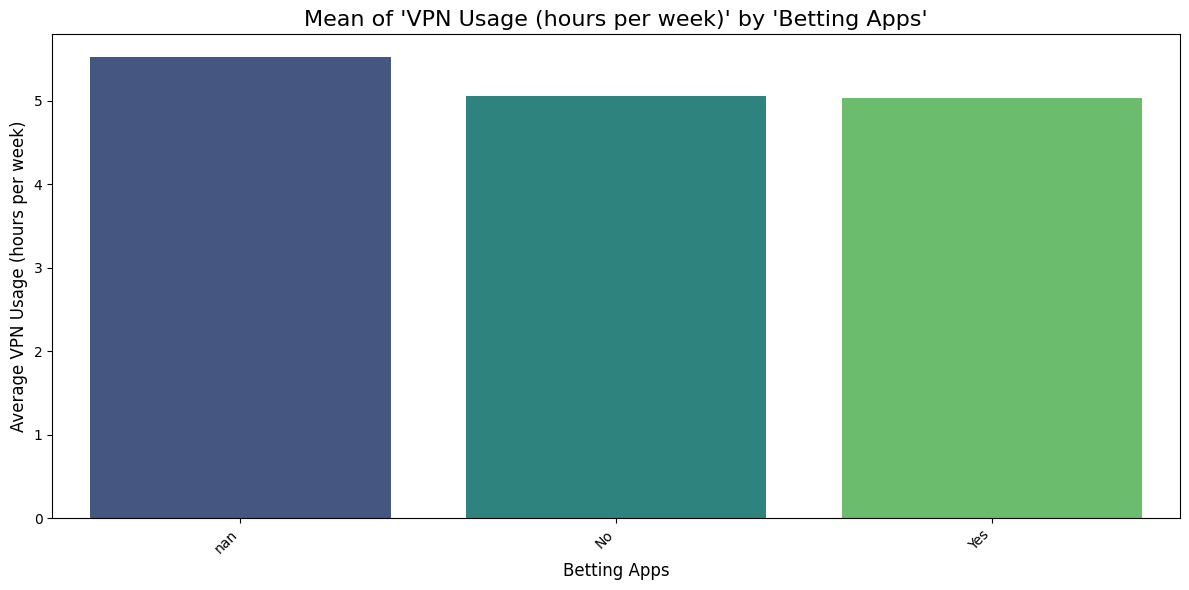

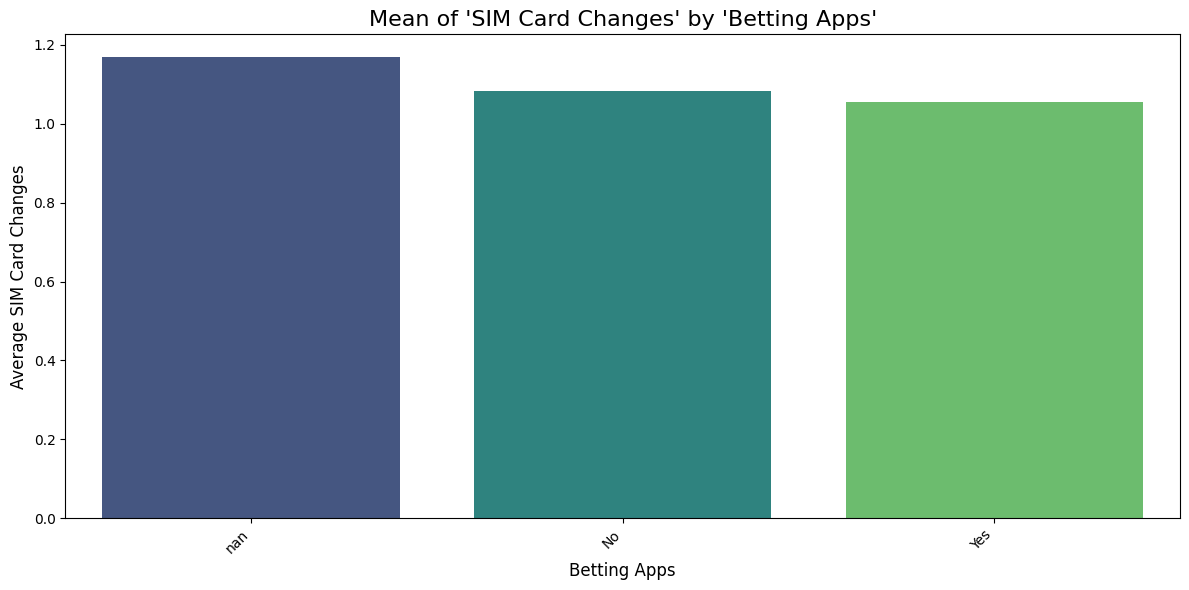

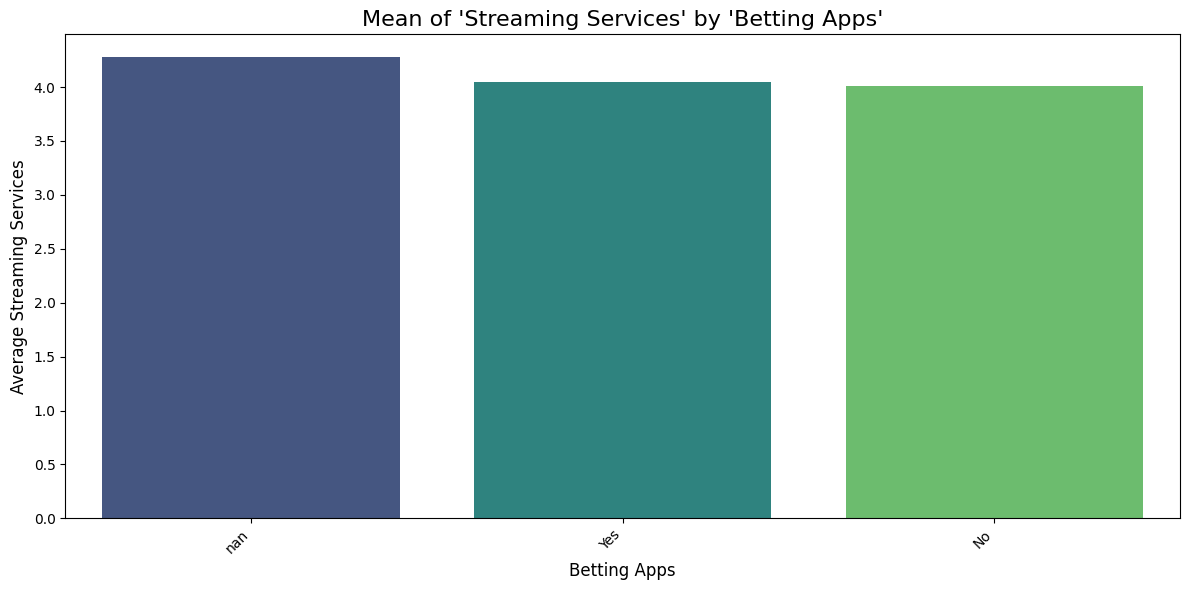

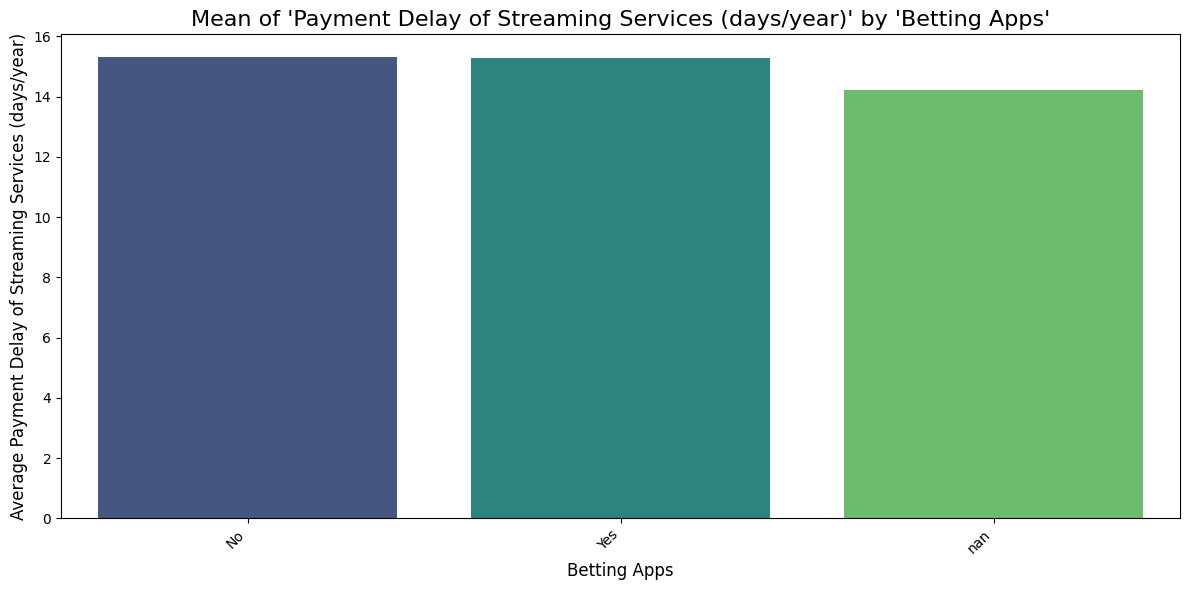

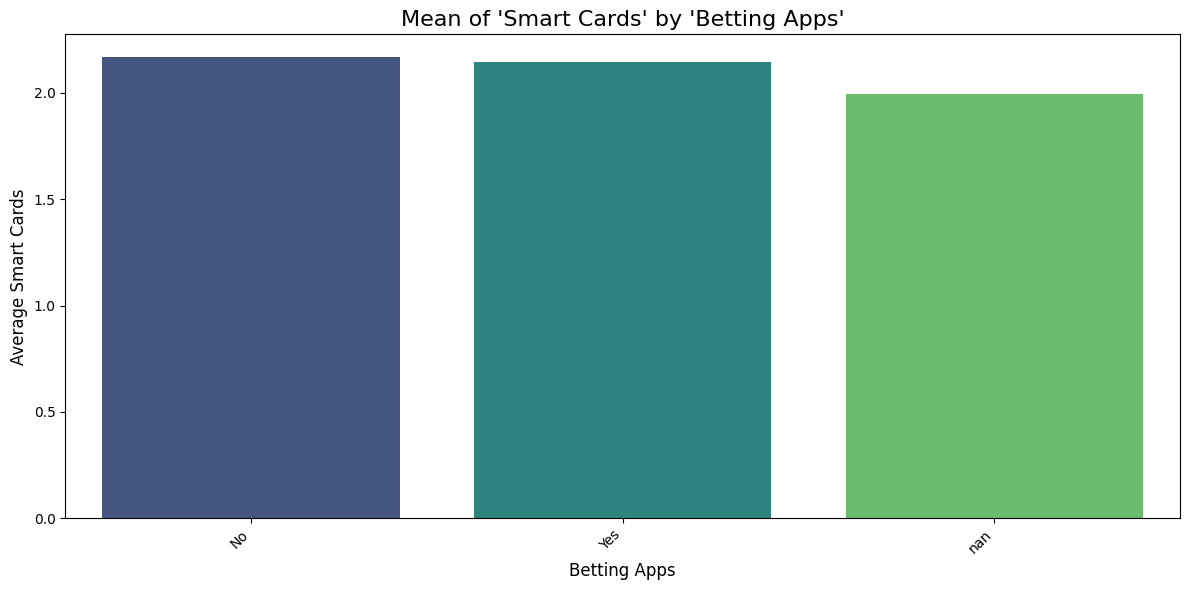

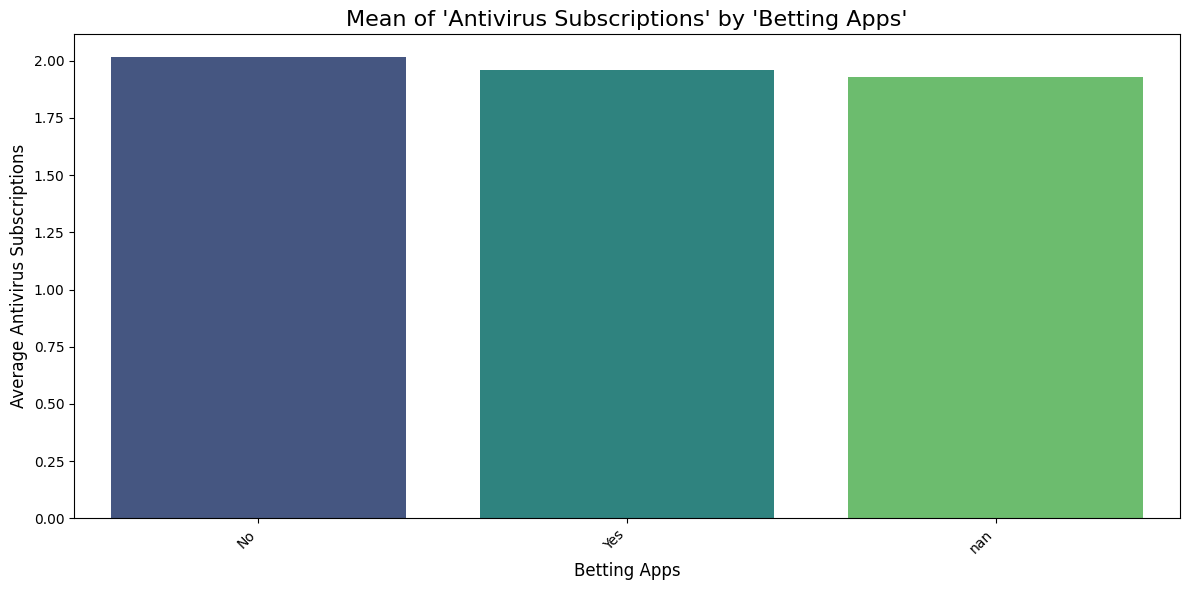

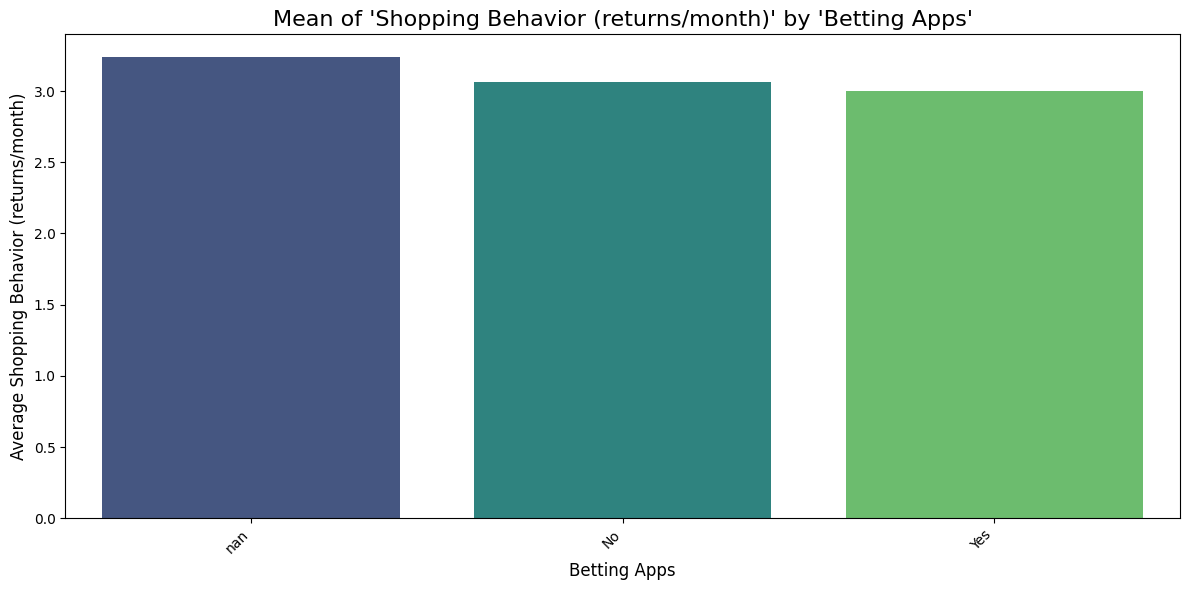

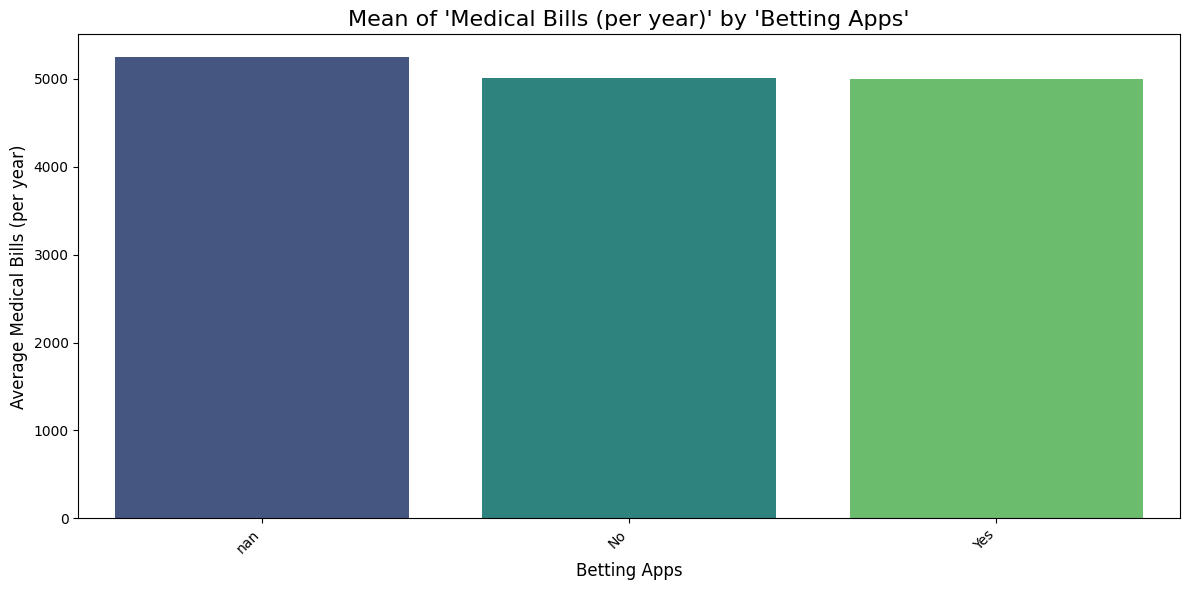

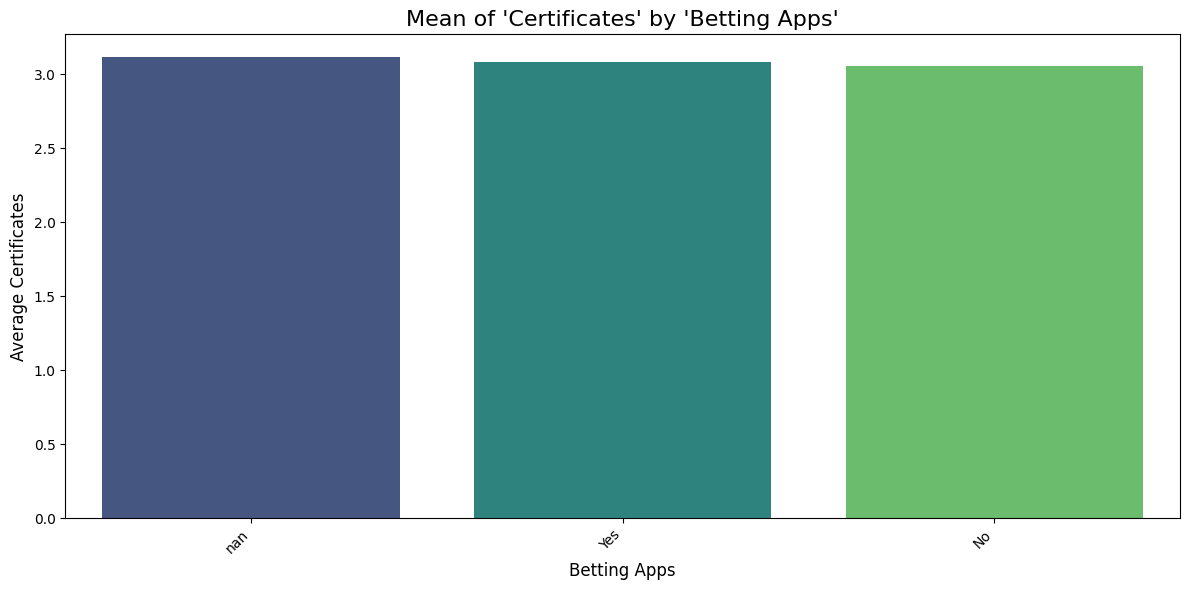

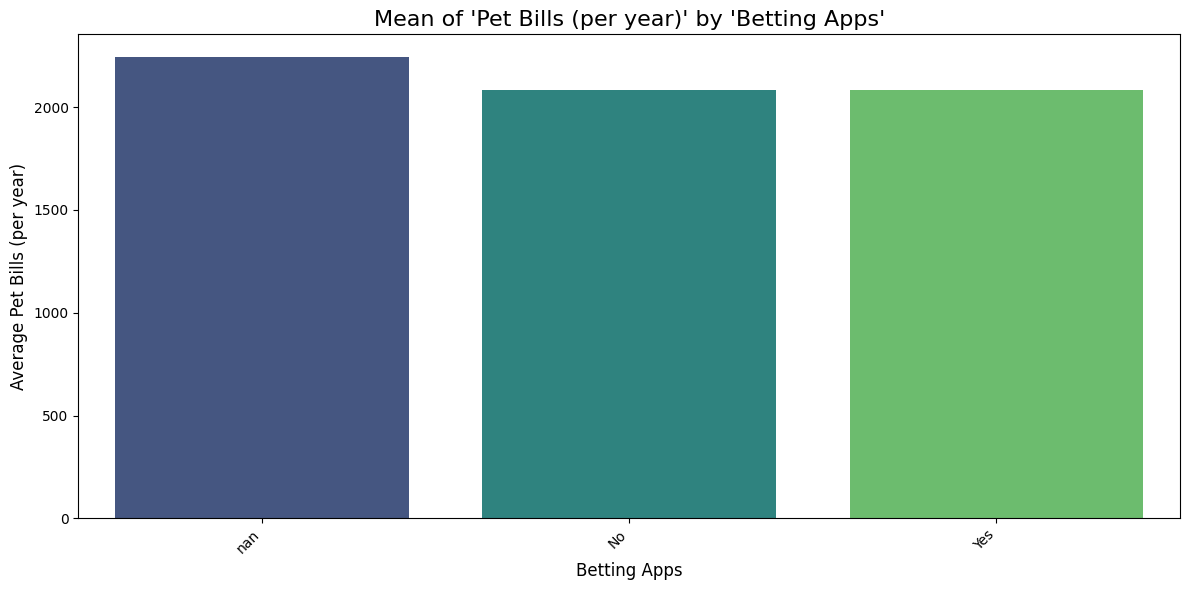

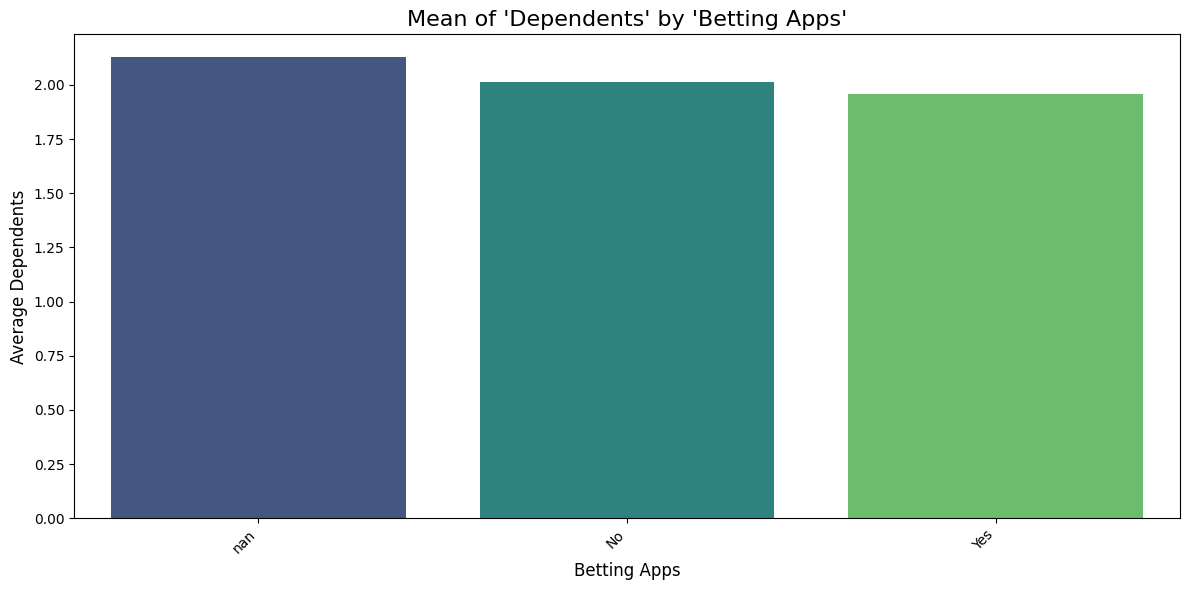

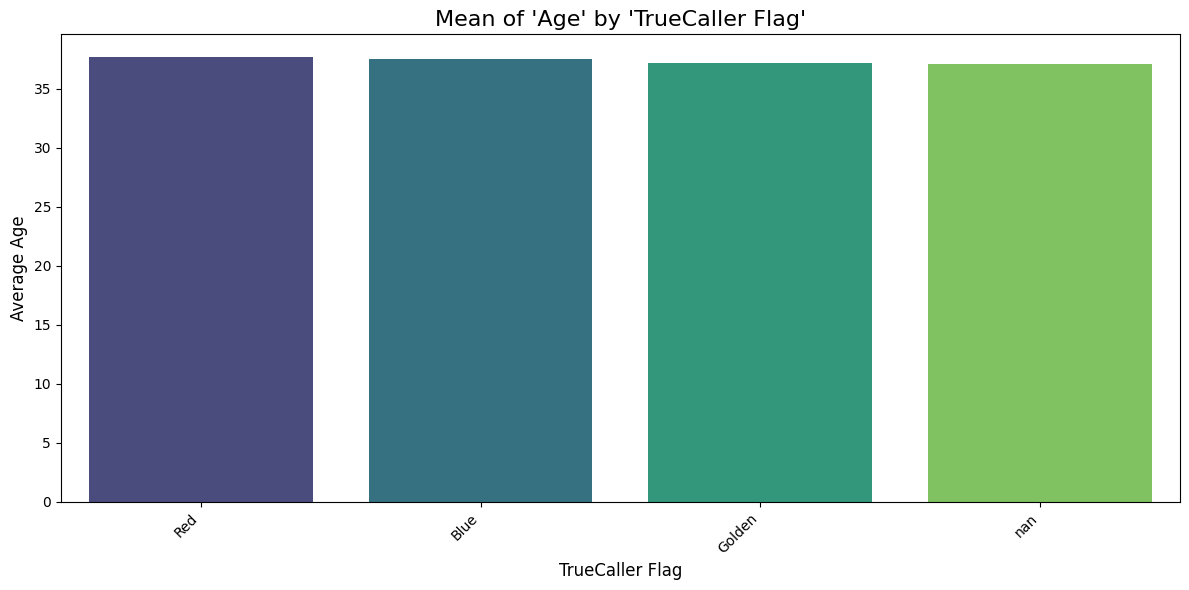

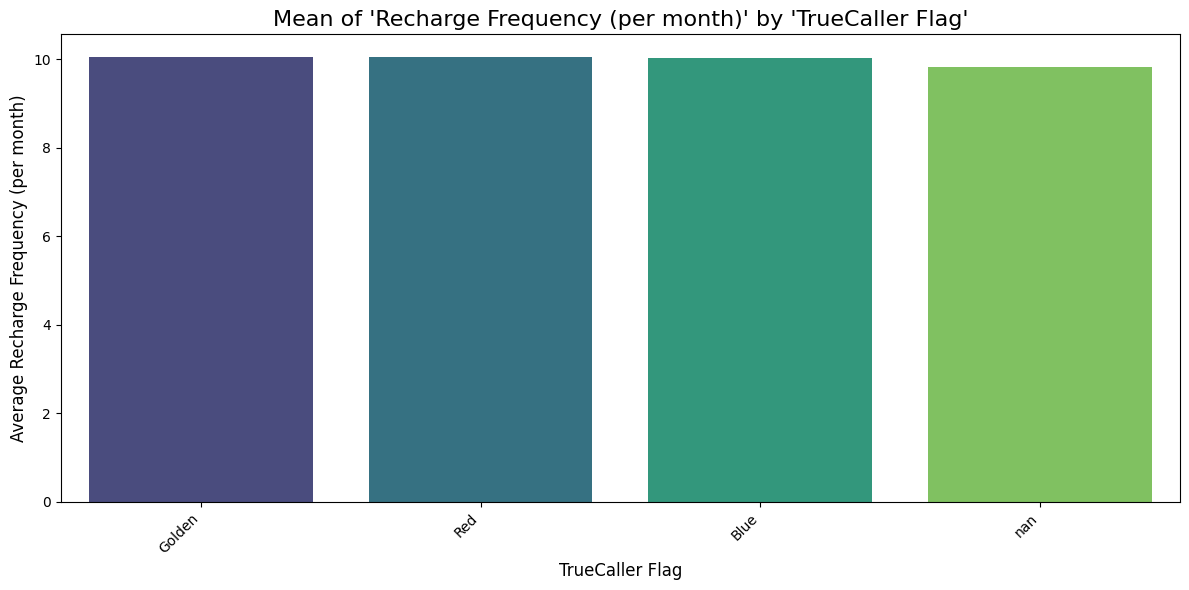

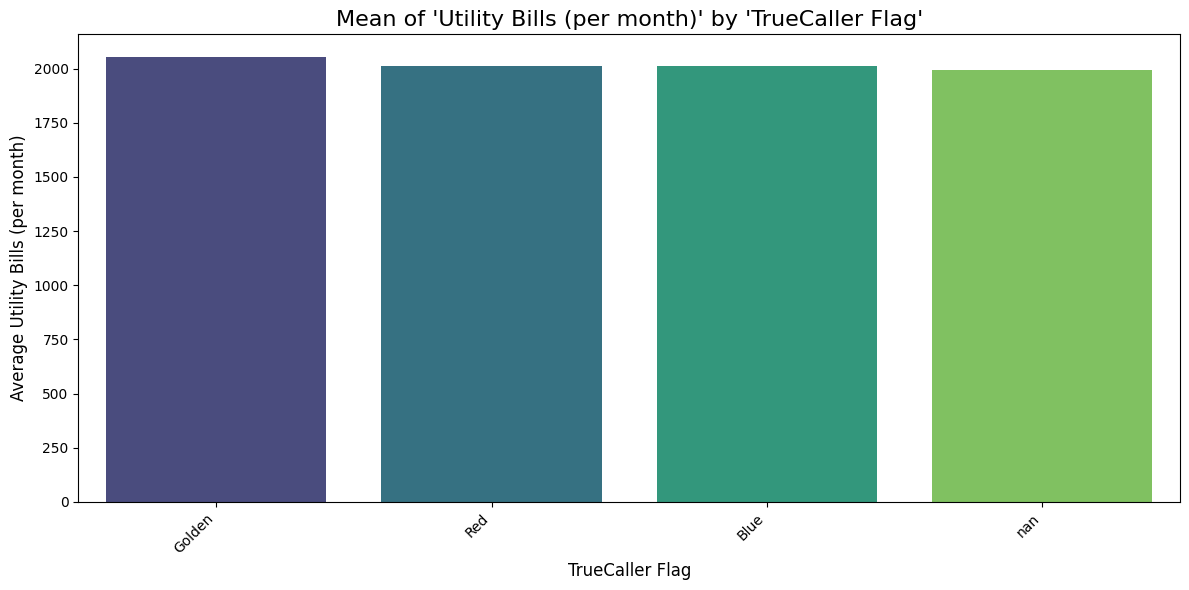

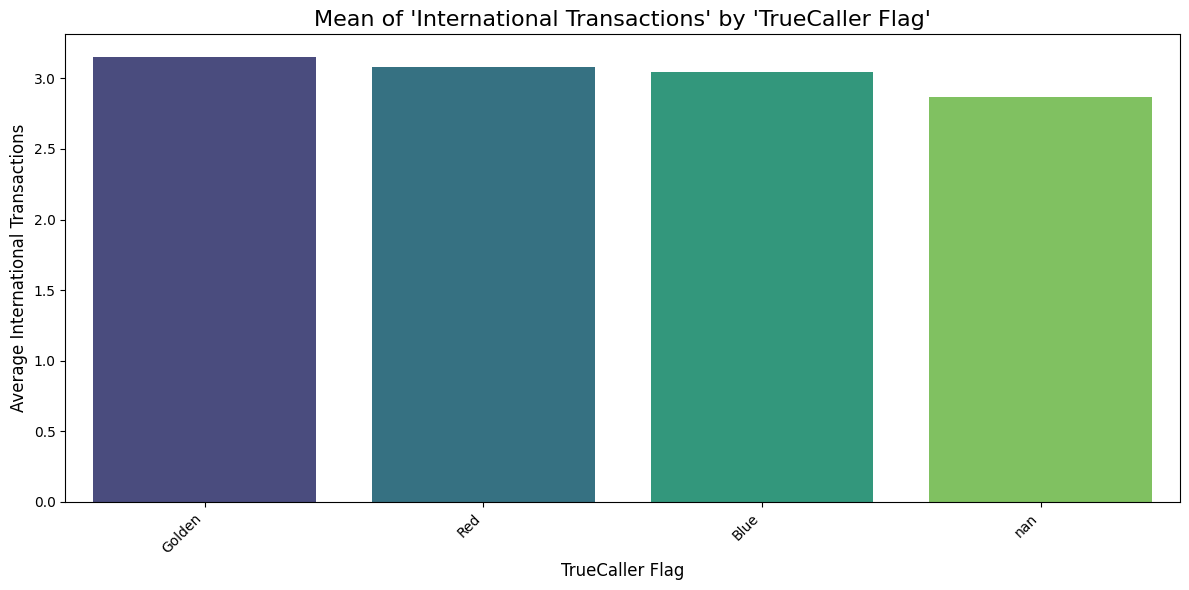

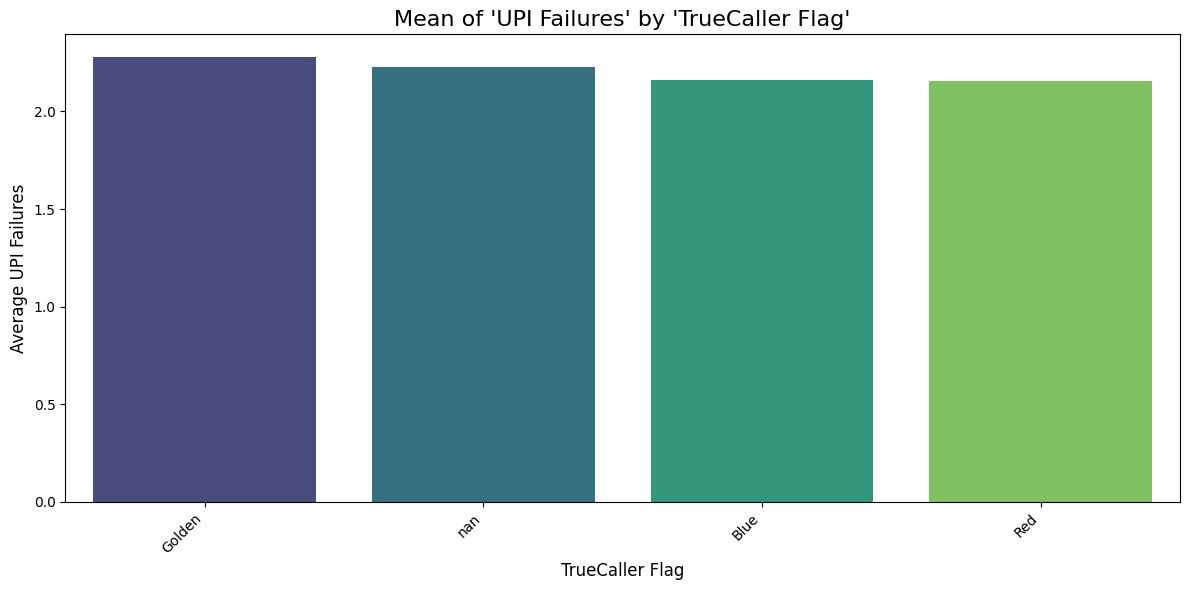

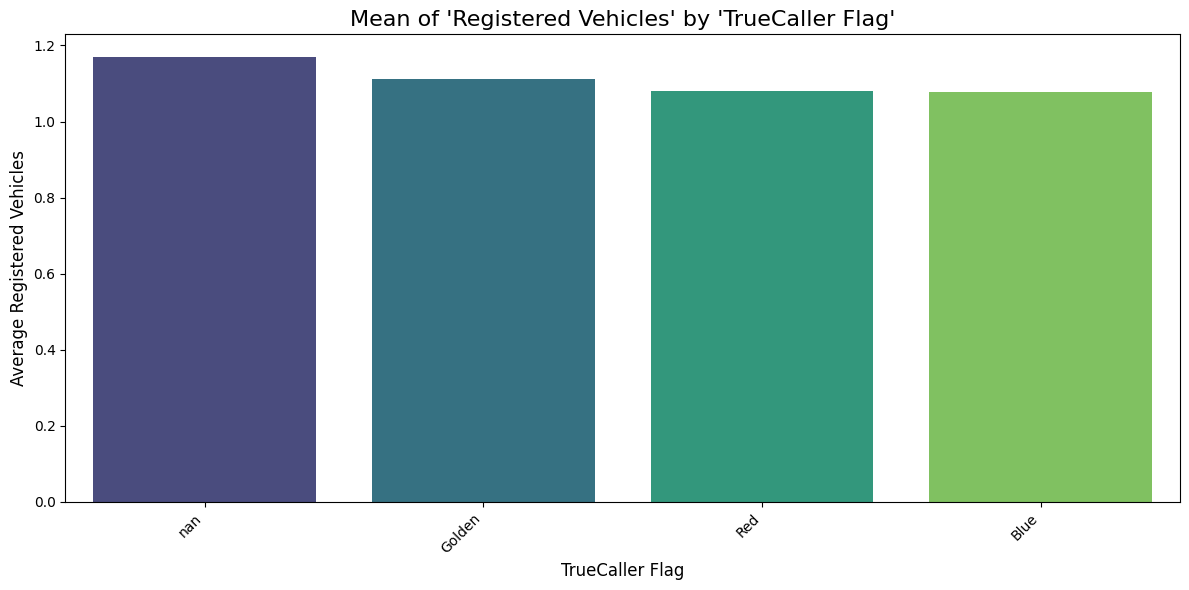

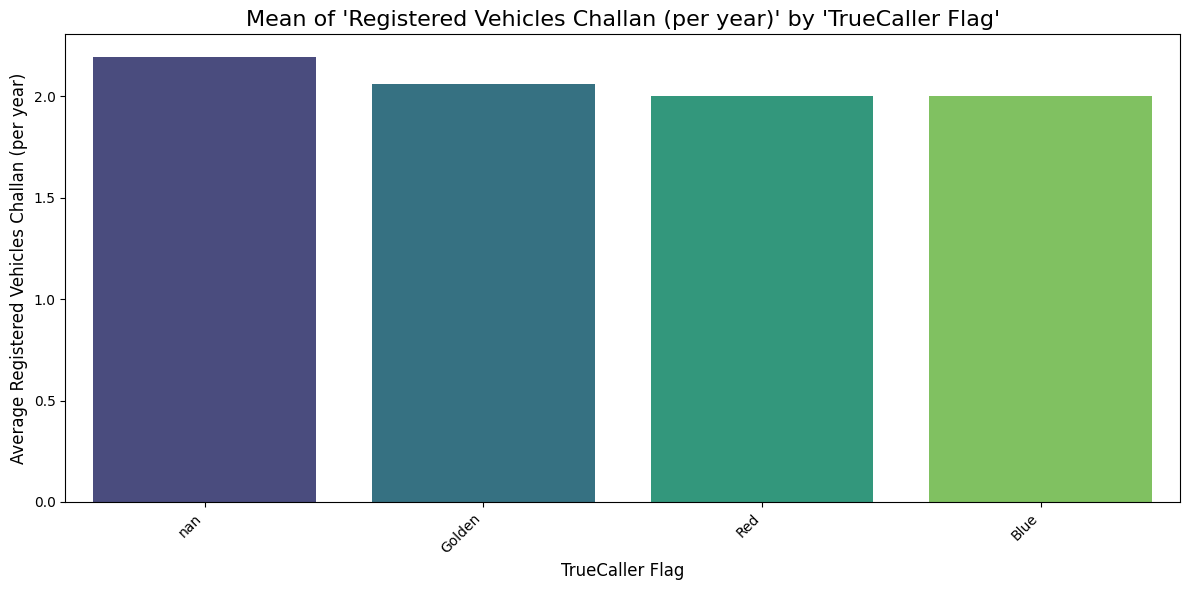

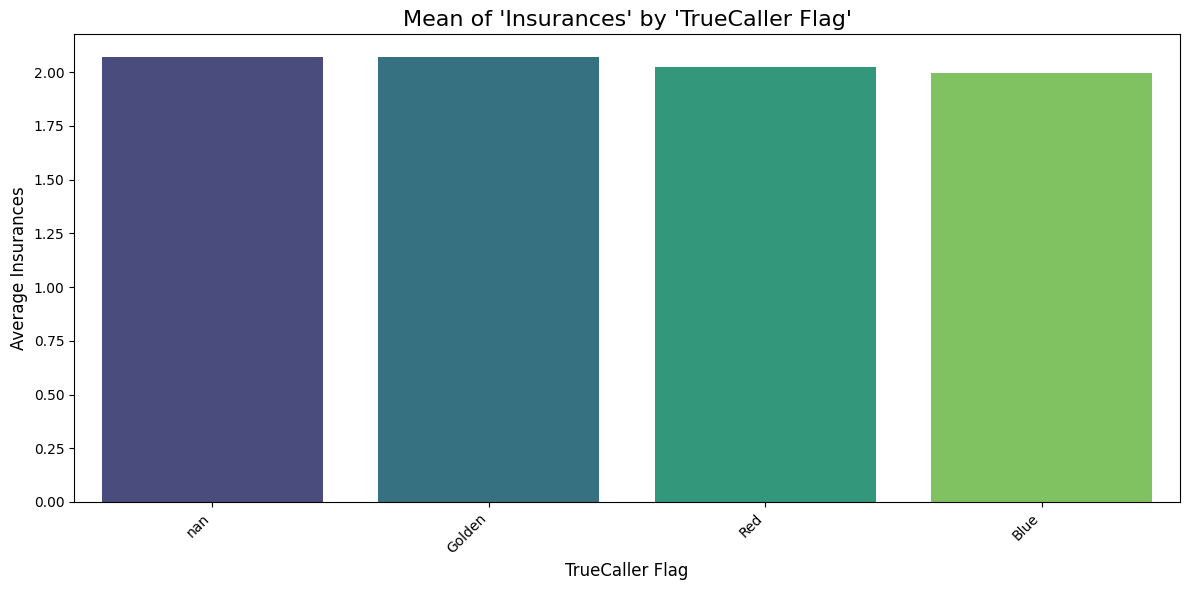

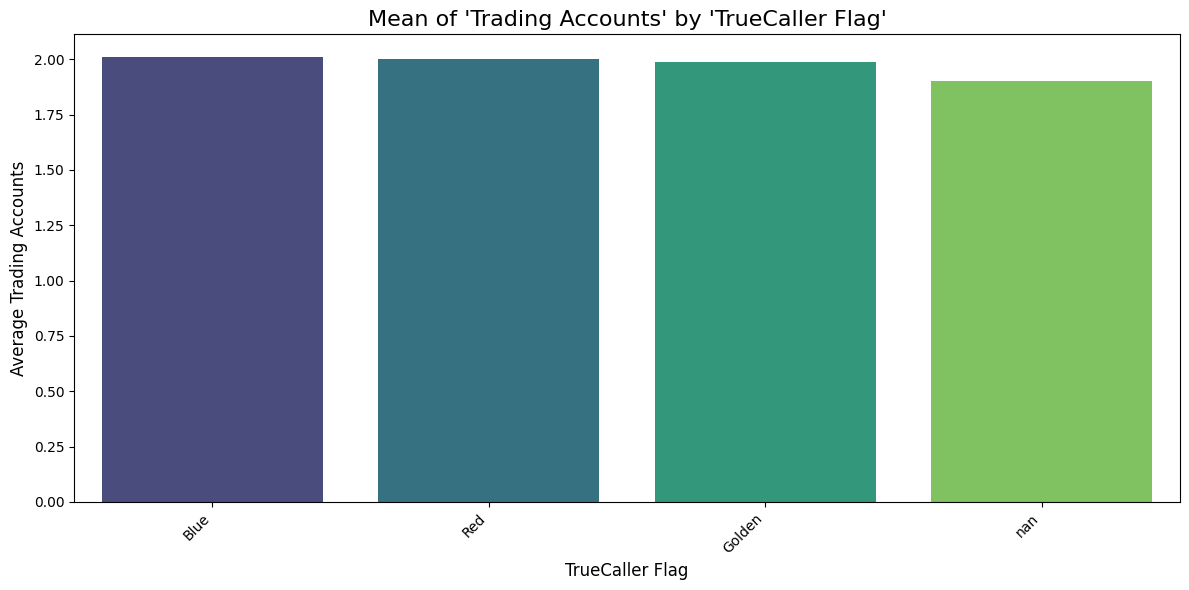

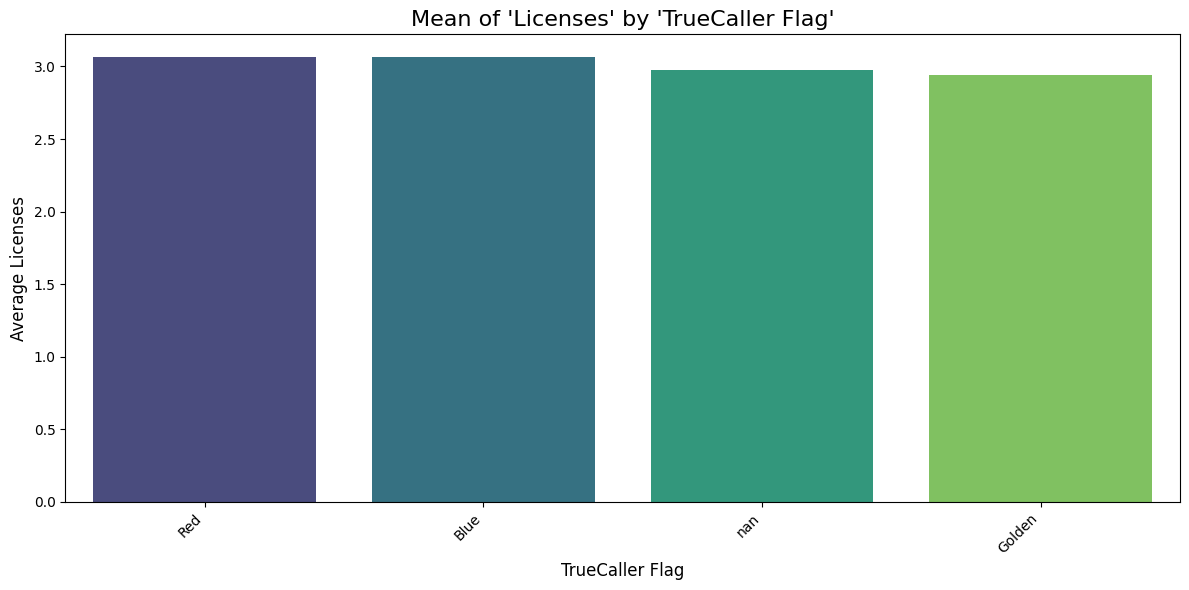

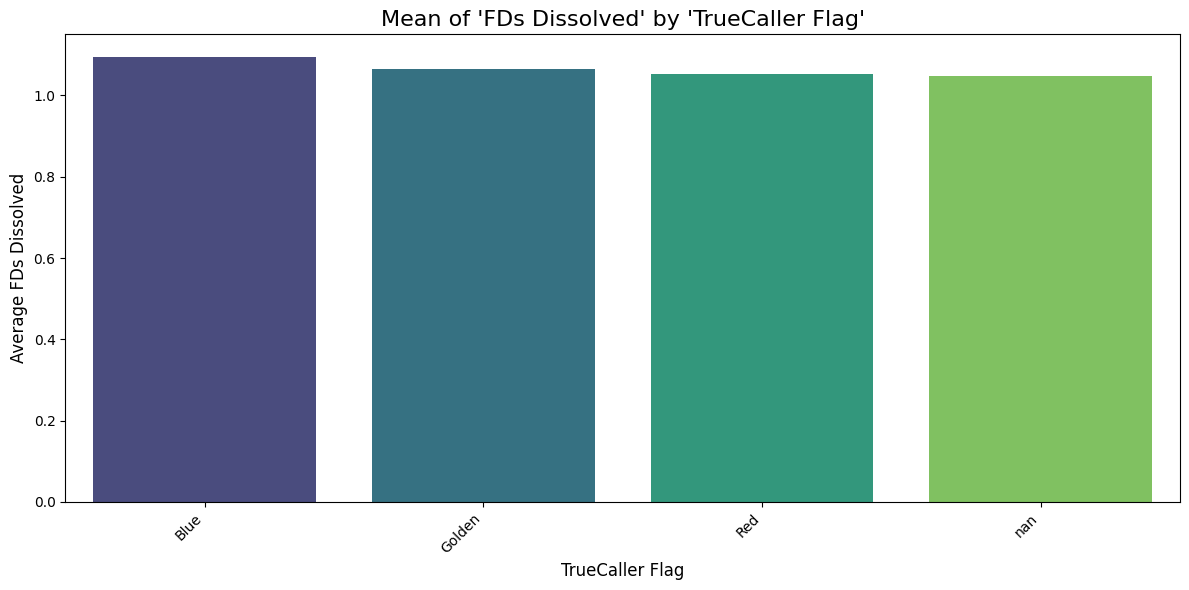

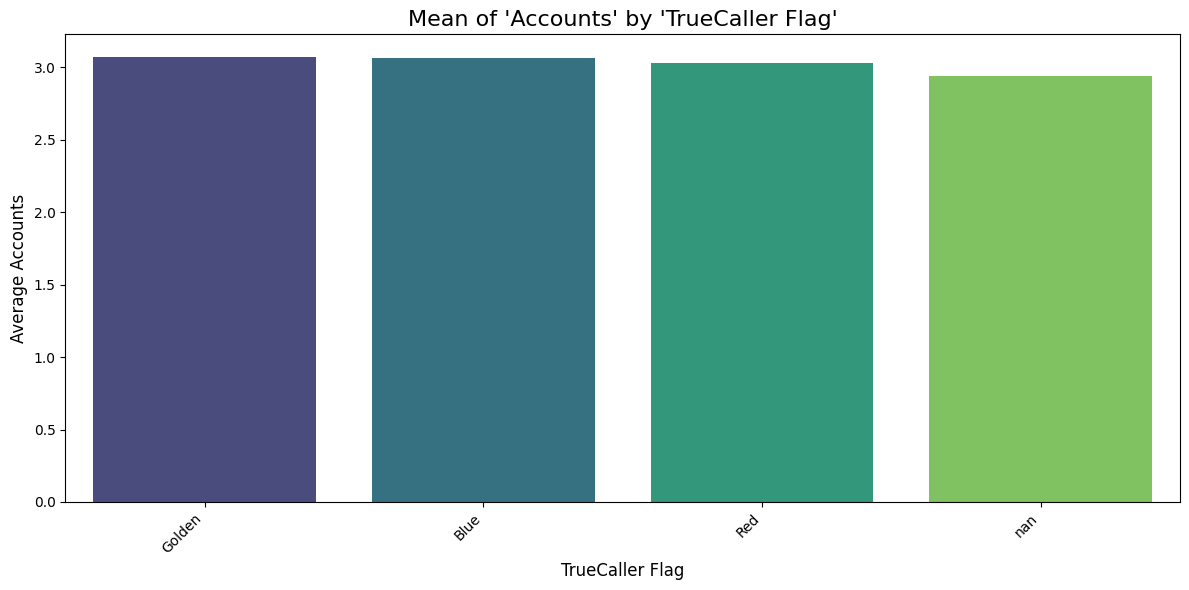

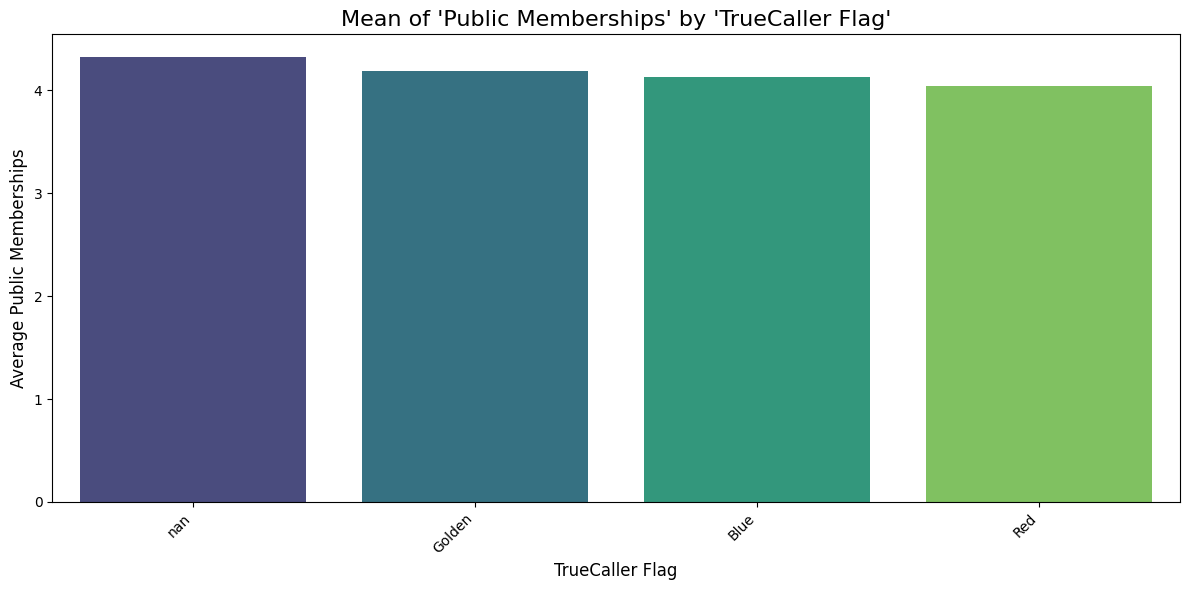

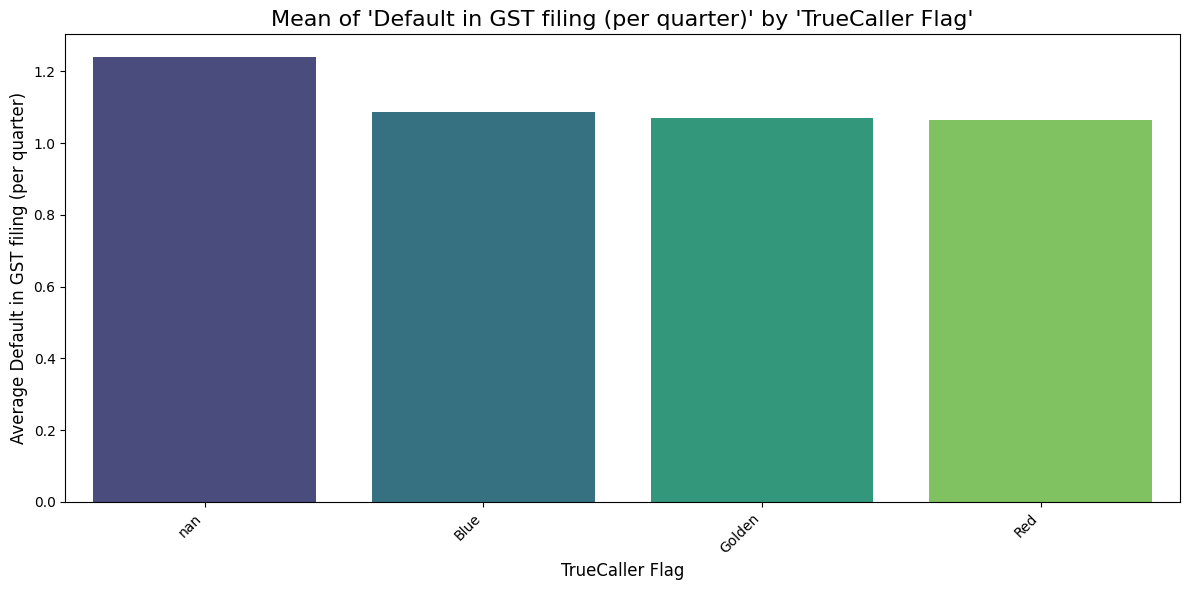

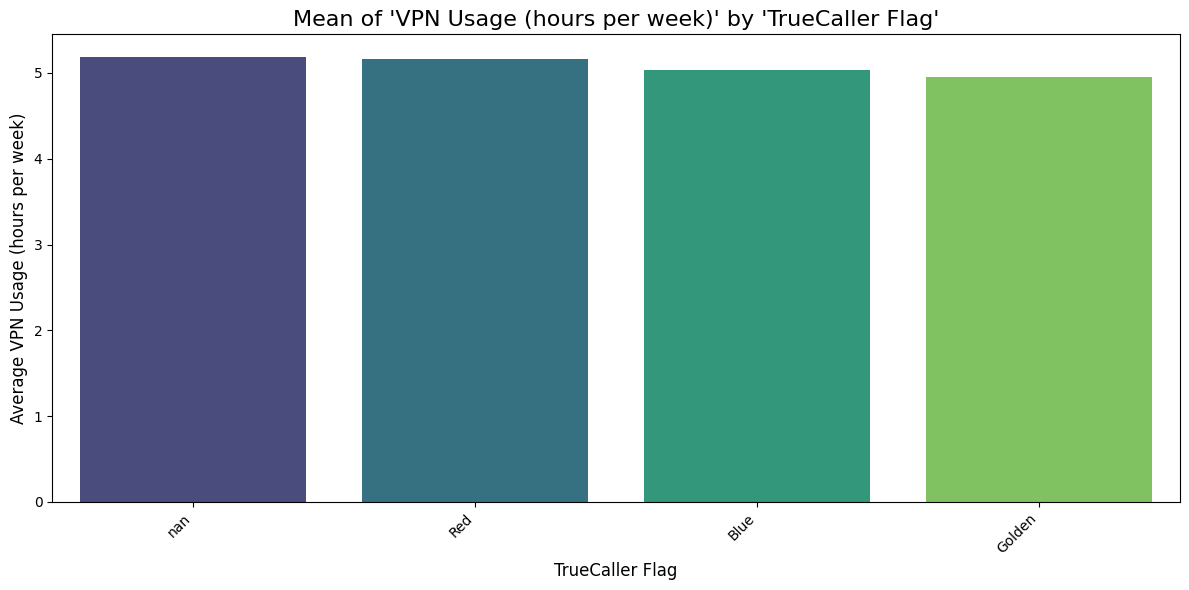

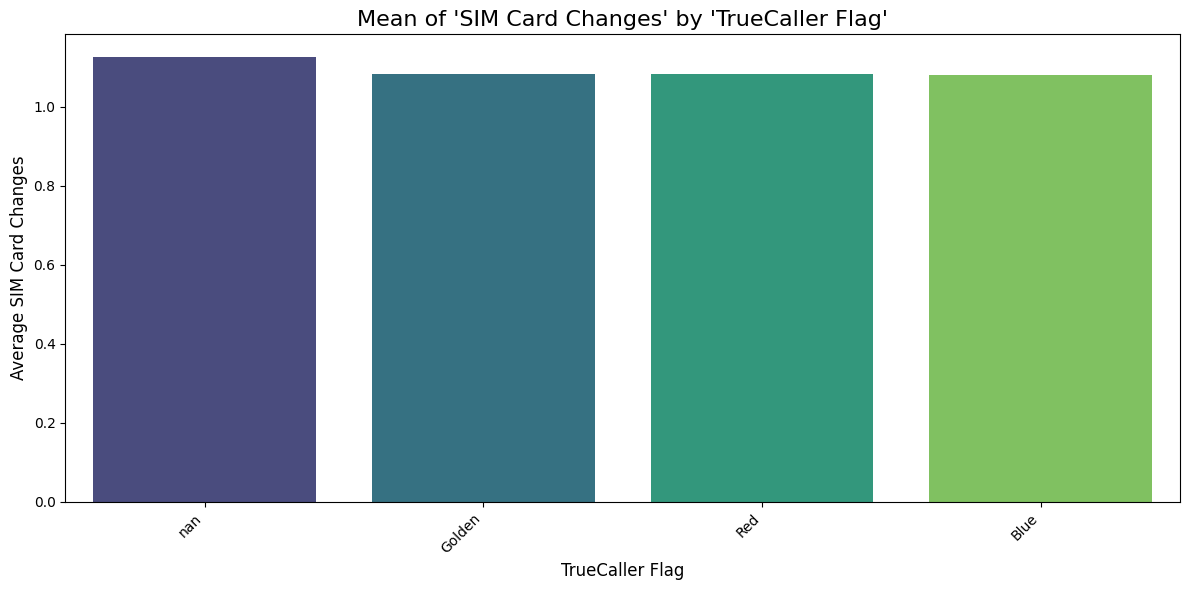

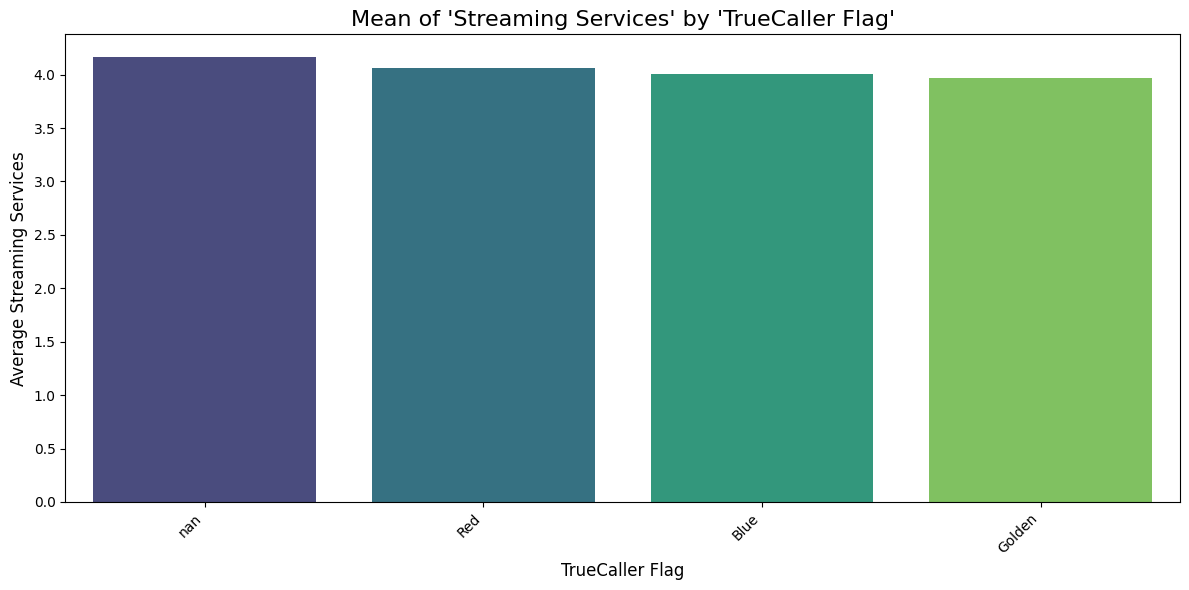

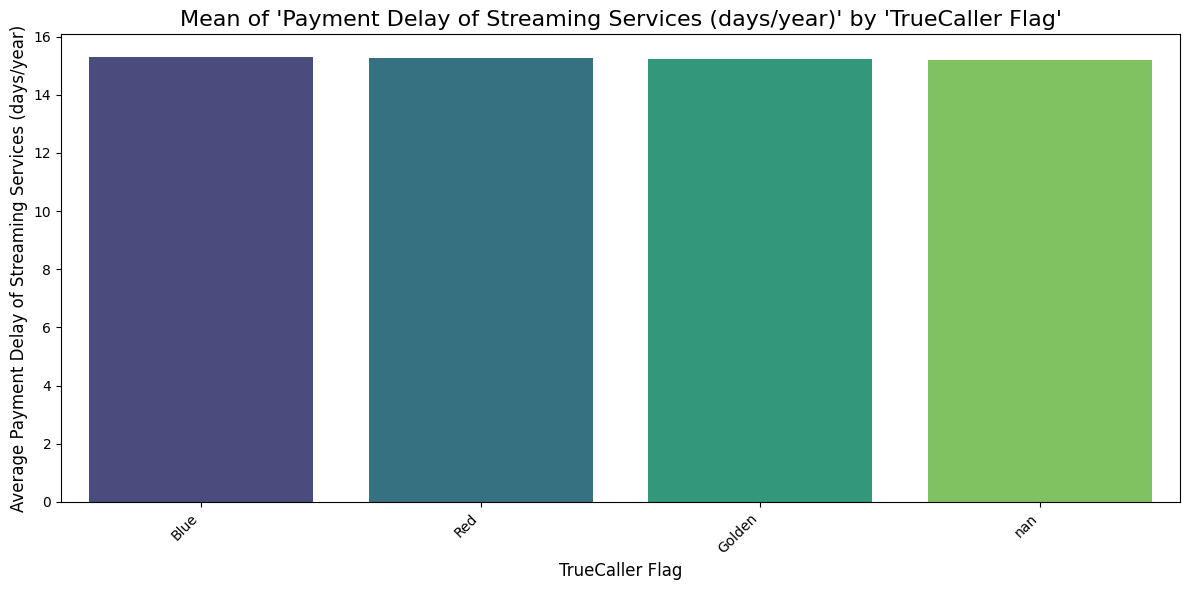

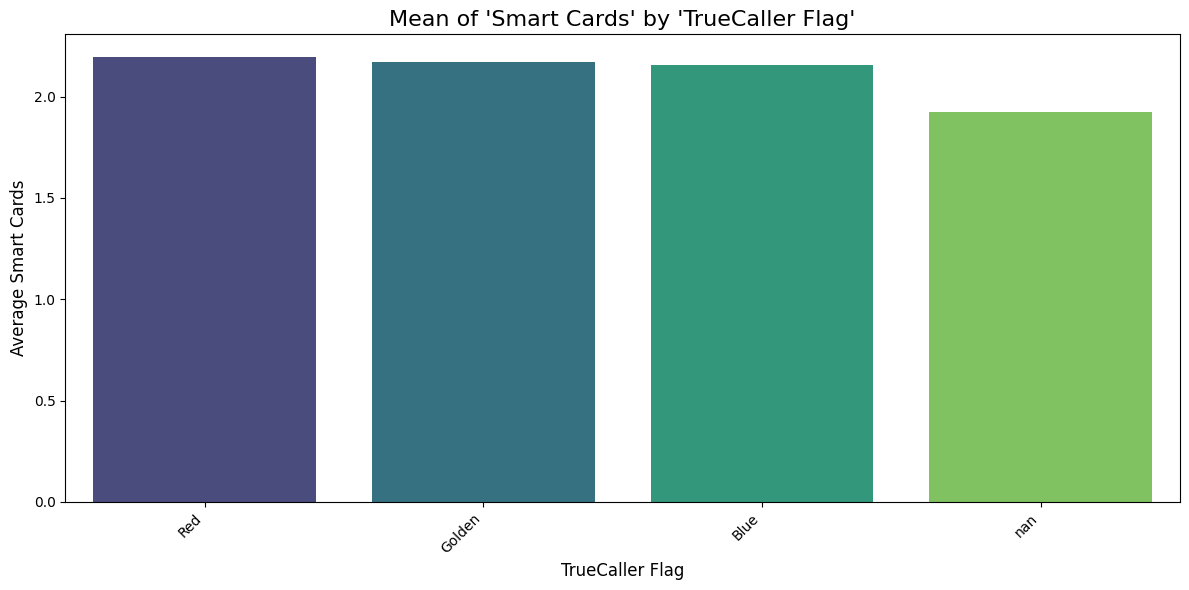

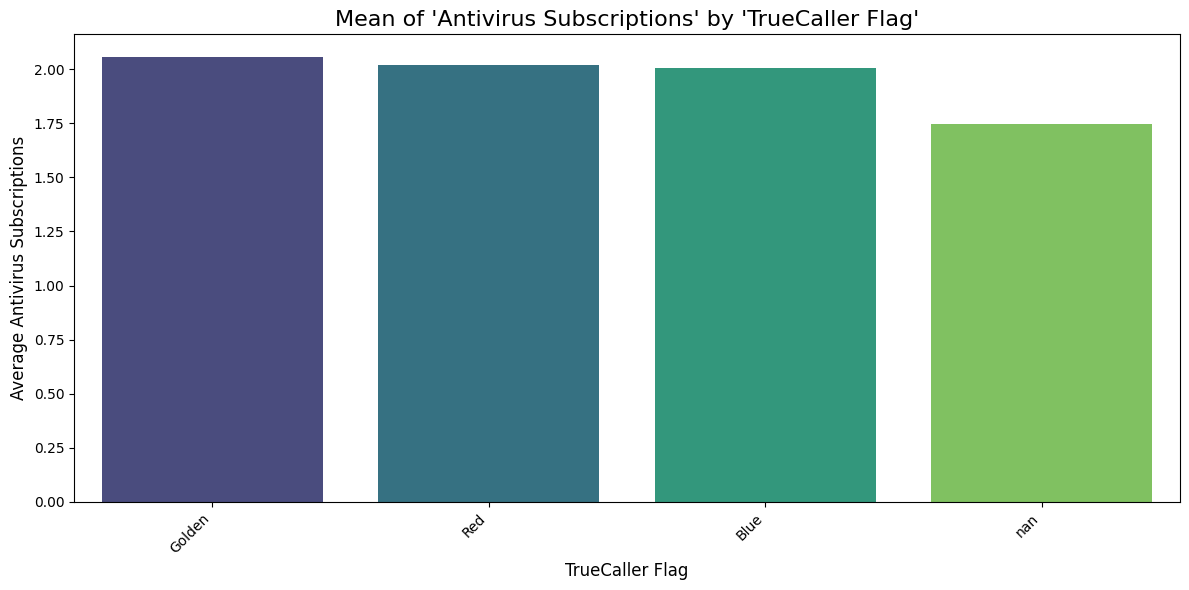

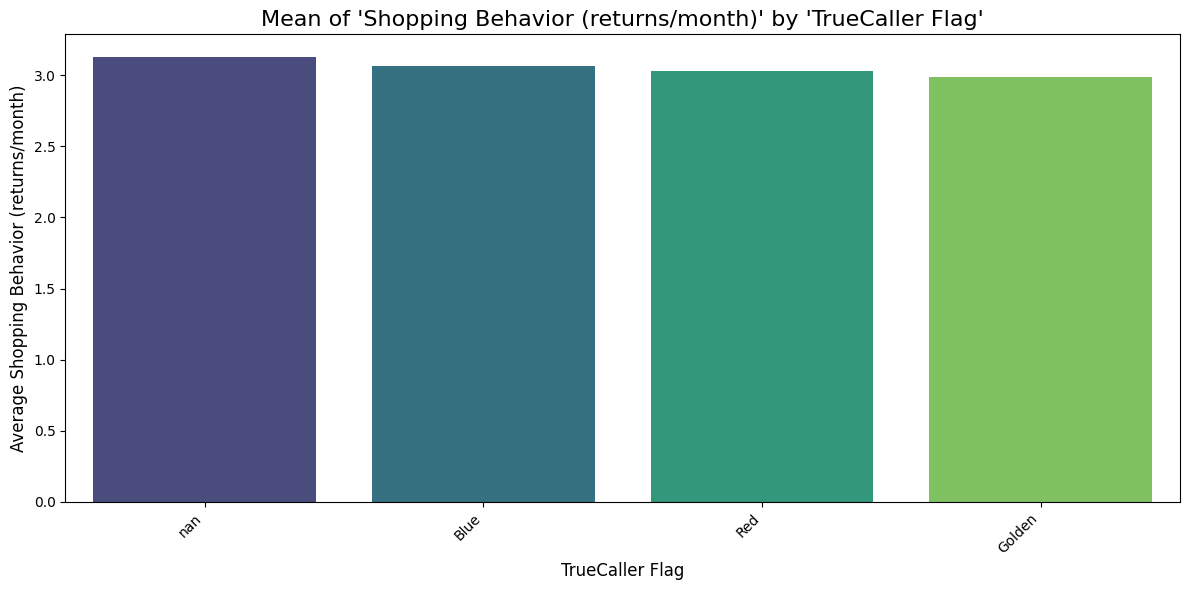

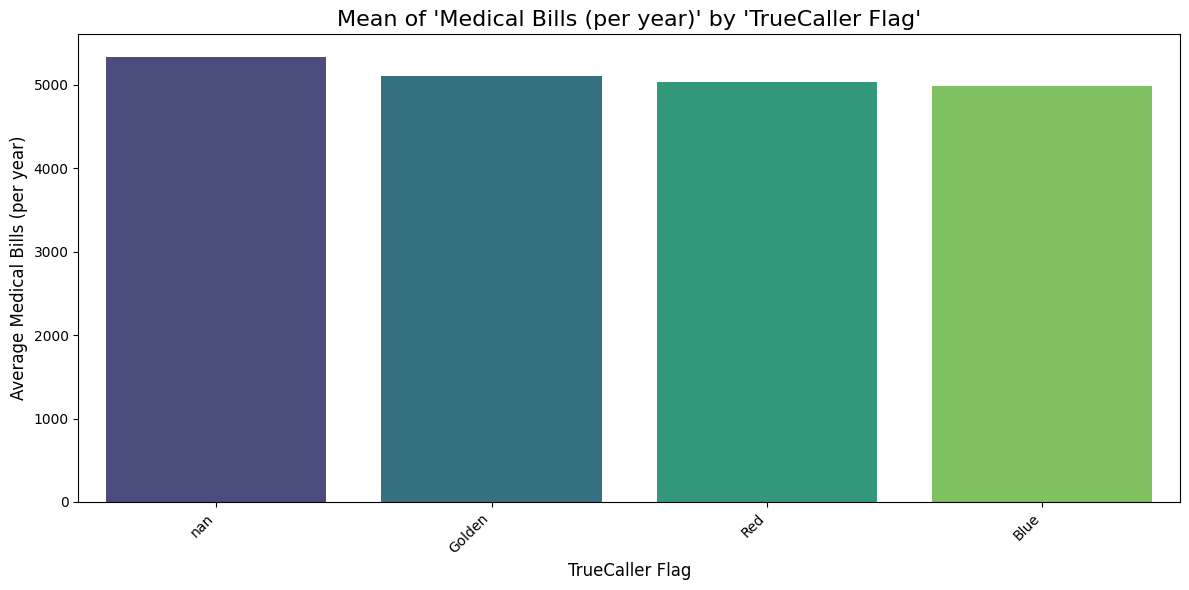

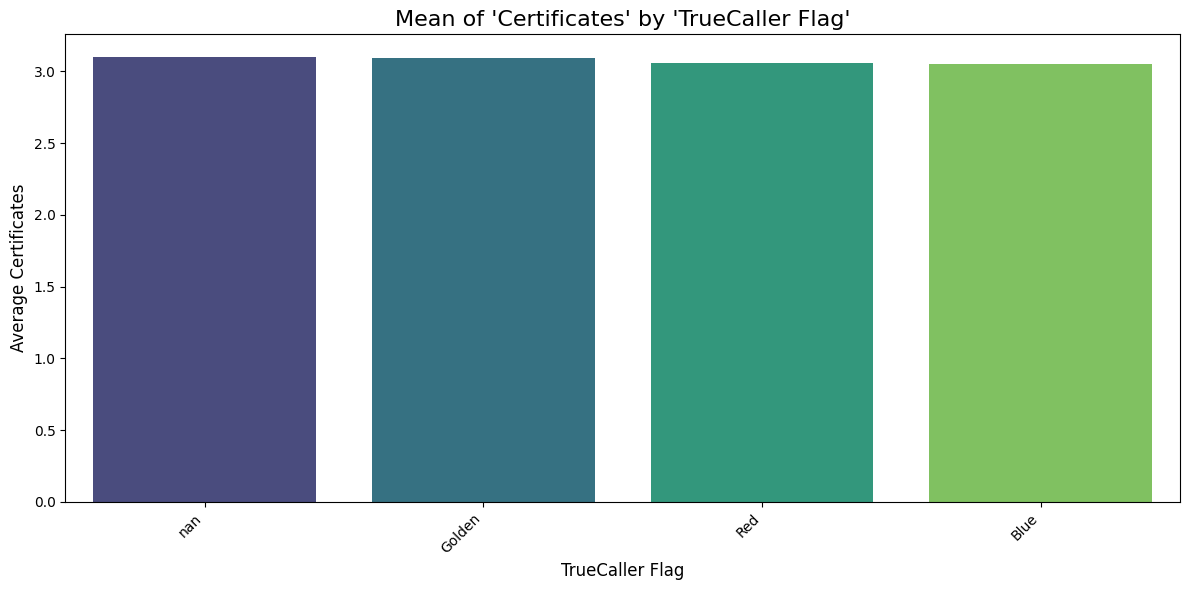

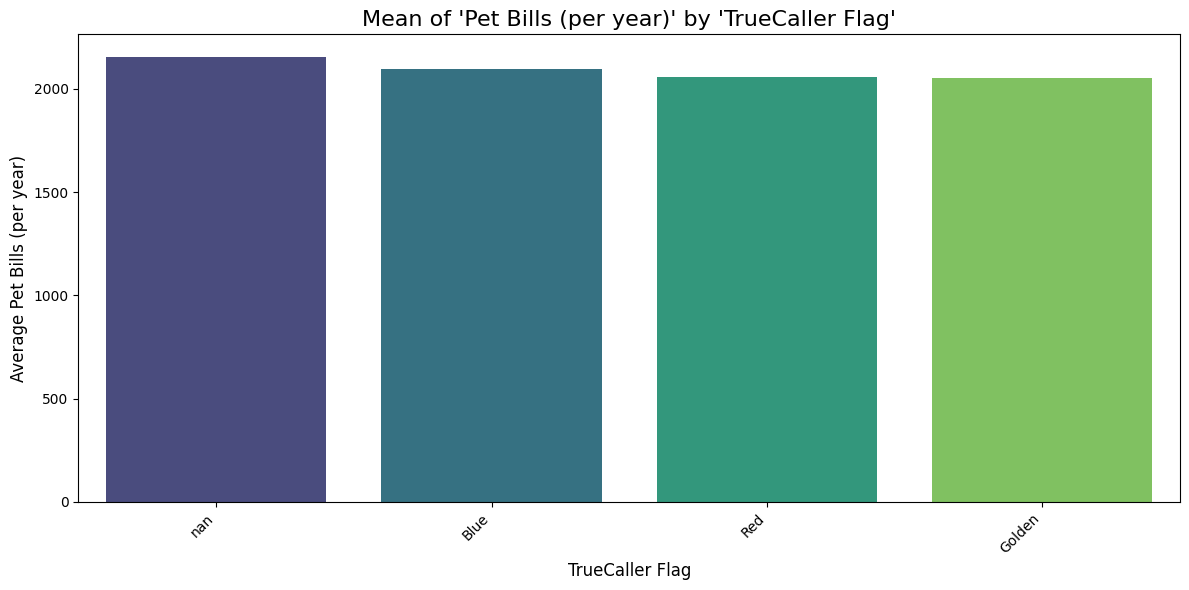

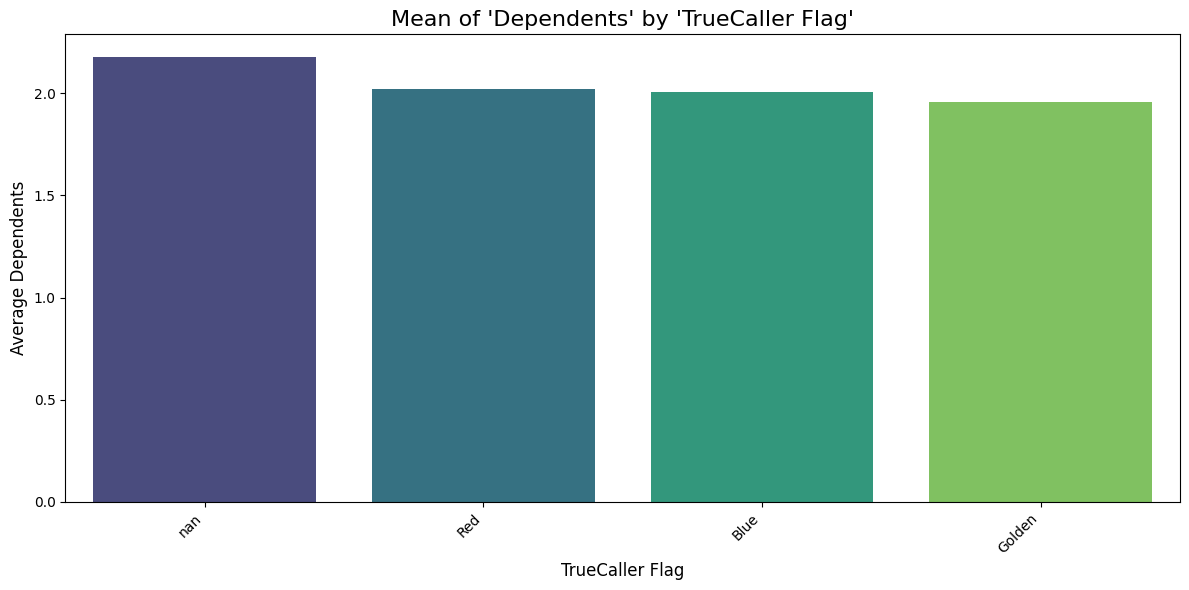

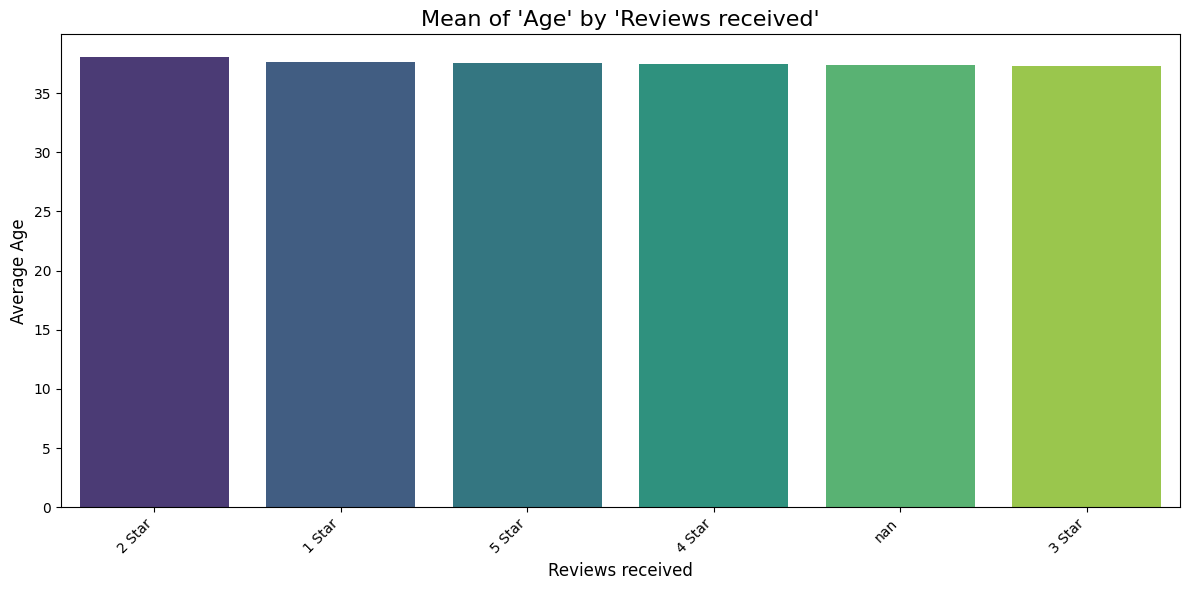

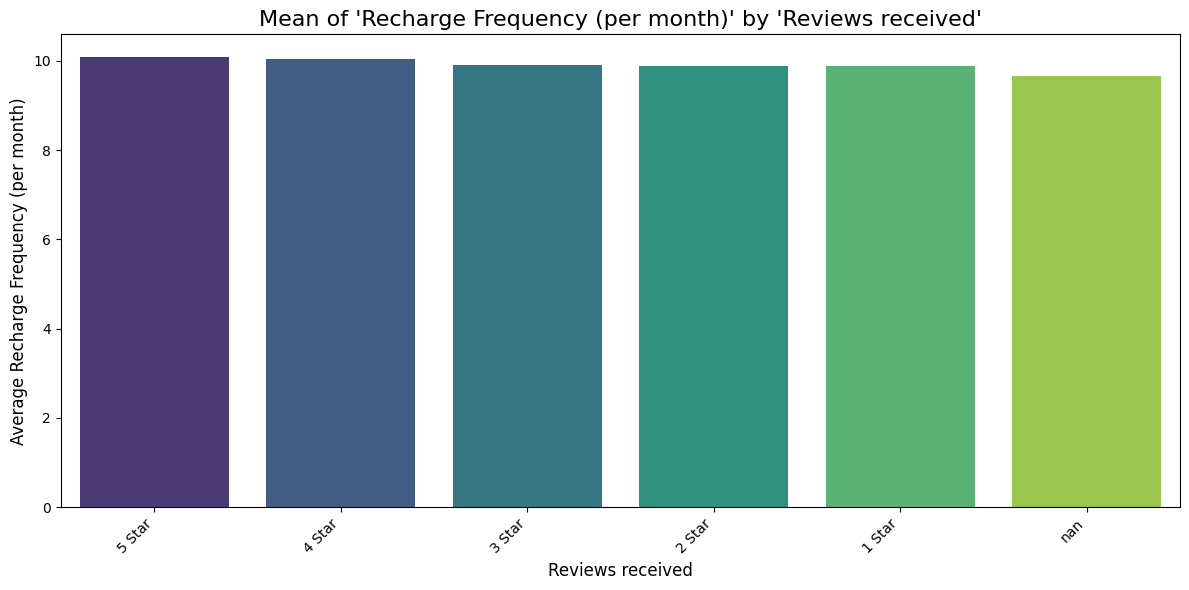

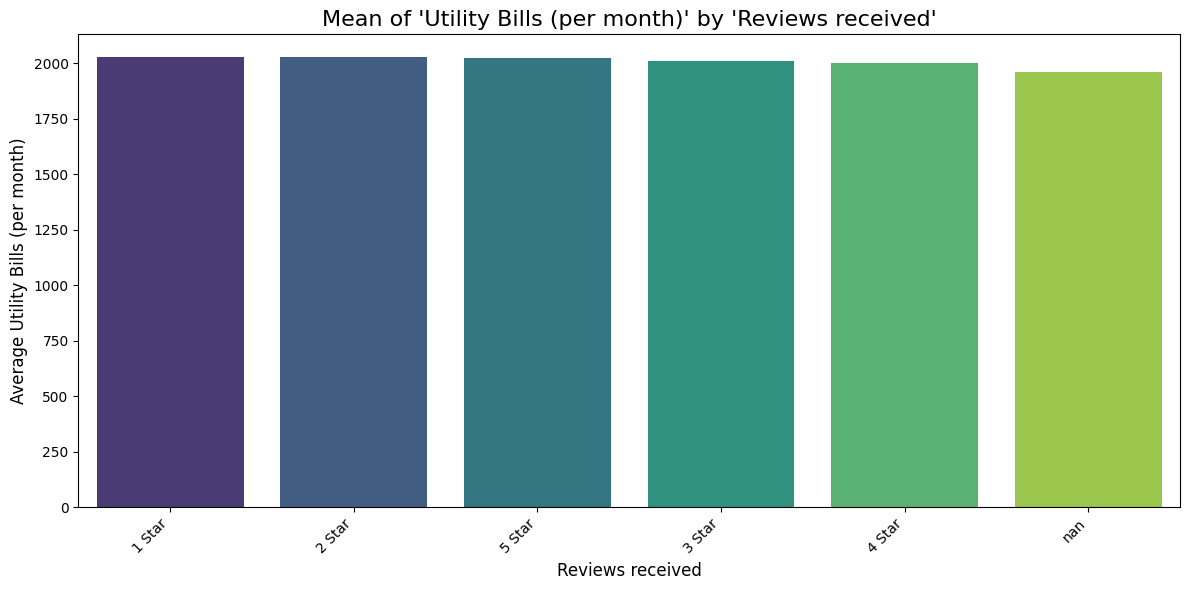

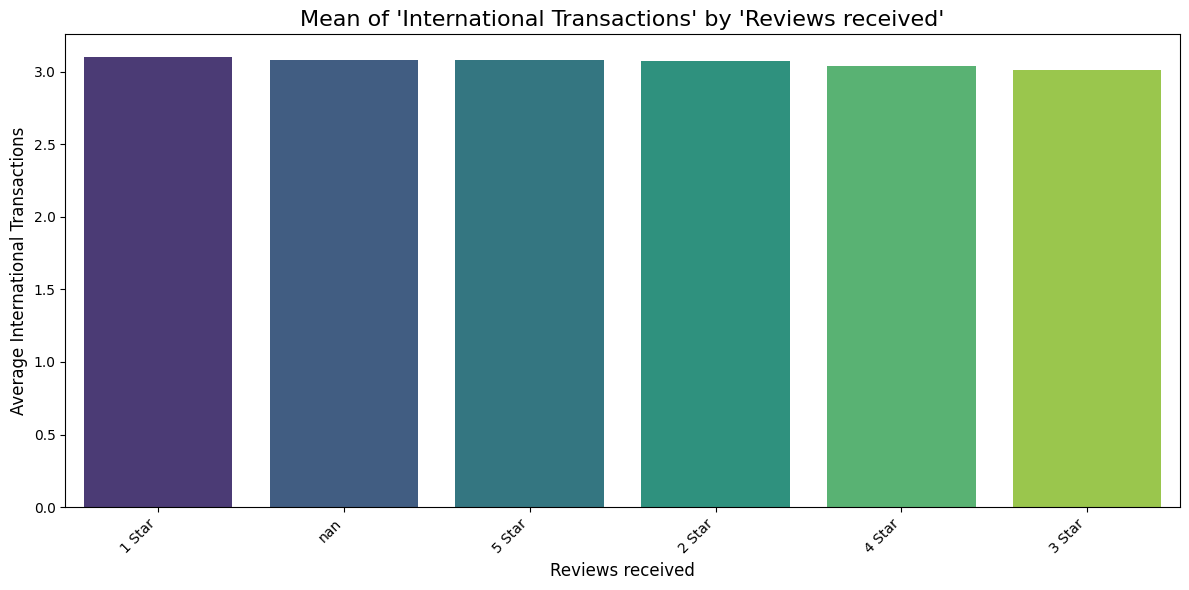

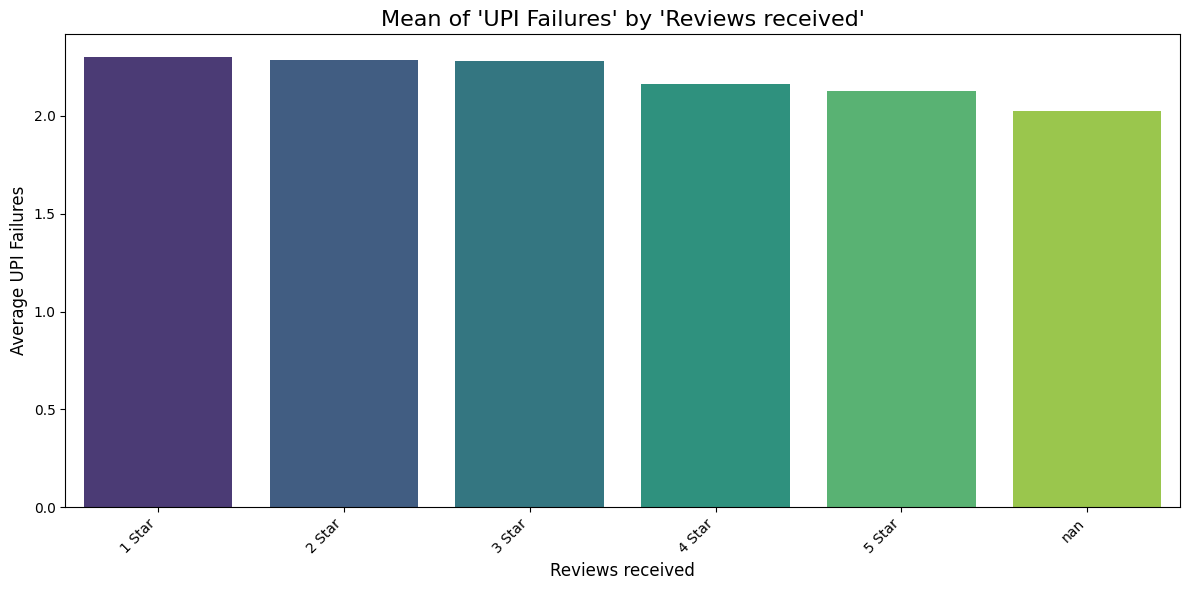

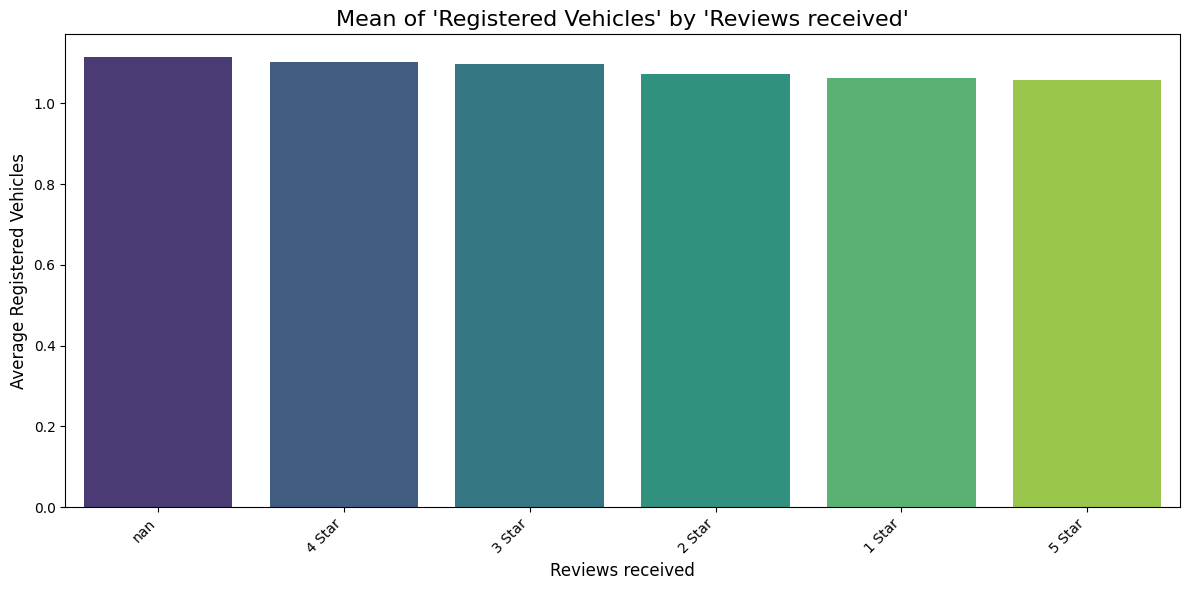

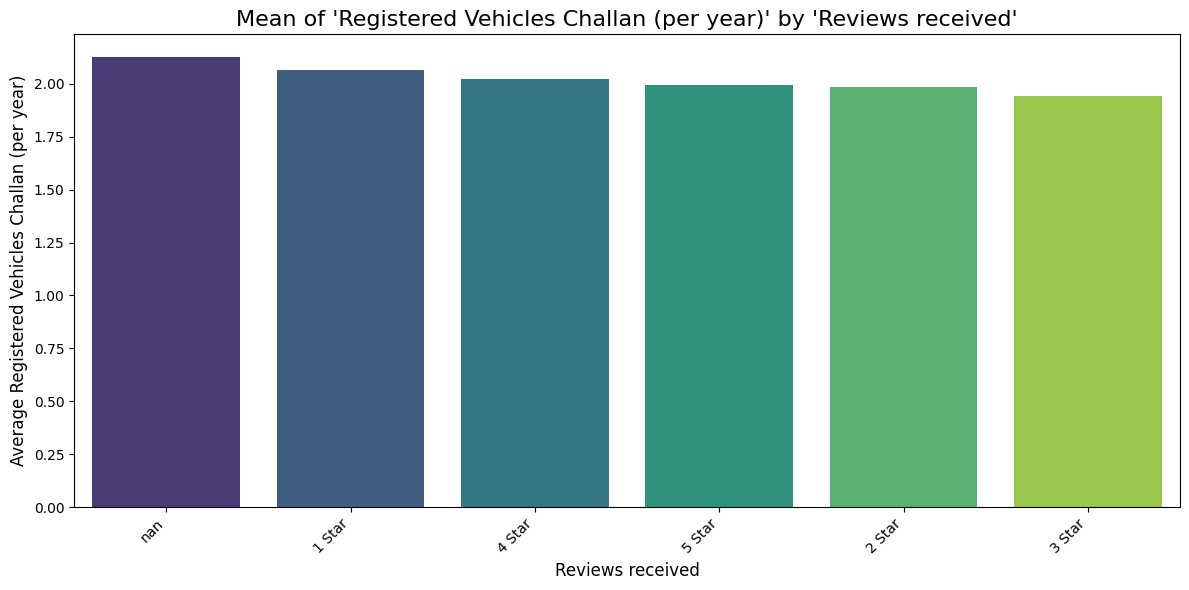

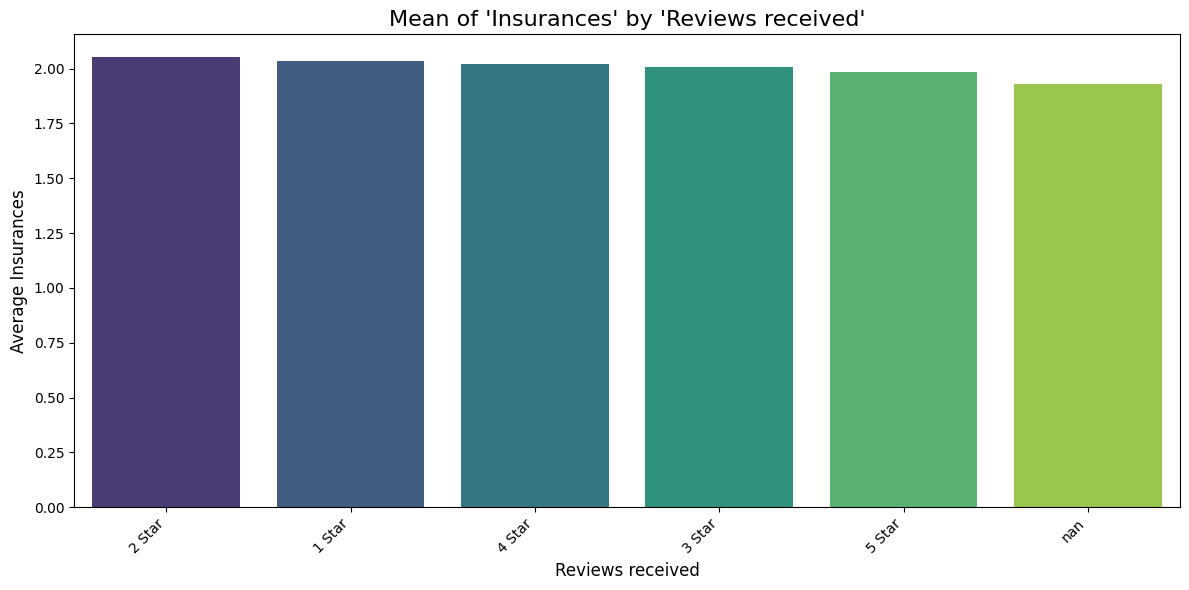

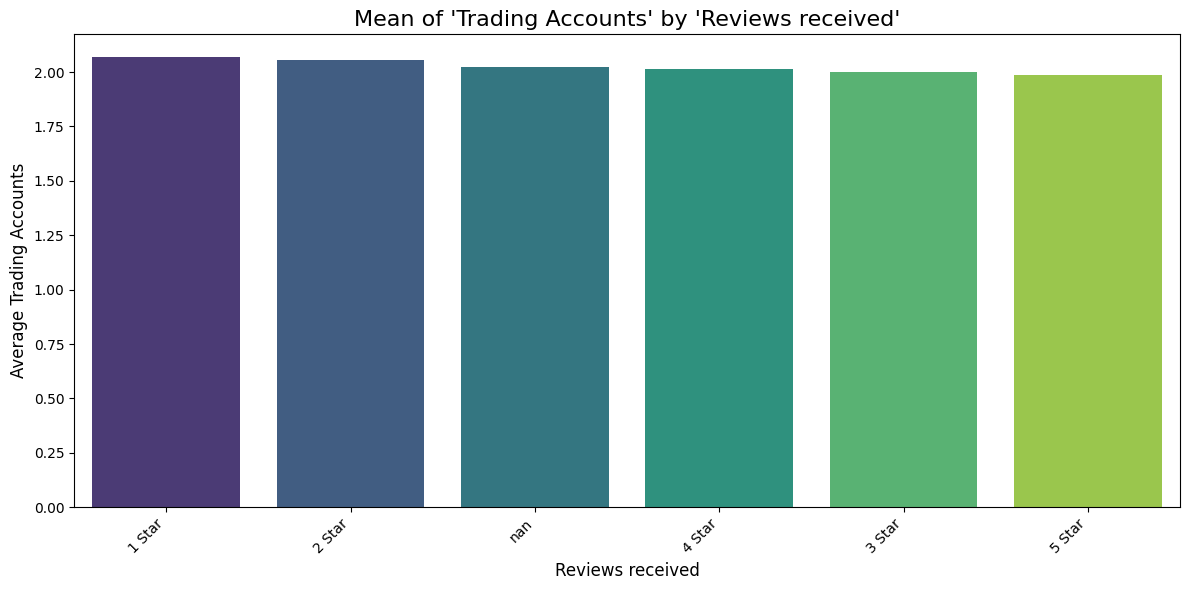

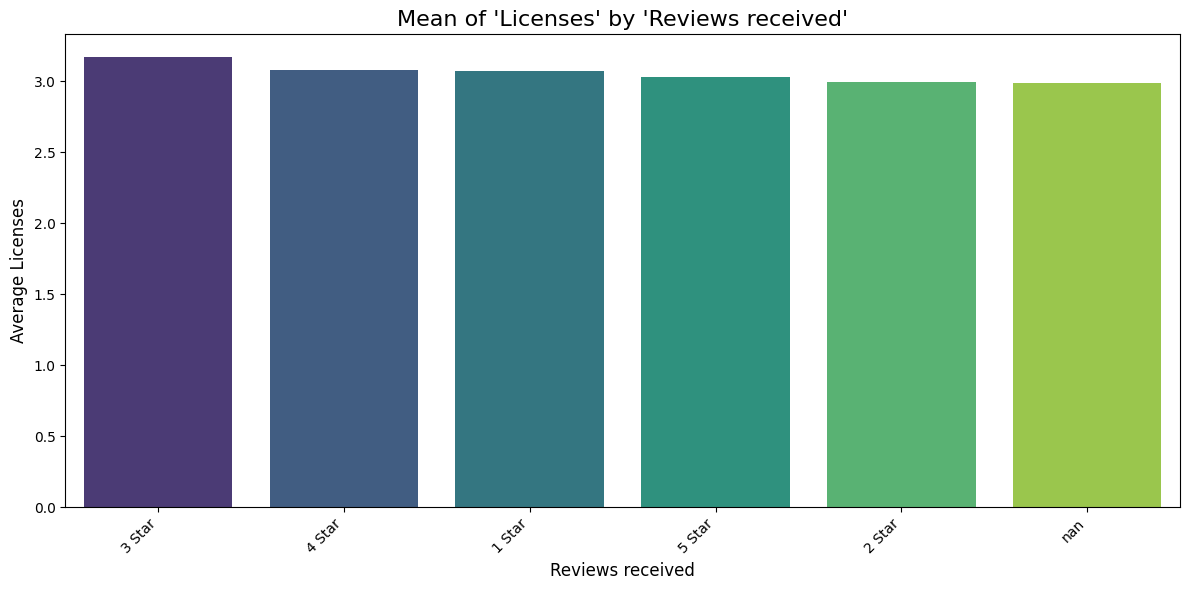

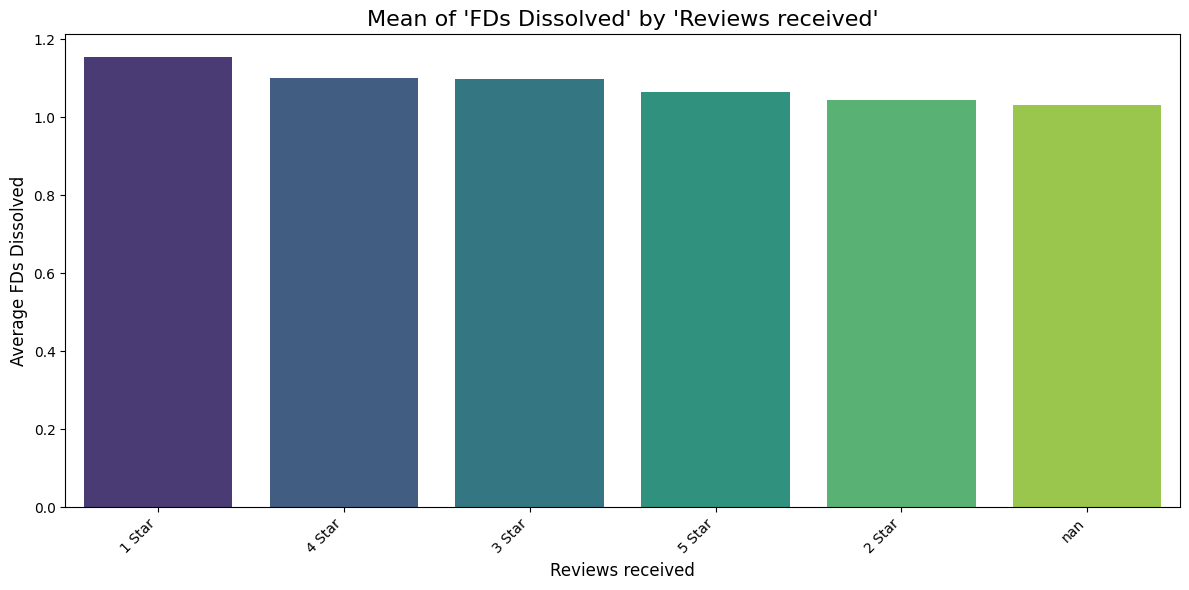

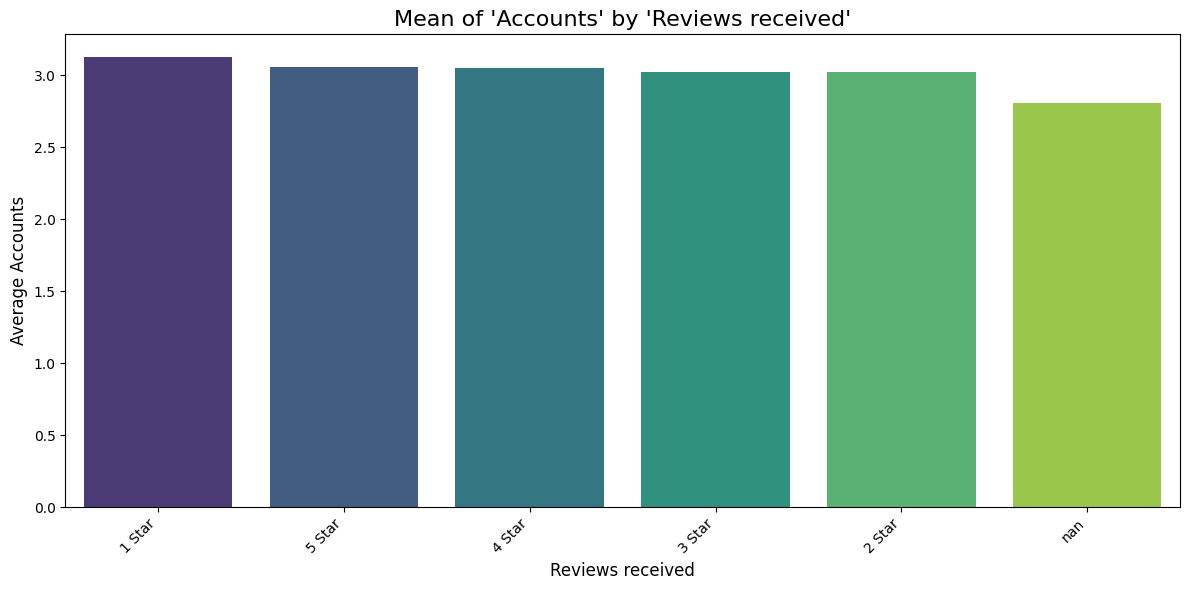

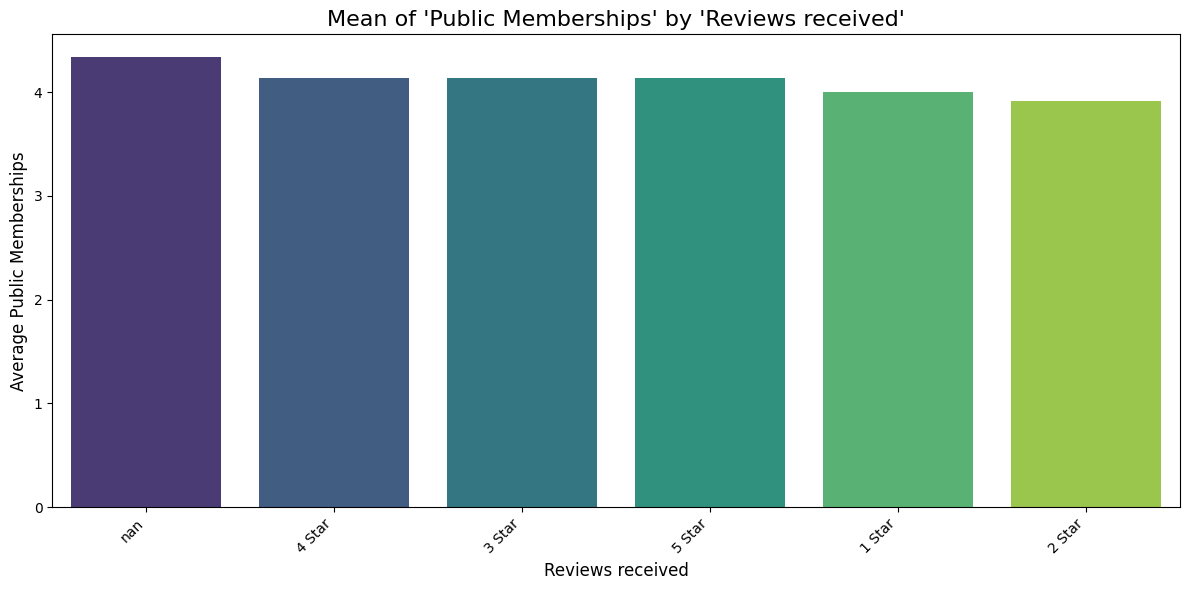

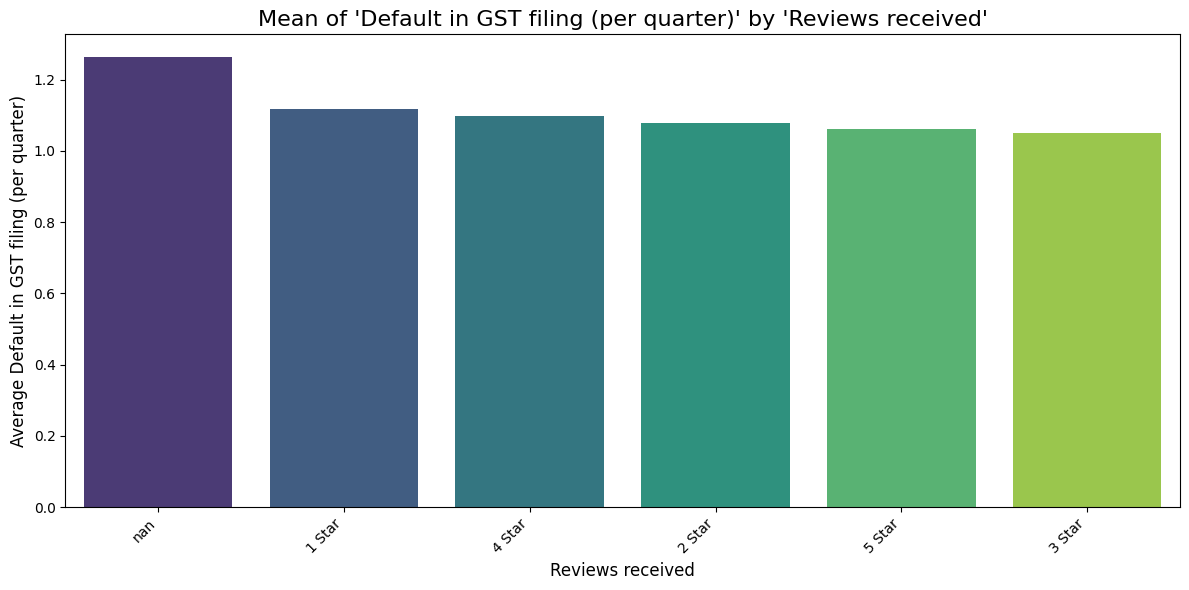

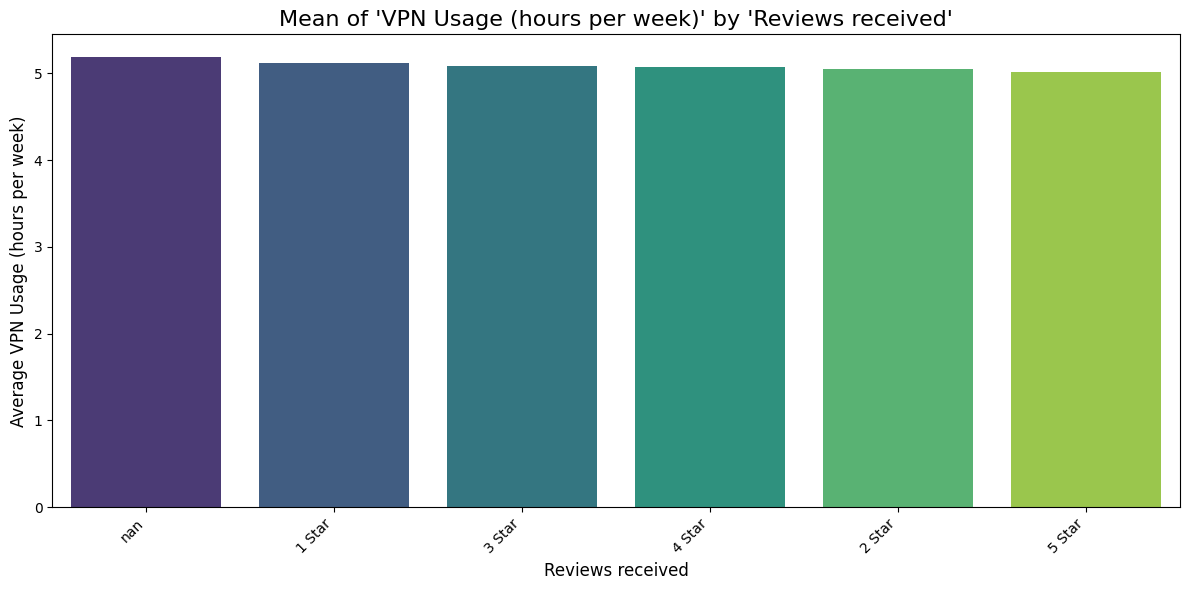

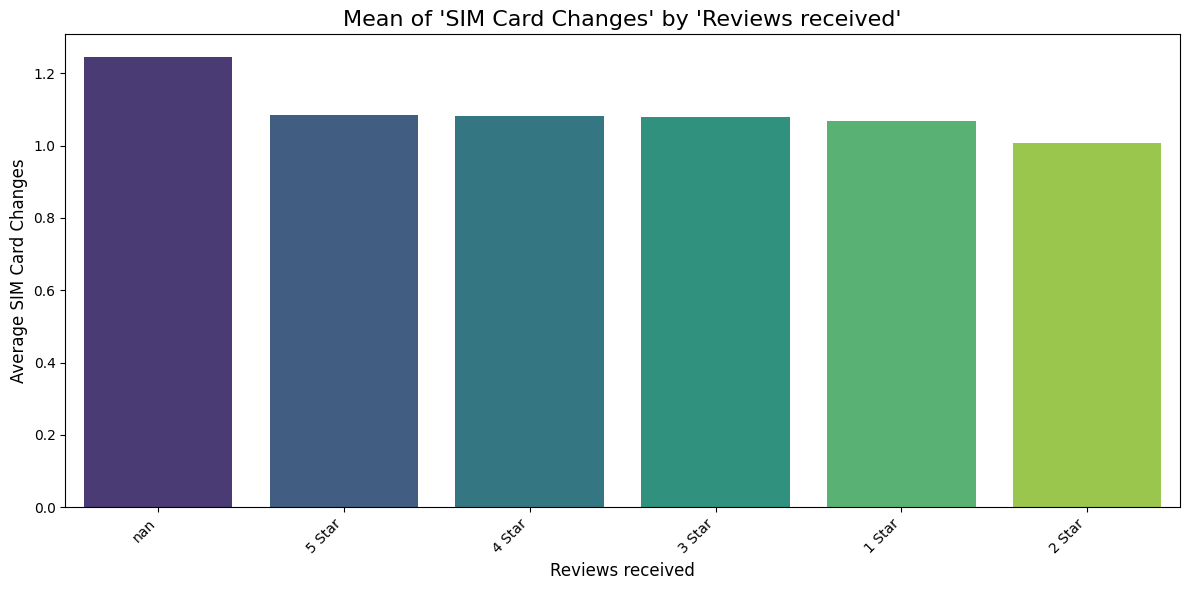

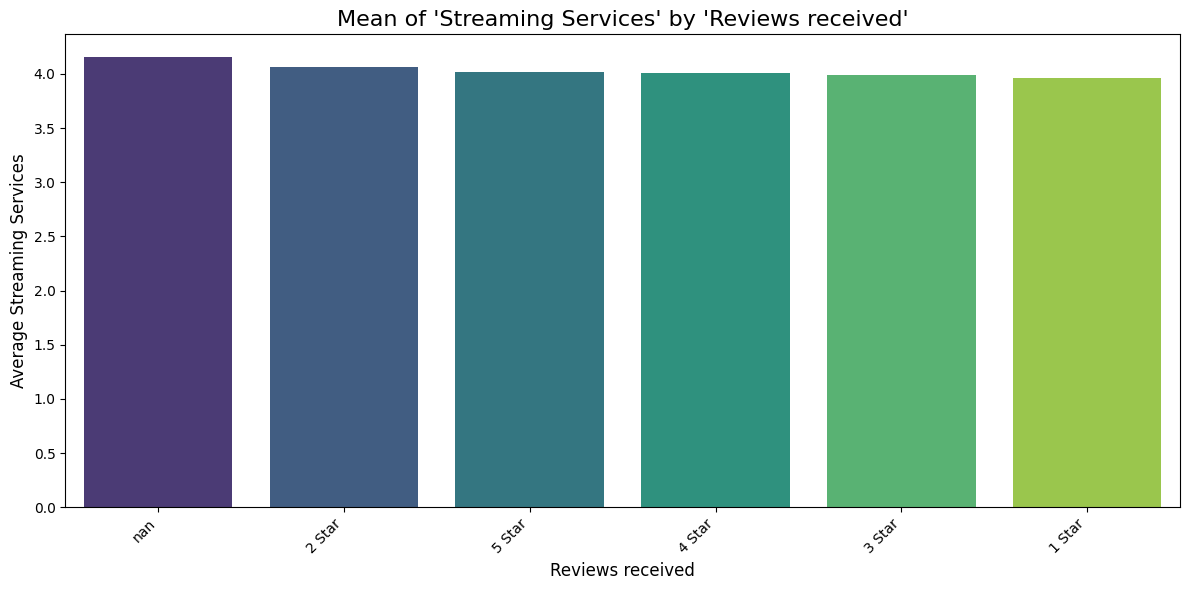

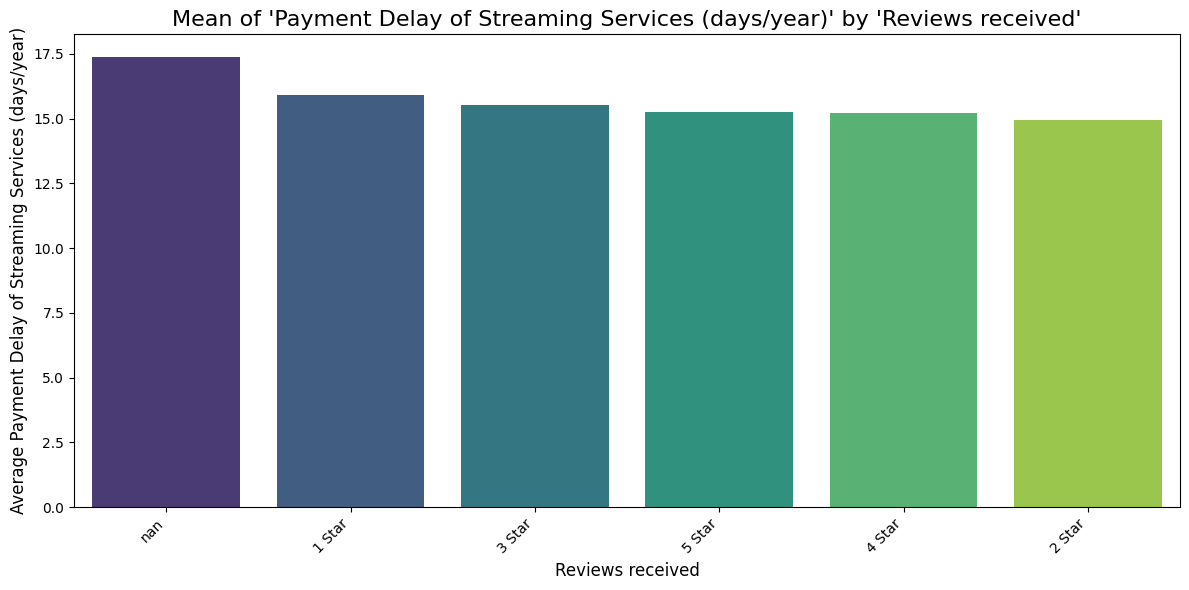

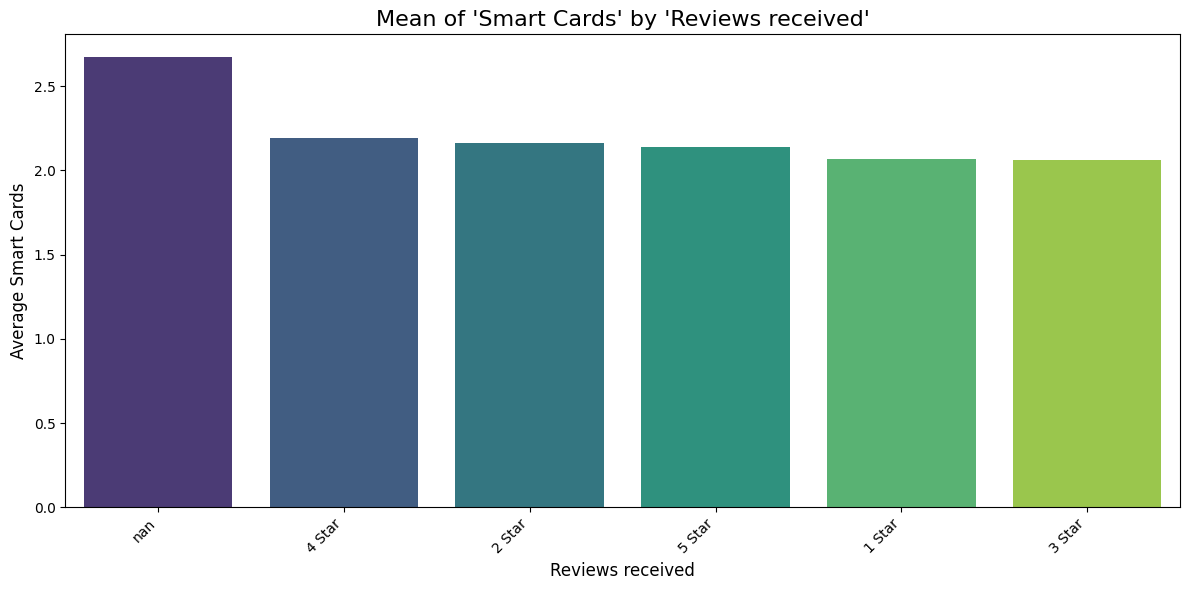

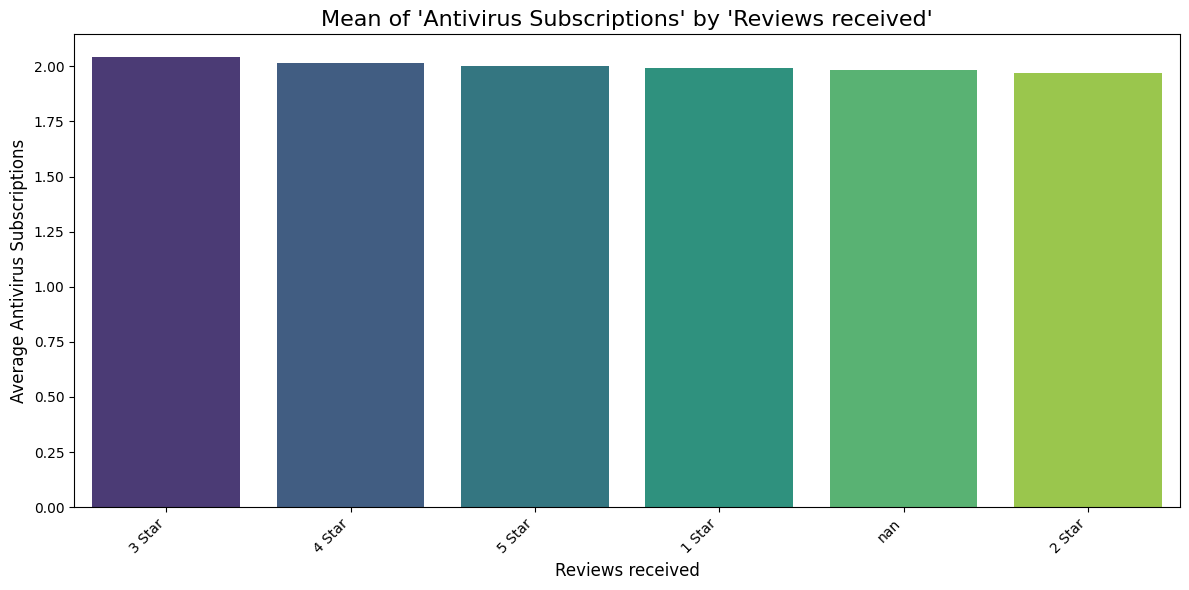

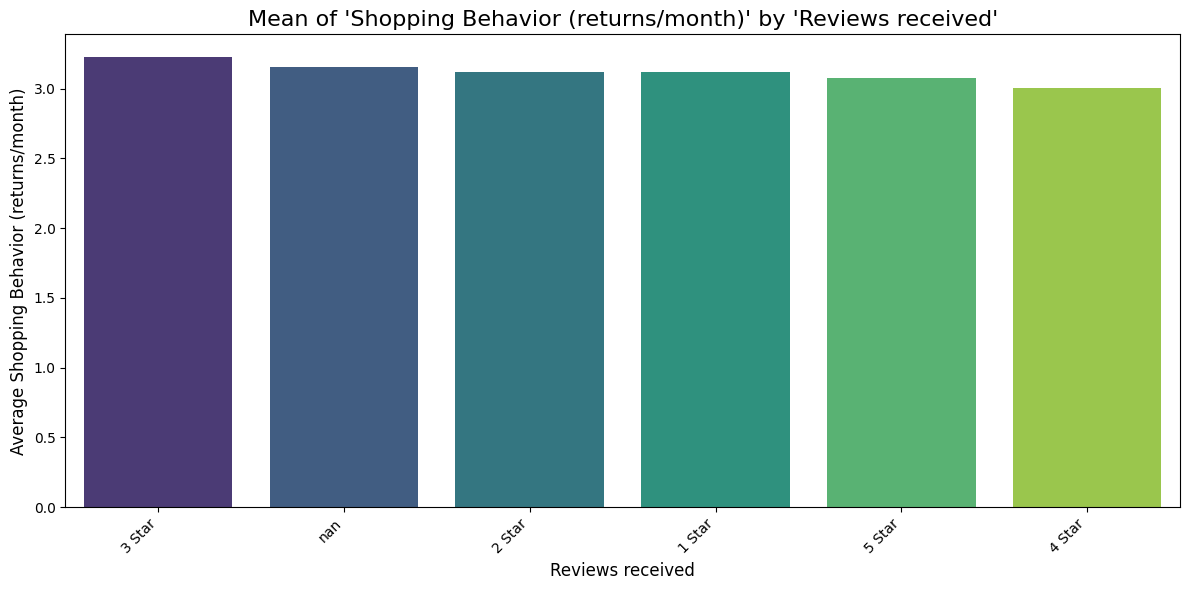

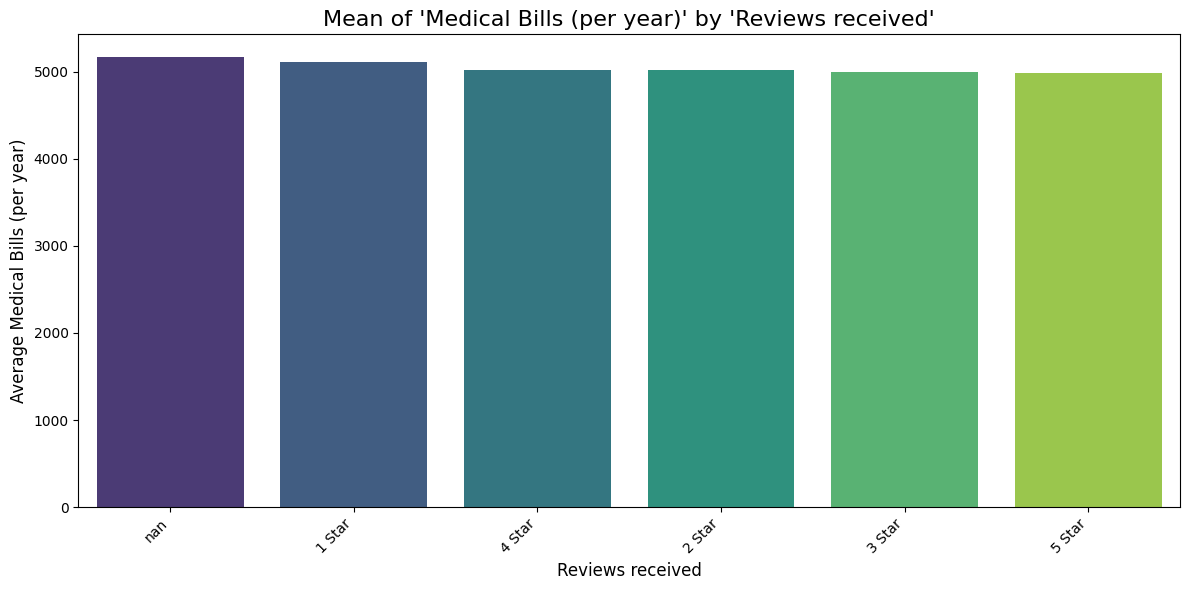

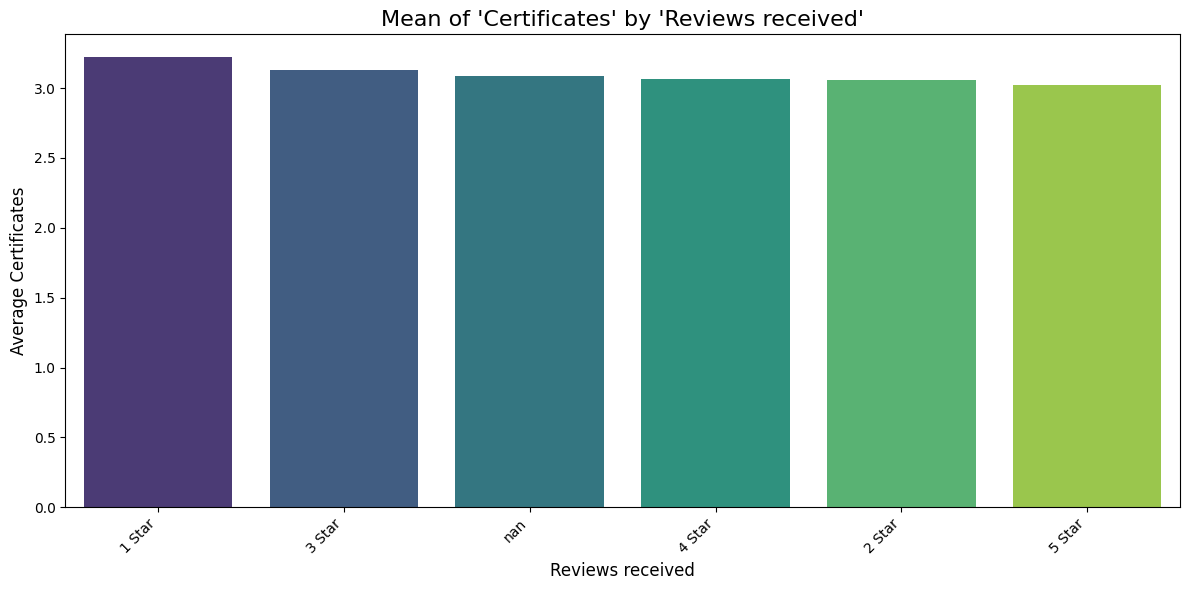

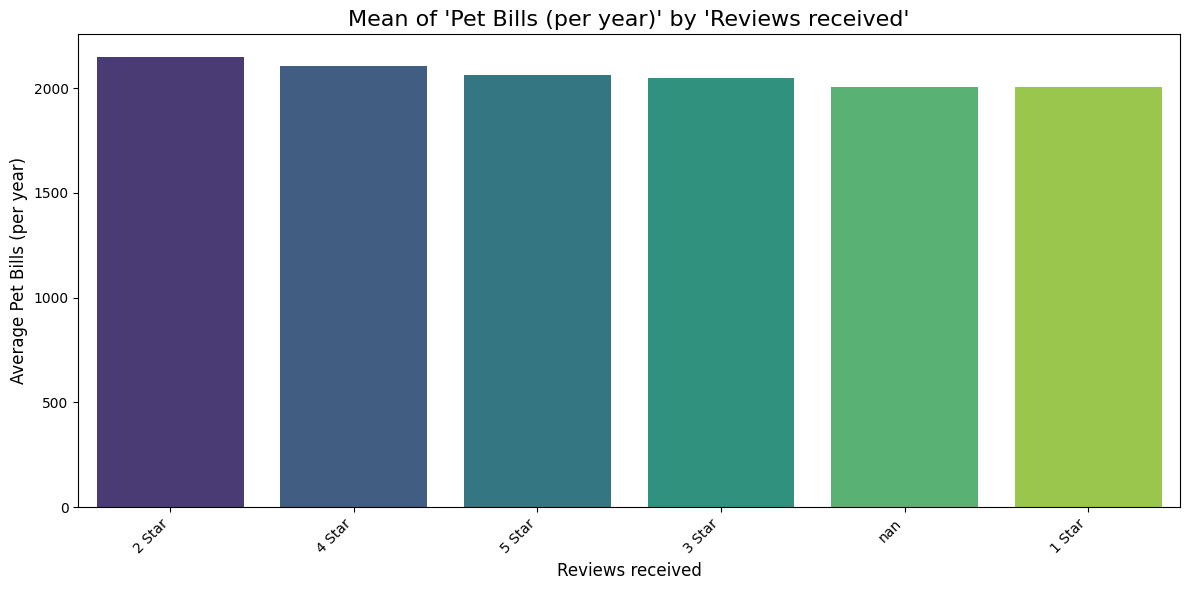

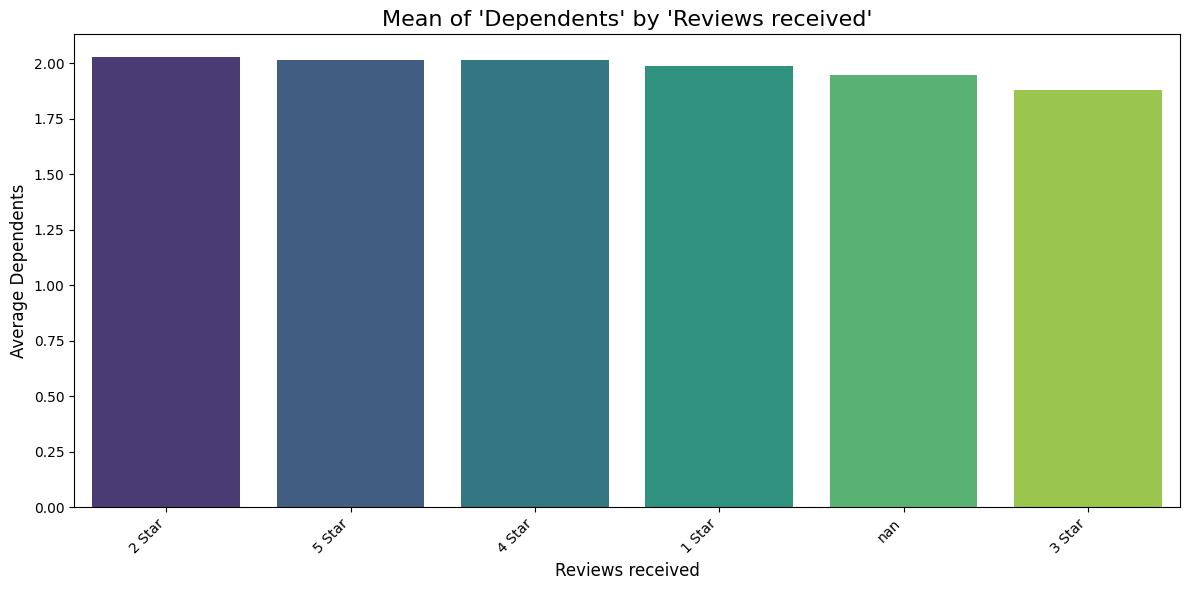

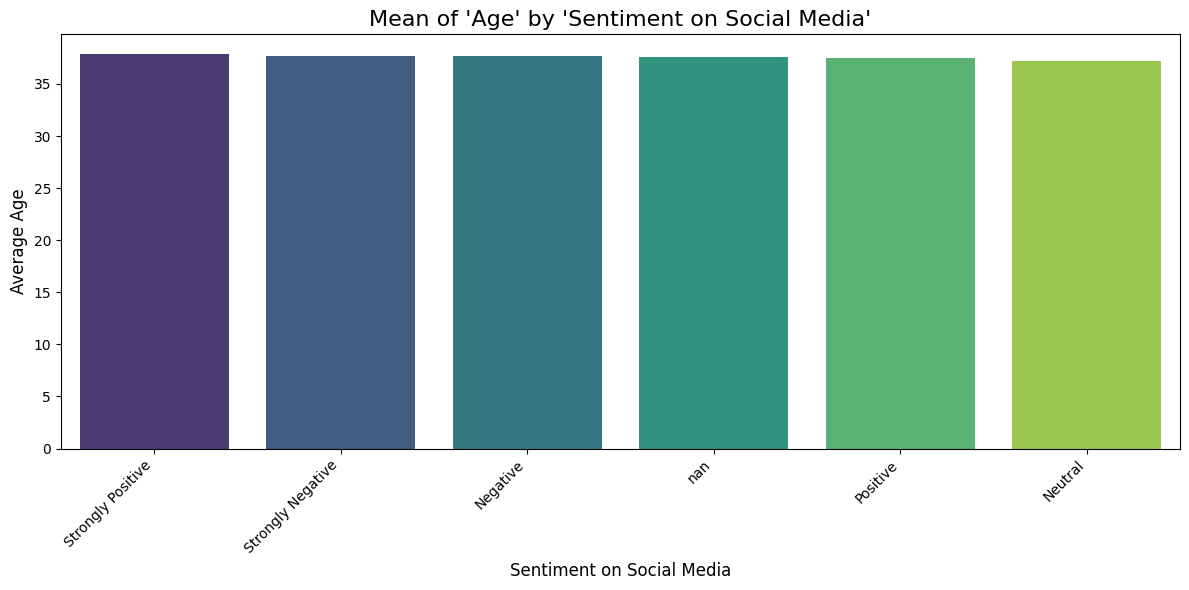

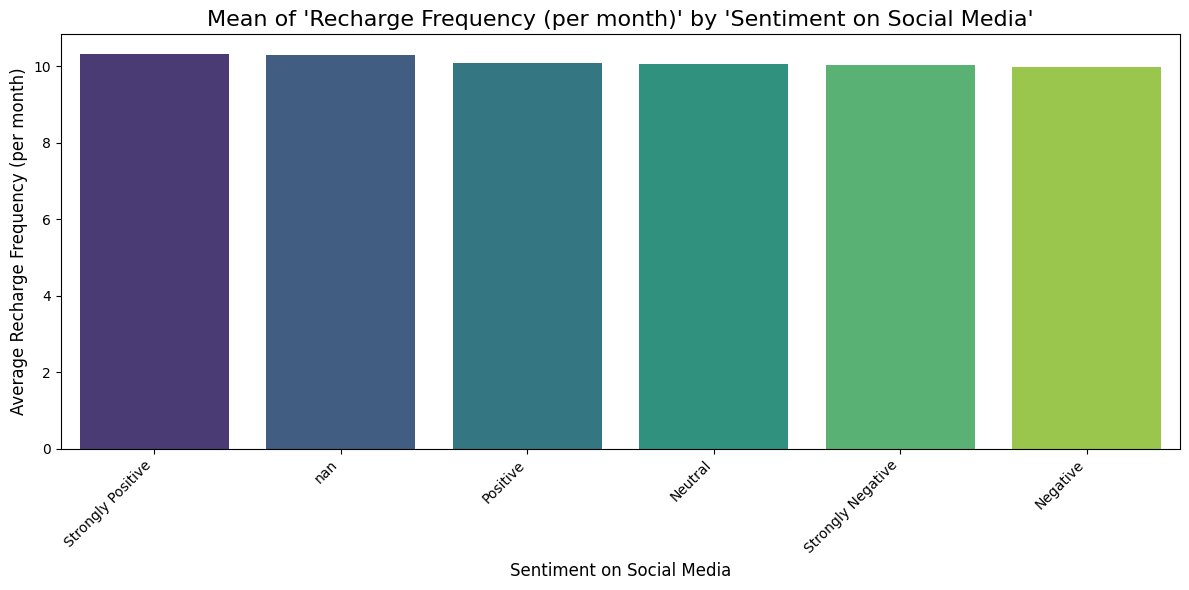

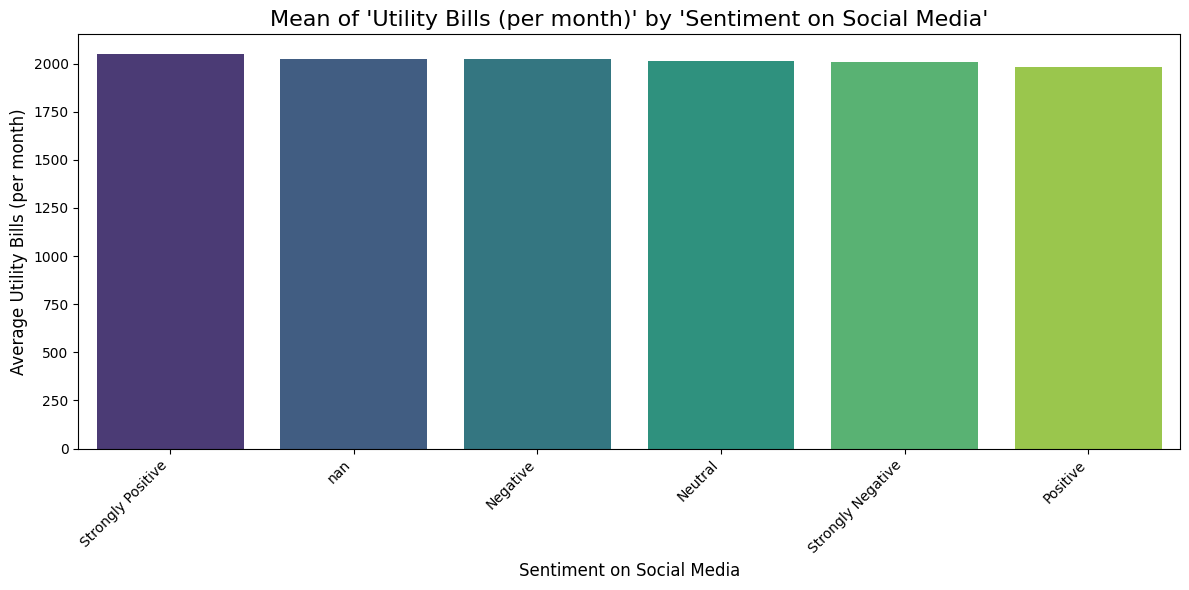

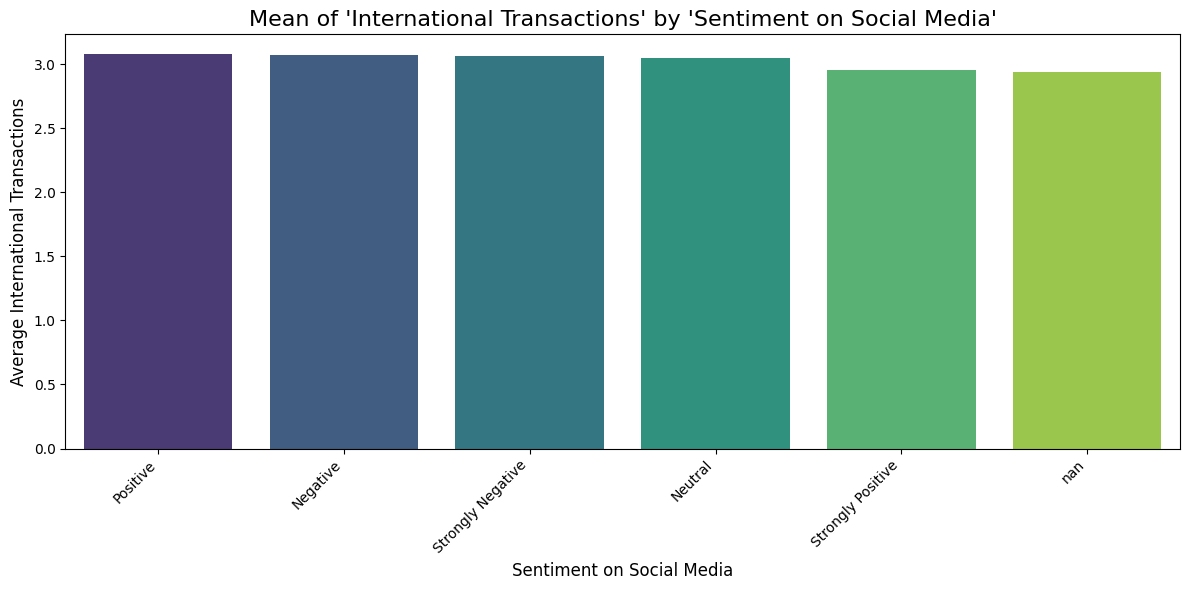

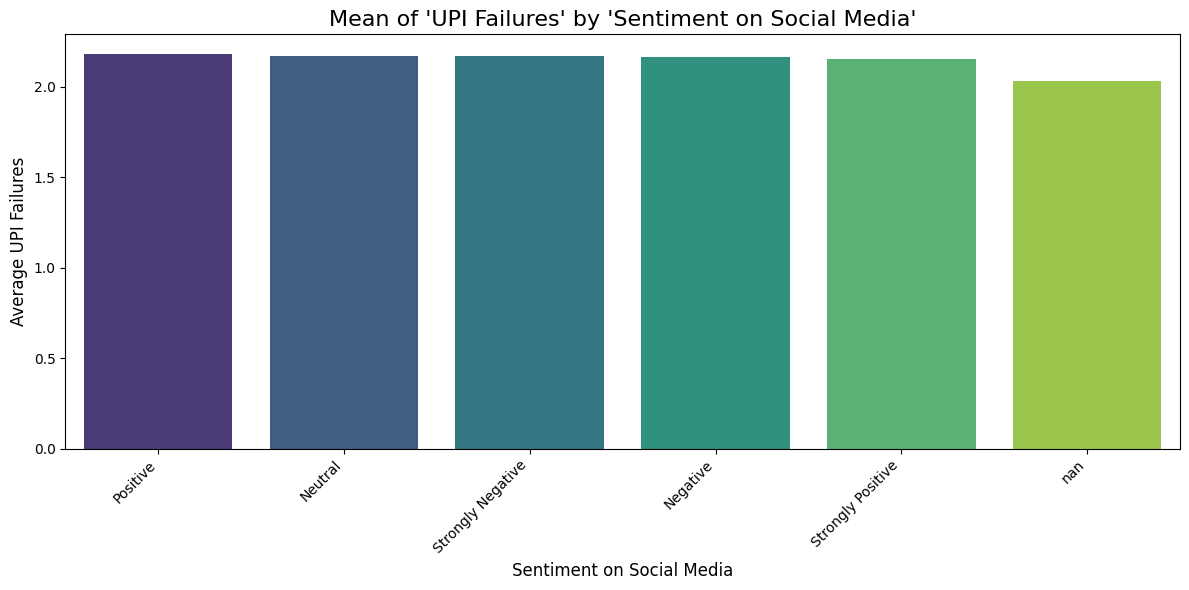

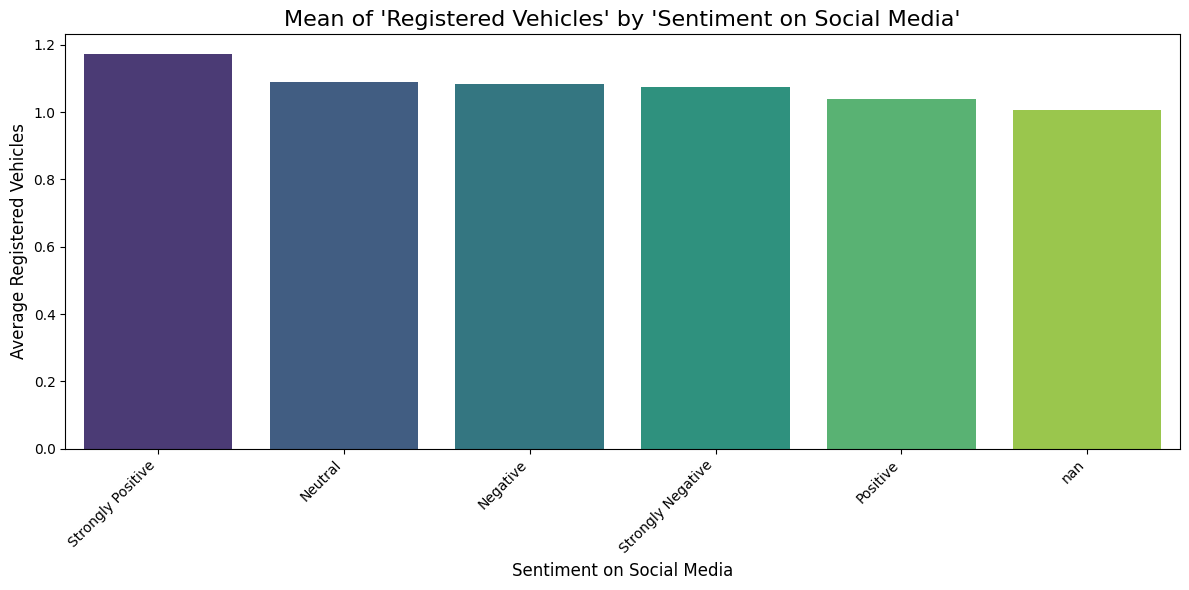

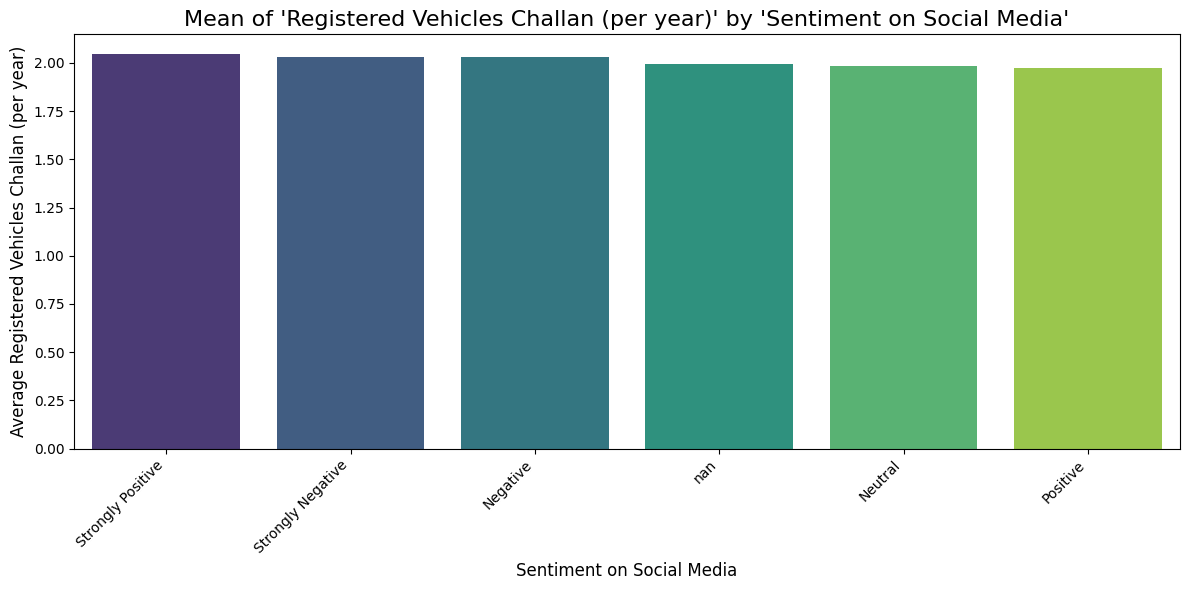

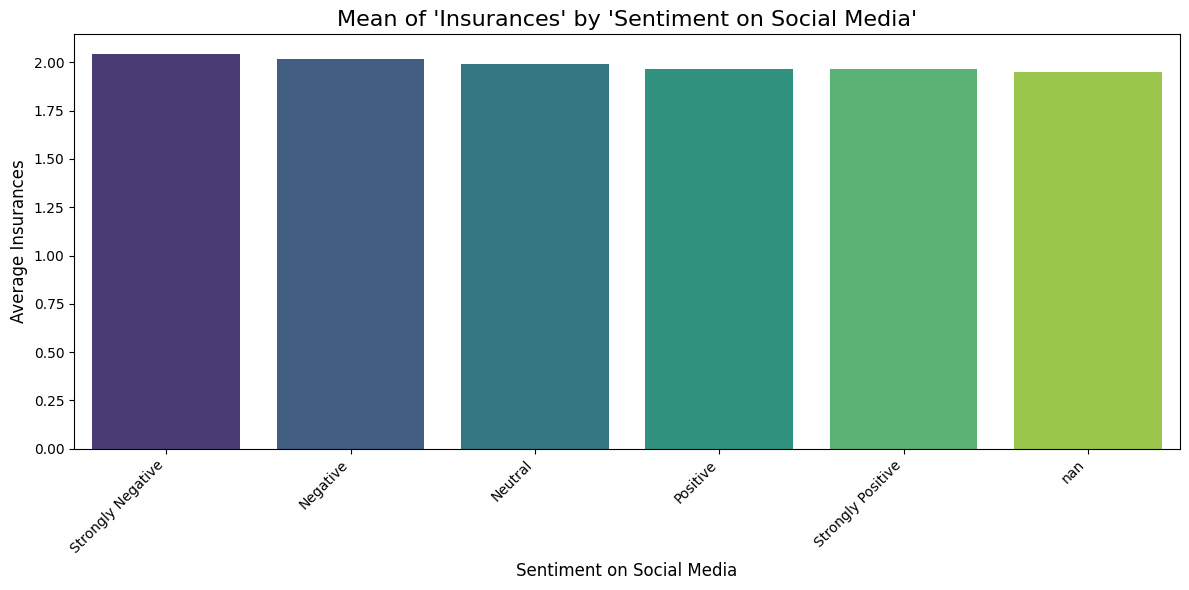

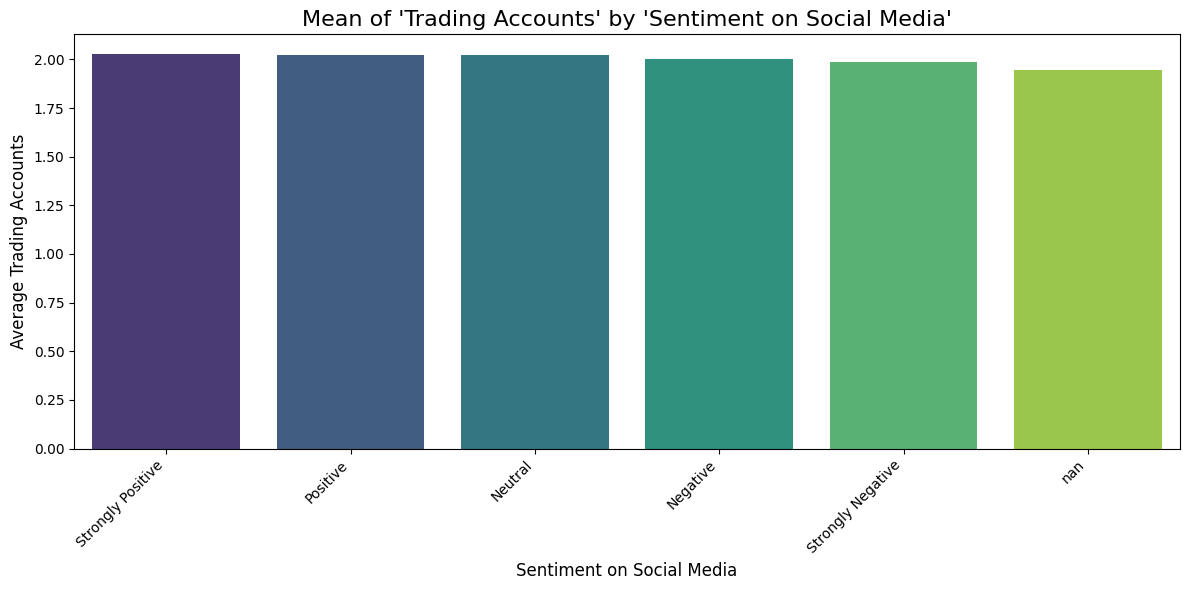

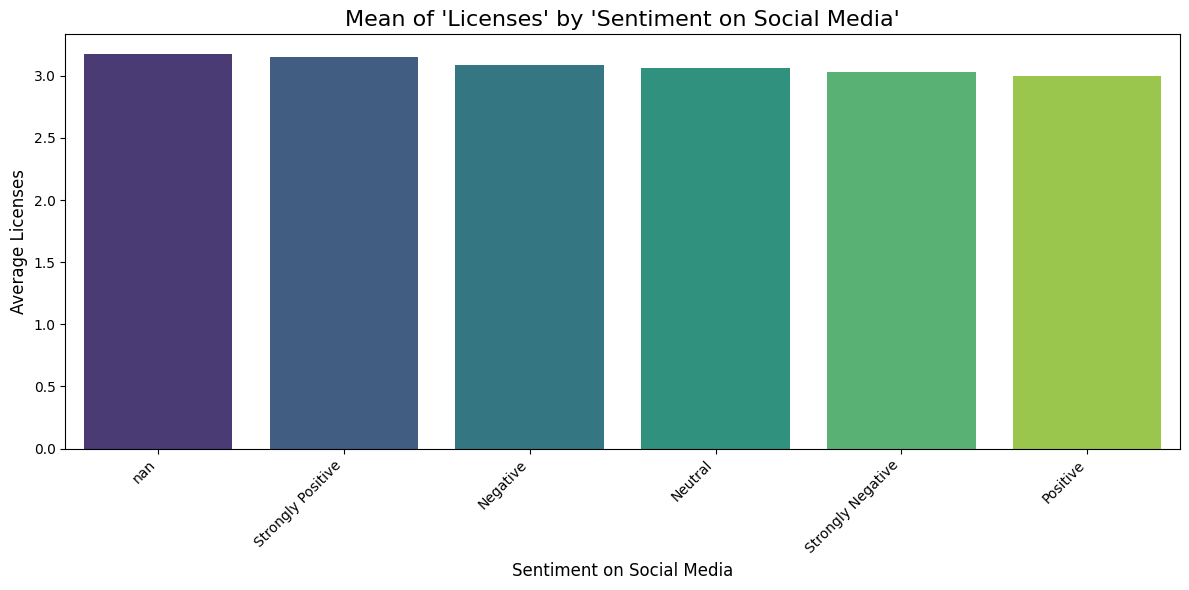

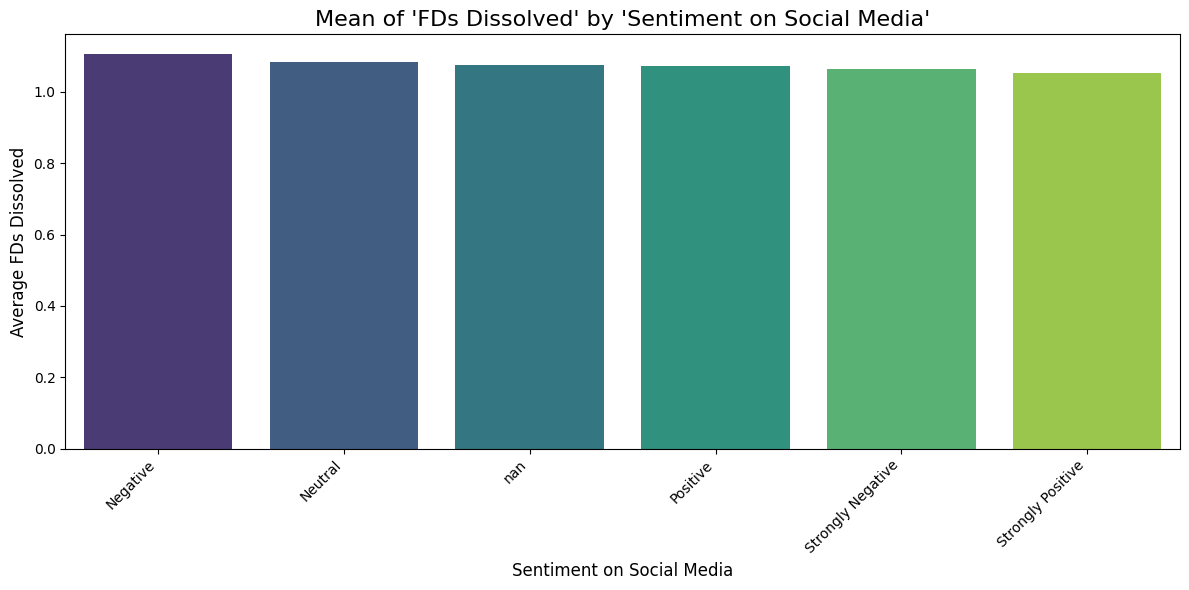

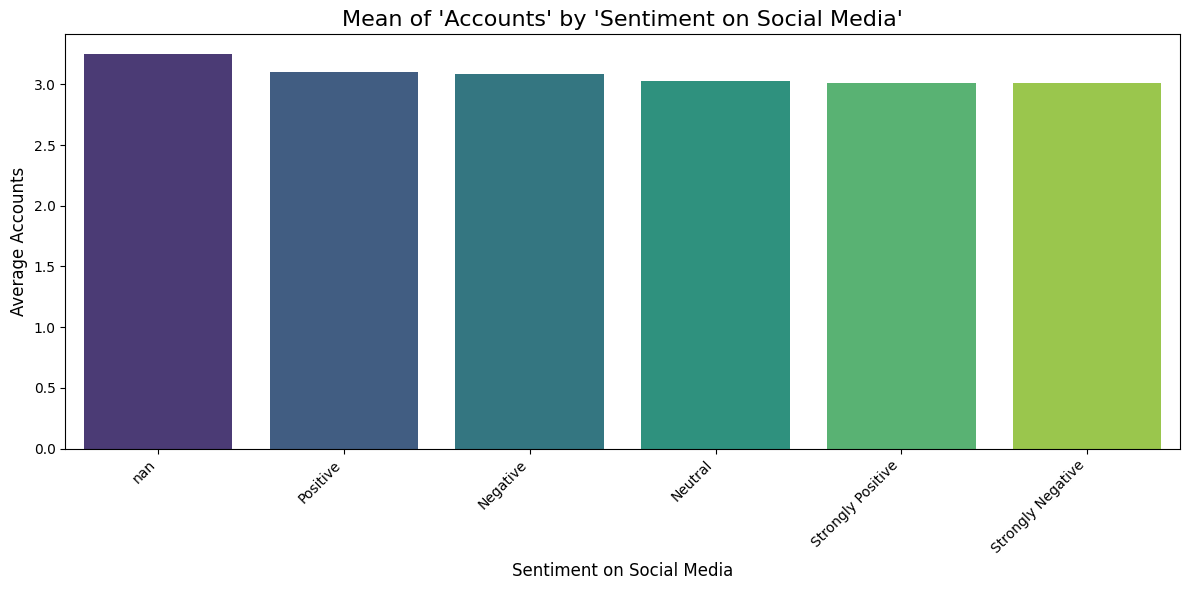

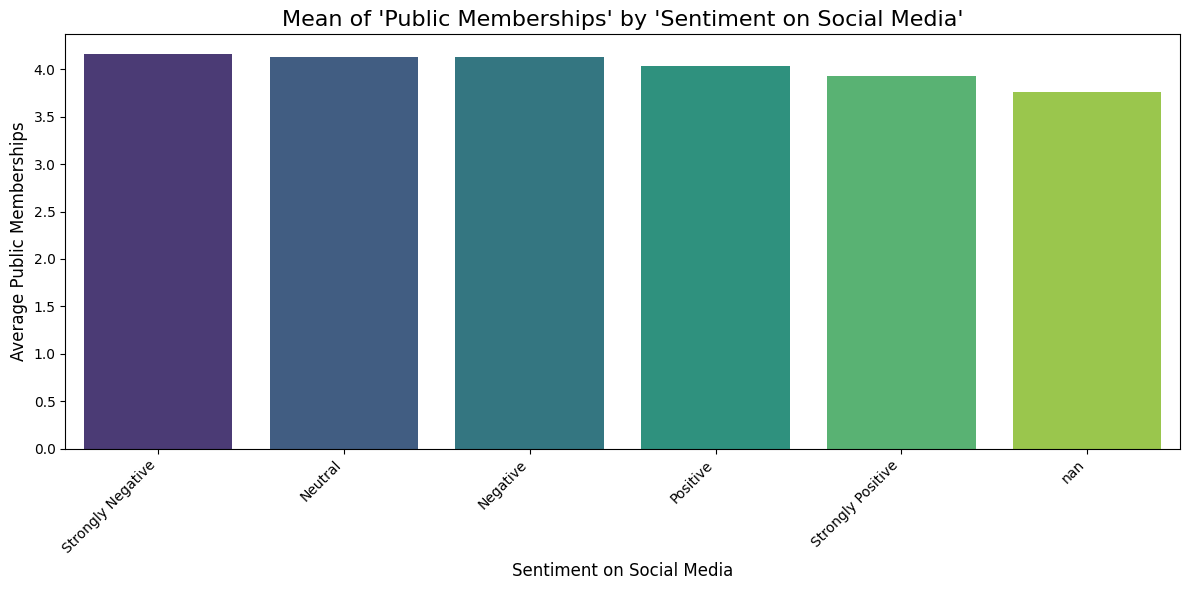

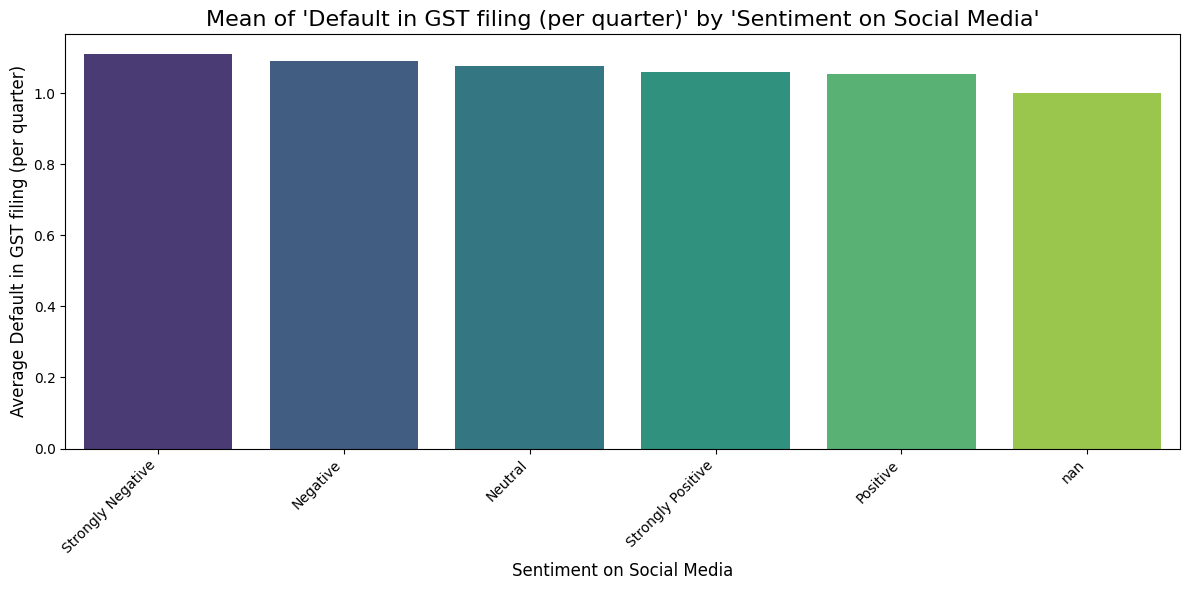

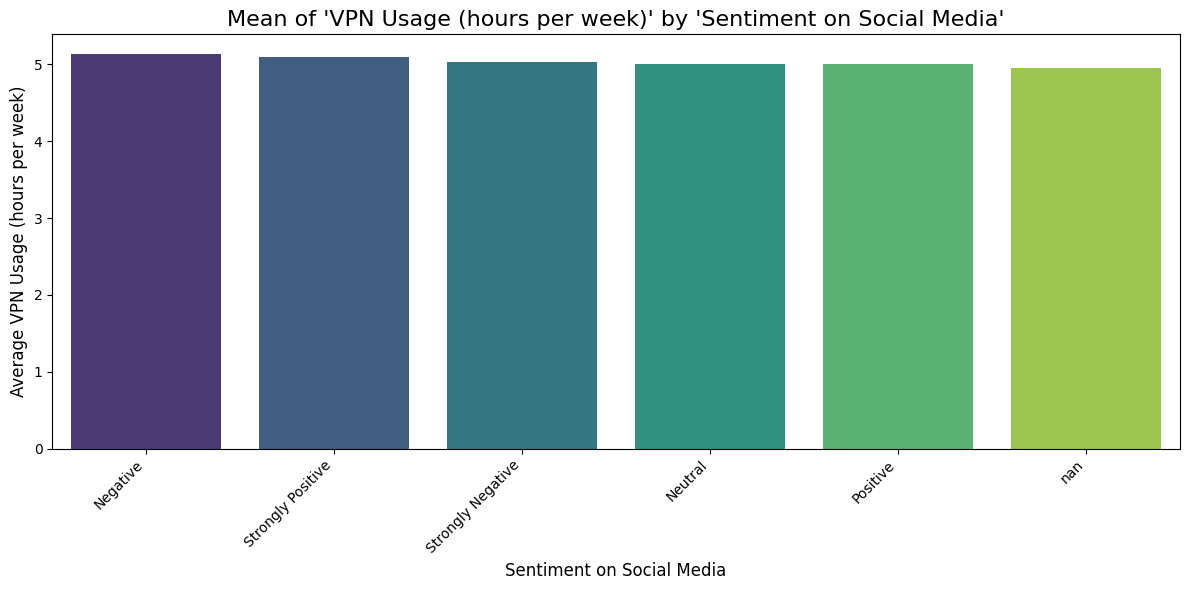

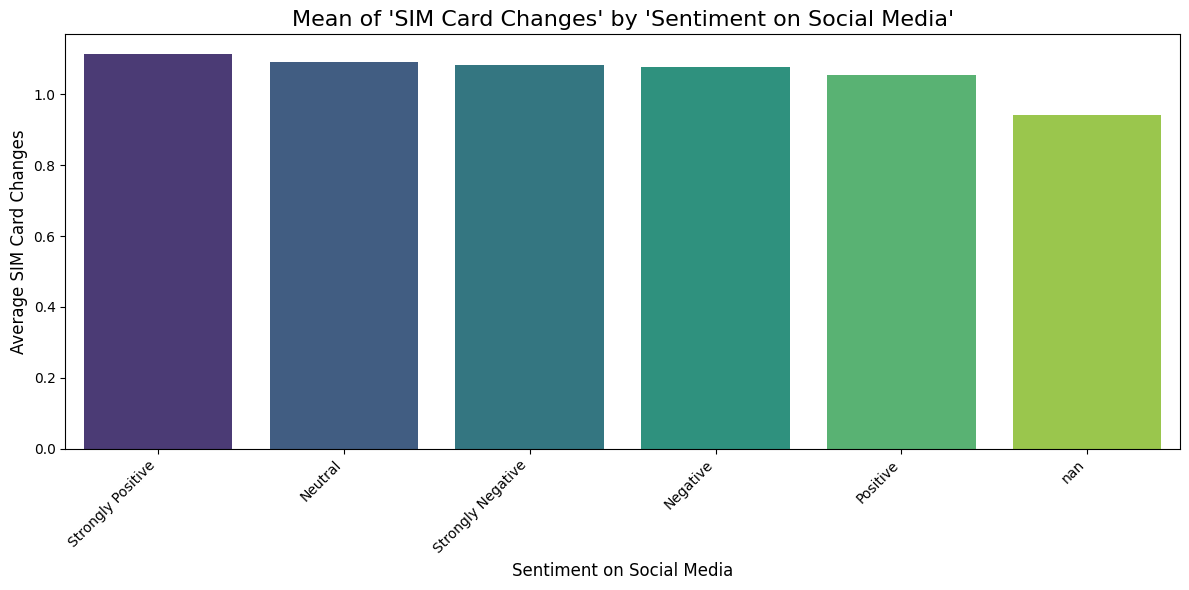

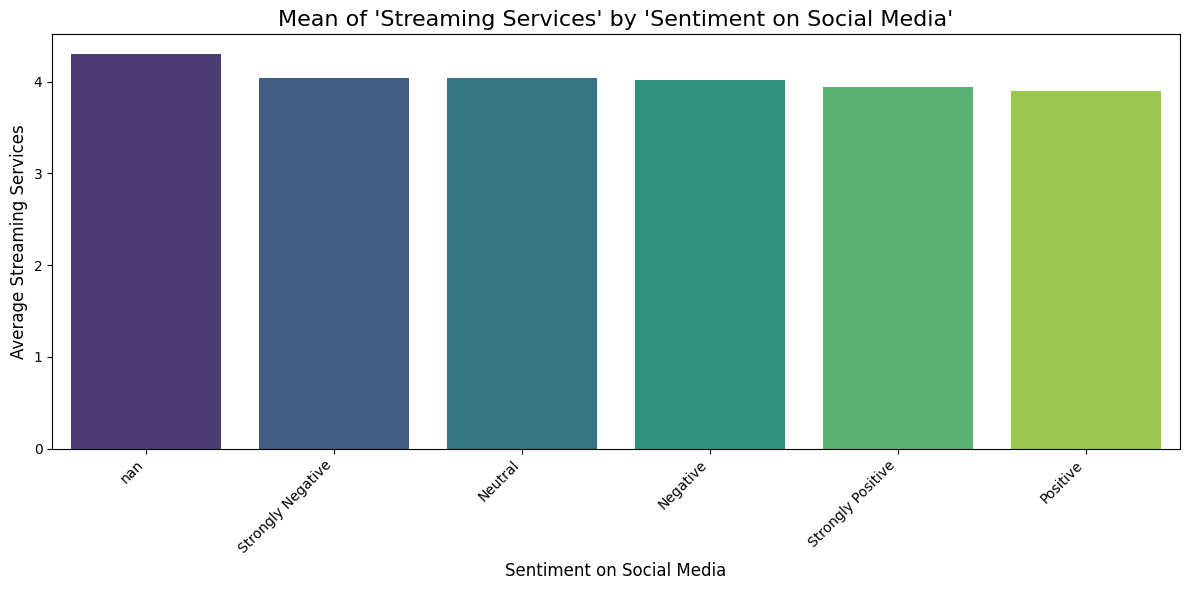

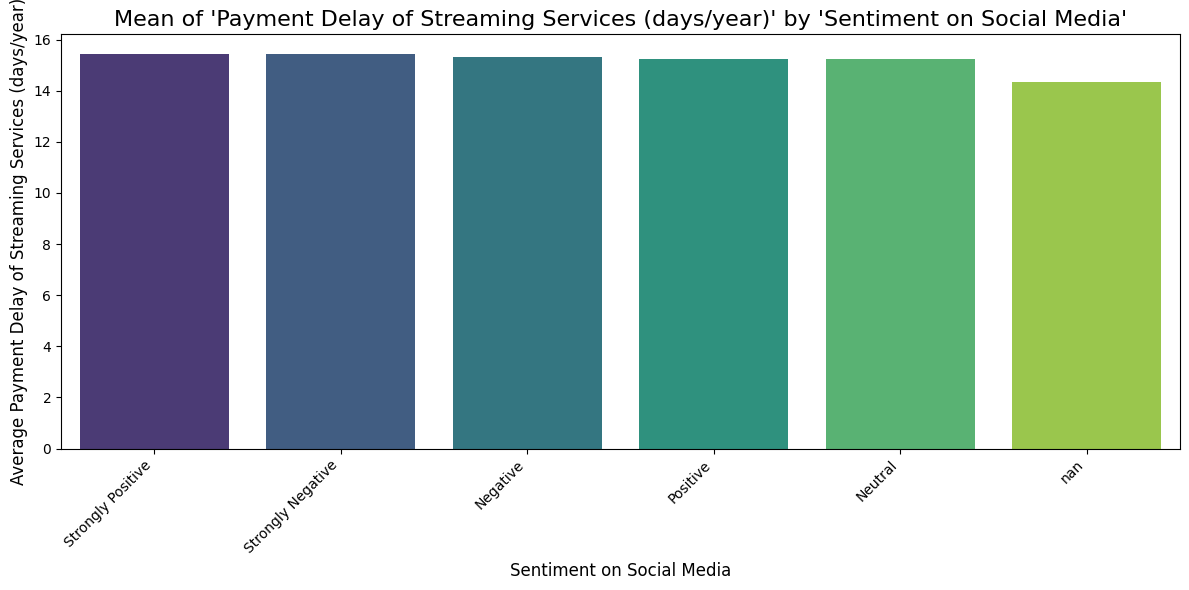

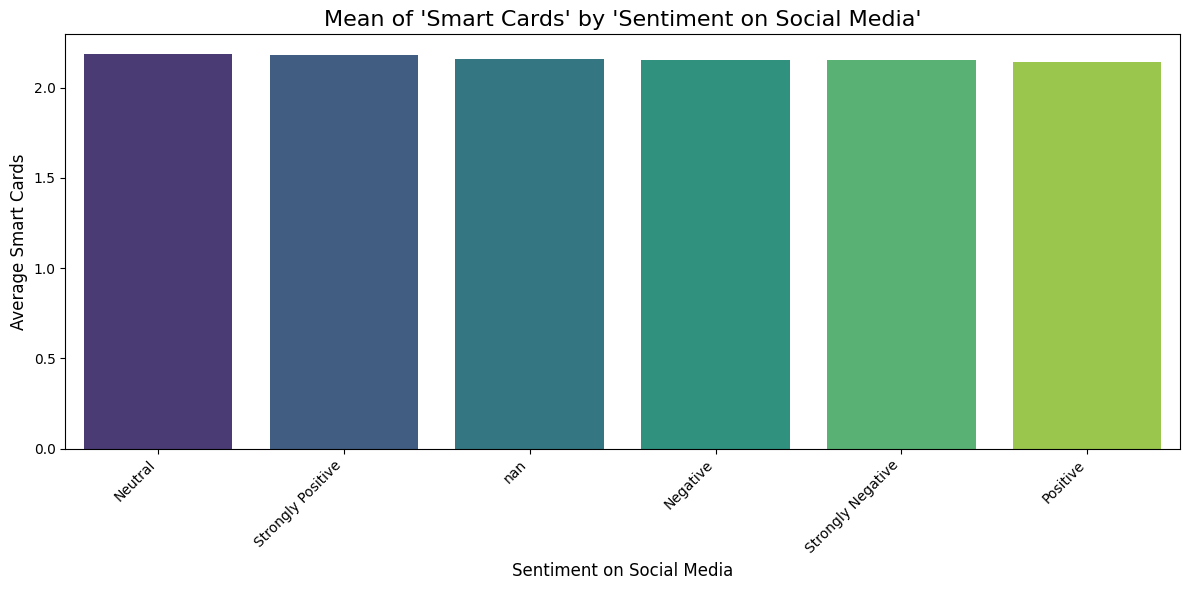

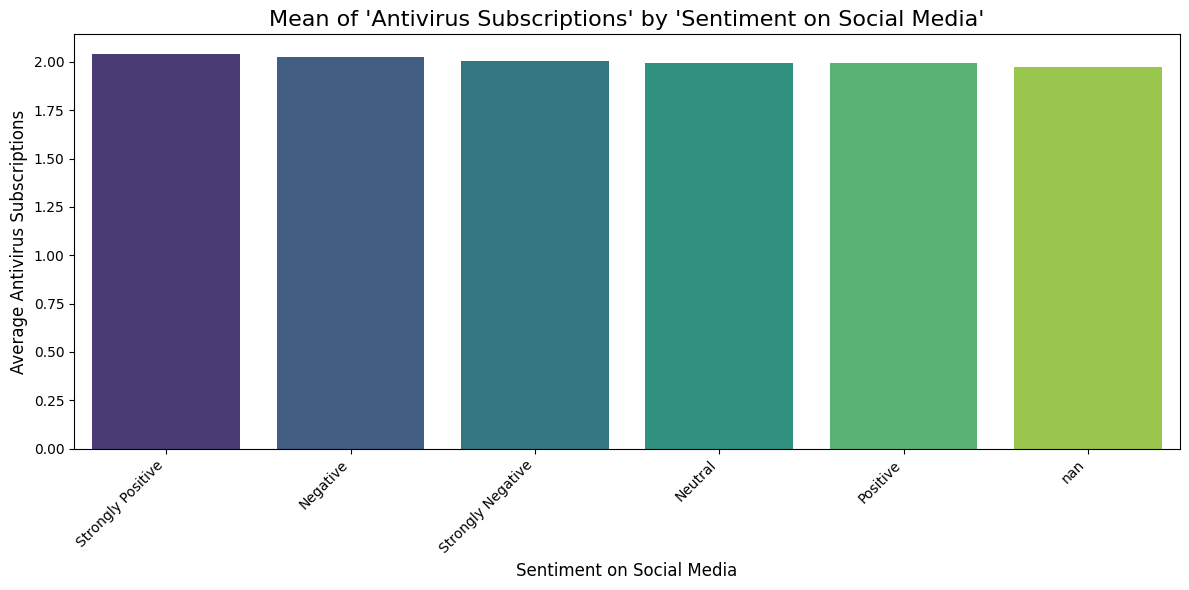

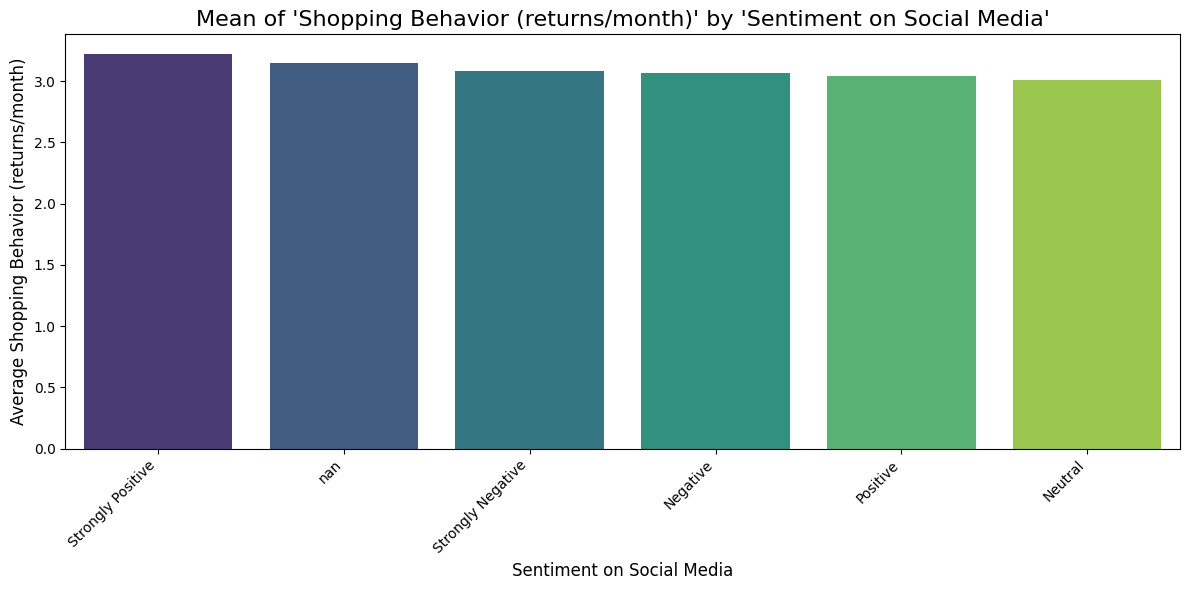

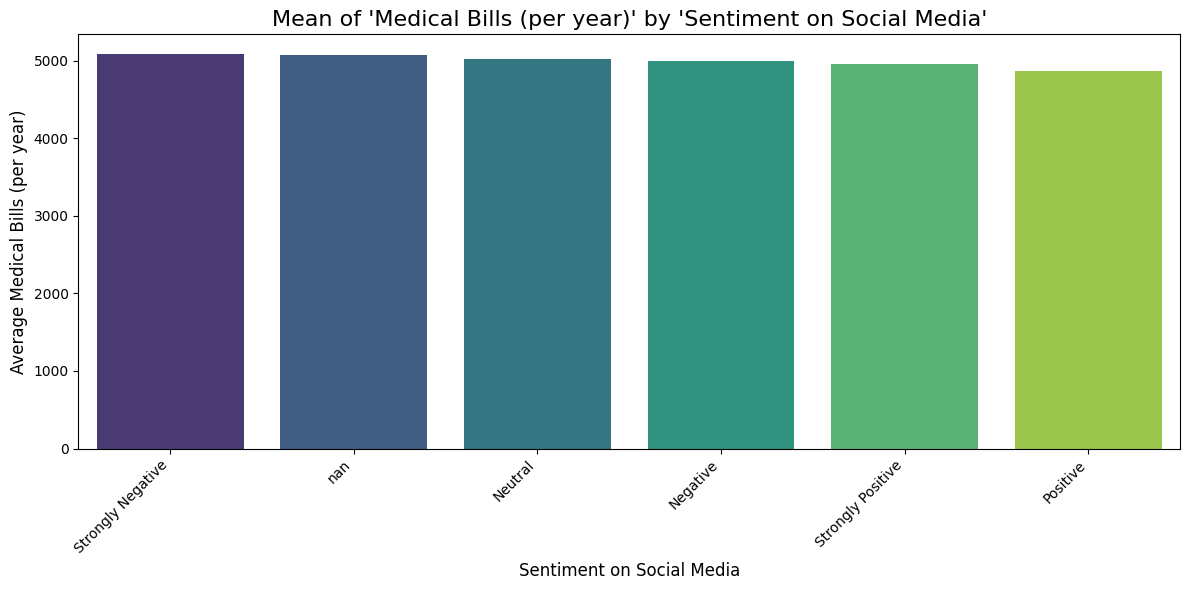

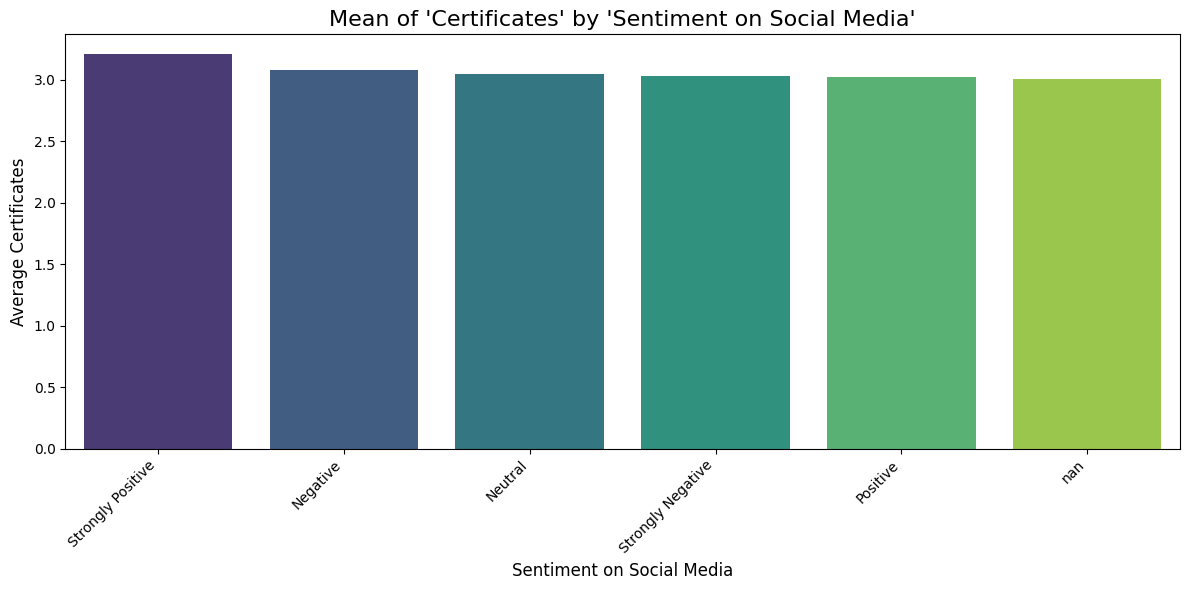

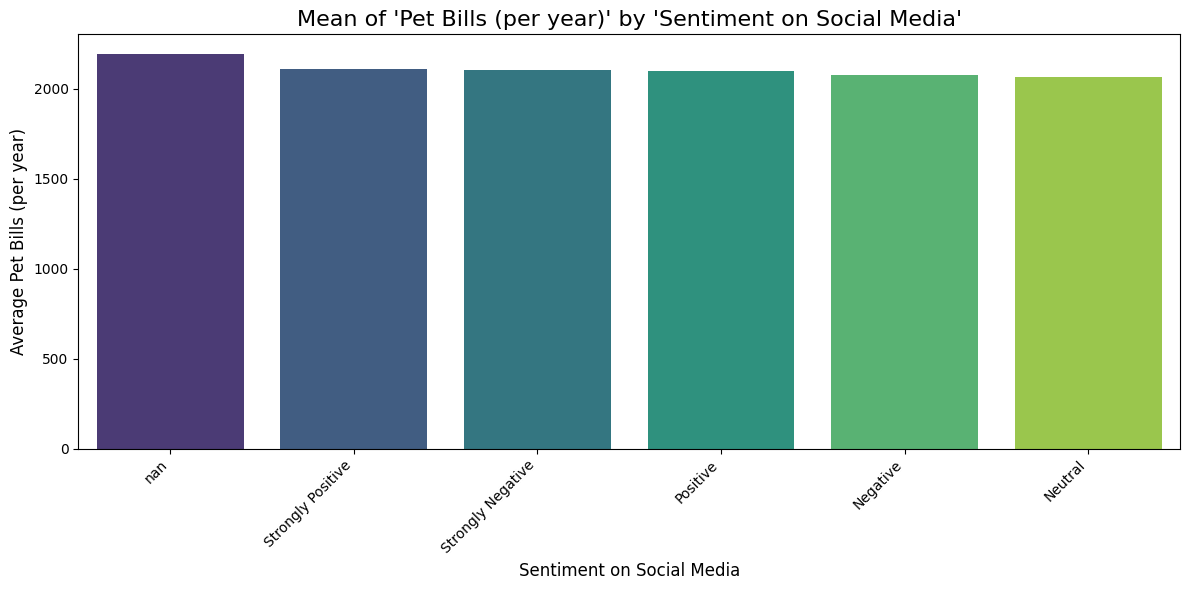

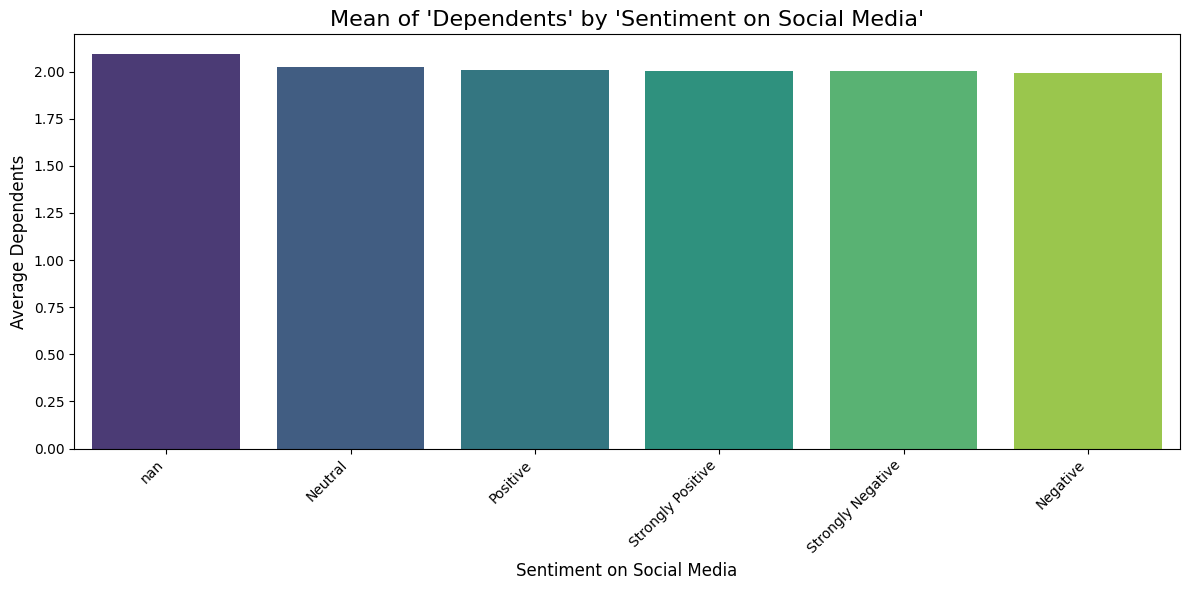


      Exploratory Data Analysis Complete



KeyError: "None of ['Aadhar No.'] are in the columns"

In [8]:
analyze.perform_eda(final_df)

In [ ]:
# analyze.perform_eda(pd.read_csv('data/preprocessed_fabricated_data.csv'))